## Camera Selection

In [1]:
import scipy.io as spio
#from __future__ import print_function

import numpy as np
import os
from ttictoc import TicToc

from IPython.display import clear_output
from IPython import display

import matplotlib.pyplot as plt
#import cv2 as cv
%matplotlib inline

In [2]:
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Categorical
import time, math
 
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()

if use_cuda:
    print ('CUDA is available')
#use_cuda=False   #uncomment this if you dont want to use cuda variables

CUDA is available


In [3]:
import sys
import os
import gc
import collections
import hickle as hkl

sys.path.insert(0, '../data/')
import get_pid_train_test as db
import auxiliary as af

In [4]:
#sys.path.insert(0,'../py-MDNet/modules')
#from sample_generator import *

### For Validation

In [5]:
# Test function
def plot_current_state(ped, c,fno):
    # load image for current location
    img,bb = load_image(ped,c,fno,db_no)

    dpi = 80.0
    #figsize = (img.size[0]/dpi, img.size[1]/dpi)
    figsize = (img.shape[0]/dpi, img.shape[1]/dpi)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # get image and rect handle
    imAX = ax.imshow(img, aspect='normal')
    rect = plt.Rectangle(tuple(bb[0,:2]),bb[0,2],bb[0,3], 
        linewidth=3, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

    plt.pause(.01)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'0000.jpg'),dpi=dpi)
    
    return imAX, rect
    
def plot_second(ped,c,curr_frame, imAX,rect):
    img,bb =  load_image(ped,c,curr_frame,db_no)
    #if np.array(img).shape[0] > 0:
    if img != []:
        imAX.set_data(img)
    #print (bb)

    #if bb.shape[0] > 0:
    if bb != []:
        rect.set_xy(bb[0,:2])
        rect.set_width(bb[0,2])
        rect.set_height(bb[0,3])
        print ('Correct camera')
    elif c!= num_camera-1:
        print ('Wrong camera')

    
    display.display(plt.gcf())
    plt.pause(1)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'%04d.jpg'%(i)),dpi=dpi)

def get_reward_gt(ped, curr_frame, c):
    y = afc.find_target_camera(ped,curr_frame)
    # get reward (give reward at end of episode)
    if y == num_camera-1 and y == c:
        reward = 0.1
    elif y == c:
        reward = 1
    else:
        reward = -1
        
    return reward,y

def get_next_step(ped,c,curr_frame, state):
    # update current state and history
    ispresent,this_state = get_state_vector(ped, c,curr_frame)
    if ispresent:
        next_state = this_state
    else:
        # use previous state
        next_state = state
    
    # get correct label from ground truth
    reward,y = get_reward_gt(ped, curr_frame,c)

    return next_state,reward,y,ispresent

def test_func(pTest, iloc='first', eloc='last', fixLoc=-1, isdebug=0, req_inc=1):
    policy_net.eval()
    rsT,accT = [],[]
    
    for p in range(pTest.shape[0]): 
        reward_sum = 0
        accP = []
        inc = 1
        
        # load p'th person data
        ped = np.copy(pTest[p])
        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        
        # Initialize with current state with start frame
        if iloc == 'first':
            startIDX = 0
        elif iloc == 'rand':
            startIDX = np.random.randint( 0,ped.shape[0]-20 )
        elif iloc == 'fix':
            startIDX = fixLoc
        myPos = ped[startIDX,0:]
        print ('Initial position: ',myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,num_camera))
        ch[:,curr_camera] = 1
        occ_len = 0.0001
        # Make initial state
        _,state,rt = make_state_vector(ped, curr_camera,curr_frame, ch,occ_len)
        #print (state.size())
        num_steps = 0
        #prev_camera = curr_camera
        count_curr_c = 0
        
        if render: # show current location
            plot_current_state(ped, curr_camera,curr_frame)

            display.clear_output(wait=True)
            display.display(plt.gcf())


        while(curr_frame <= ped[-1,1]): # alltime-6):
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
                
            # Only exploitation for testing
            camera_index = torch.argmax(value_c)
            c = camera_index.detach().cpu().numpy()

            # find target for the next frame
            curr_frame += fpsc
            num_steps += 1
            
            # get correct label from ground truth
            reward,y = get_reward_gt(ped, curr_frame,c)
            if req_inc:
                if inc==1 and y!=num_camera-1:
                     # inside a camera
                    accP.append((y,y))
                elif inc==0 and y==c.item(0) and y!=num_camera-1:
                    # transitioning to second camera
                    accP.append((y,c.item(0)))
                    inc = 1
                elif inc==1 and y==num_camera-1:
                    # moving out of a camera FOV
                    inc = 0
                    accP.append((y,c.item(0)))
                else:
                    # Making transition
                    accP.append((y,c.item(0)))
                    #print ('Another case',y,c.item(0))
                    
            else:
                    accP.append((y,c.item(0)))
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0: # and np.random.rand < 0.95:
                bbox = bbox[0]
                rt = np.zeros((4))
                rt[0] = bbox[0]/320
                rt[1] = bbox[1]/240
                rt[2] = bbox[2]/320
                rt[3] = bbox[3]/240
                curr_camera = c
                
                ispresent = 1
                
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.0001
            else:
                occ_len += 0.1
            #if occ_len > occ_max_val:
            #    occ_len = occ_max_val+1
                
            #hcount = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
            hcount = occ_len #np.array(np.log(occ_len))
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:] = afc.make_one_hot_camera(c)
                
            if isdebug:
                print ('x_t: ', curr_camera,rt)
                print ( np.where(ch))
                print ('Q values: ', value_c)
                print (c, curr_frame, hcount)
                print ('isPresent', ispresent)
                print ('')
            
            # get next camera using policy network
            this_cam = np.zeros((num_camera+1))
            this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
            this_cam[num_camera] = hcount
            # make next_state vector
            next_state = np.concatenate((this_cam, rt.ravel()))
            #next_state = np.concatenate((next_state, hcount)) #.ravel()))
            next_state = np.concatenate((next_state, ch.ravel()))
#             next_state[next_state==0] = -1
#             next_state[next_state==1] = 1
            if use_cuda:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).cuda()
            else:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0)
                
            # get next state
            #next_state,reward,y,ispresent = get_next_step(ped,c,curr_frame, state)
            
            # store current reward
            reward_sum += reward
                        
            state = next_state
            prev_camera = c
            
            if render:
                plot_second()
            if eloc != 'last':
                if num_steps > eloc:
                    break
            
        # stack episodic reward 
        rsT.append((reward_sum,num_steps))
        accT.append(accP)
        
    return rsT, accT


### Initialize hyper-parameters

In [6]:
learning_rate = 1e-4
batch_size = 500
replay_memory_size = 4000
#epsilon = 0.1
gamma = 0.98

resume = False # resume from previous checkpoint?
render = False
eps = np.finfo(np.float32).eps.item()


In [7]:
# load dataset
db_no = 4
[pALL,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='train')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pALL = np.array(pALL)

# load test set for current data set
[pTest,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='test')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pTest = np.array(pTest)

Total number of person in data set:  (1, 49)
Total number of person in data set:  (1, 49)


In [8]:
numEpoch = 100000
d = 10
region_size = (d,d)

h_len = 50
input_size = h_len*(num_camera) + num_camera+4+1

# Load auxiliary functions using an object
afc = af.AuxiliaryFunction(num_camera=num_camera, d=d, h_len=h_len)

### Model

In [9]:
# Initialize required parameters
hidden_size1 = 4096
hidden_size2 = 2048
hidden_size3 = 256+256
hidden_size4 = 256

# Required network
class NextCamera(nn.Module):
    def __init__(self):
        super(NextCamera, self).__init__()
        
        # make decoder layers
        self.fch1 = nn.Linear(input_size, hidden_size1)
        self.fch2 = nn.Linear(hidden_size1, hidden_size2)
        self.fch3 = nn.Linear(hidden_size2, hidden_size3)
        self.fch4 = nn.Linear(hidden_size3, hidden_size4)
        self.fco = nn.Linear(hidden_size4, num_camera)
        self.dropout = nn.Dropout(p=0.3)
        
        # Activation function 
        #self.tanh = nn.Tanh() #ReLU()
        self.relu = nn.ReLU() #ReLU()
        #self.linear = nn.Linear() 
        
    def forward(self, x):
        
        x = self.relu(self.fch1(x))
        x = self.relu(self.fch2(x))
        x = self.dropout(x)
        x = self.relu(self.fch3(x))
        x = self.dropout(x)
        x = self.relu(self.fch4(x))
        x = self.dropout(x)
        x = self.fco(x)
            
        return x # nn.functional.softmax(x)

In [10]:
# build the model
if use_cuda:
    policy_net = NextCamera().cuda()
    policy_net.float().cuda()
    criterion = nn.MSELoss().cuda()
else:
    policy_net = NextCamera()
    policy_net.float()
    criterion = nn.MSELoss()
# use ADAM as optimizer since we can load the whole data to train
#cls_weights = [1.0,1.0,1.0,1.0,0.1 ]
#cls_weights = torch.FloatTensor(cls_weights).cuda()
#criterion = nn.CrossEntropyLoss(weight=cls_weights)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [11]:
def backward_network(replay_memory):
    # sample random minibatch
    minibatch = random.sample(replay_memory, min(len(replay_memory), batch_size))
    
    # unpack minibatch
    state = torch.cat(tuple(d[0] for d in minibatch))
    action = torch.cat(tuple(d[1] for d in minibatch))
    reward = torch.cat(tuple(d[2] for d in minibatch))
    next_state = torch.cat(tuple(d[3] for d in minibatch))
    nSteps_boot = tuple(d[4] for d in minibatch)
    
    #print (state.size(), next_state.size(), reward.size(), action.size())

    if use_cuda:  # put on GPU if CUDA is available
        state = state.cuda()
        action = action.cuda()
        reward = reward.cuda()
        next_state = next_state.cuda()

    # get output for the next state
    next_output = policy_net(next_state)

    # set y_j to r_j for terminal state, otherwise to r_j + gamma*max(Q)
    y = torch.cat(tuple(reward[i] if minibatch[i][4]
                              else reward[i] + (gamma**(nSteps_boot[i])) * torch.max(next_output[i])
                              for i in range(len(minibatch))))

    # extract Q-value
    q_value = torch.sum(policy_net(state) * action, dim=1)

    # PyTorch accumulates gradients by default, so they need to be reset in each pass
    optimizer.zero_grad()

    # returns a new Tensor, detached from the current graph, the result will never require gradient
    y = y.detach()

    #print (y, q_value)
    # calculate loss
    loss = criterion(q_value, y)

    # do backward pass
    loss.backward()
    optimizer.step()
    
    return loss.data


### Run episodes

In [12]:
reward_sum = 0
running_reward = None
xs,rs,cprs = [],[],[]
episode_number = 0
episode_durations = []
episode_reward = []
validation_reward= []
replay_memory = []
M = np.zeros((num_camera,num_camera))

In [13]:
# Load model if required
resume = False
backup_fname = './models/Q_db4_xywh_10log'
if resume:
    policy_net = torch.load(backup_fname)
    policy_net.eval()
    print ('Model loaded')
    #episode_reward,running_reward = hkl.load(backup_fname+'_variables.hkl')
    print ('episodic reward loaded')

In [14]:
def make_state_vector(ped, curr_camera,curr_frame, ch,occ_len):
    numSamples = 30
    overlap_thres = [0.9, 1]
        
    # read image
    img,bbox,p = afc.load_image(ped,curr_camera,curr_frame,db_no)
    imw, imh = (320,240) #img.size
    #print (img.size)
    #print (bbox,p)
    #hc = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
    #hc = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
    hc = occ_len #np.array(np.log(occ_len))
    
    if p:
        ## Draw samples
        #examples = gen_samples(SampleGenerator('gaussian', img.size, 0.1, 1.2),
        #                       bbox, numSamples, overlap_thres)  # 50 samples with 0.8 overlap
        ##print (examples.shape)
        #samples = examples[np.random.randint(len(examples))].reshape(1,4)
        ##print (samples)
        ##rt = afc.find_curr_rt(samples[0])
        #bbox = samples[0]
        rt = np.zeros((4))
        rt[0] = bbox[0]/imw
        rt[1] = bbox[1]/imh
        rt[2] = bbox[2]/imw
        rt[3] = bbox[3]/imh
        #print (np.where(rt.ravel()))
        
        # make next_state vector
        this_cam = np.zeros((num_camera+1))
        this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
        this_cam[num_camera] = hc
        state = np.concatenate((this_cam, rt.ravel()))
        #state = np.concatenate((state, hc)) #.ravel()))
        state = np.concatenate((state, ch.ravel()))
        state = state.reshape(1,-1)
        
        if use_cuda:
            state = torch.from_numpy(state).float().cuda()
        else:
            state = torch.from_numpy(state).float()
    else:
        print ('Target is not present in ',c,curr_frame)
        state = []
    
    return p,state,rt

def append_reward(rs,num_steps):
    if len(rs) > 0:
        # stack episodic reward 
        epR = np.vstack(rs)
        rs = []

        # append the episodic reward
        #episode_number += 1
        #episode_durations.append(num_steps)
        reward_stat = [num_steps,np.std(epR),np.sum(epR)]
        episode_reward.append(reward_stat)
    
    return rs


In [15]:
epoch = 0
occ_max_val = 100
NBoot = 20
t = TicToc('episodic')
t.tic()

In [16]:
policy_net.train()
max_ep_len = 200

while epoch < numEpoch:
#for epoch in range(numEpoch):
    # repeat for all pedestrians
    #disp(pALL)
     
    for p in range(pALL.shape[0]): #range(pInLoop.shape[0])
        
        # load p'th person data
        ped = np.copy(pALL[p])

        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        #print (np.unique(ped[:,0]))
        
        # check if camera number is correct
        if (ped[:,0] >= num_camera).any():
            print ('Error in person ', p)
            break
            
        if ped.shape[0] < 2*max_ep_len:
            continue
        
        # select a camera uniformly
        uniq_cam = np.unique(ped[:,0])
        if len(uniq_cam) < 2: # and np.random.rand() < 0.9:
            continue
        rand_cam = uniq_cam[np.random.randint(len(uniq_cam))]
        index_of_rand_cam = np.nonzero( ped[:,0]==rand_cam )[0]
        len_indices_rand_cam = len(index_of_rand_cam)
        
        # Initialize with current state with start frame
        #tranIDX = np.where(ped[1:,0]-ped[0:-1,0])[0]
        #startIDX = np.random.choice(tranIDX) if np.random.rand(1) < 0.6 else np.random.randint( 0,ped.shape[0]-max_ep_len )
        startIDX = index_of_rand_cam[np.random.randint(len_indices_rand_cam)]
        print ('startIDX: ',startIDX)
        myPos = ped[startIDX,0:]
        #print (myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        tmp_ep = []
        rs = []
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,num_camera))
        ch[:,curr_camera] = 1
        
        # initialize total time target was occluded
        num_steps = 0
        occ_len = 0.0001
        
        # create initial state (ct,rt,tau_t)
        #bbox = myPos[2:]
        #rt = afc.find_curr_rt(bbox)
        _,state,rt=make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        stCam = curr_camera
        count_curr_c = 0
        prev_camera = curr_camera

        if render: # show current location
            plt.imshow(x.reshape(input_size))
            display.clear_output(wait=True)
            display.display(plt.gcf())
                       
        while(curr_frame <= ped[-1,1]):
            
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            
            # epsilon annealing
            #gamma = np.min([np.log(epoch+1.1),0.9])
            #gamma = gamma.item(0)
            epsilon = 1 / np.log(epoch + 0.0000001)
                 
            # initialize action
            one_hot_action = torch.zeros([num_camera], dtype=torch.float32)
            if use_cuda:  # put on GPU if CUDA is available
                one_hot_action = one_hot_action.cuda()

            # epsilon greedy exploration
            random_action = np.random.random() <= epsilon
            camera_index = [torch.randint(num_camera, torch.Size([]), dtype=torch.int)
                            if random_action
                            else torch.argmax(value_c)][0]

            if use_cuda:  # put on GPU if CUDA is available
                camera_index = camera_index.cuda()

            one_hot_action[camera_index] = 1
            one_hot_action = one_hot_action.unsqueeze(0)
            c = camera_index.detach().cpu().numpy()
            
            # generate random steps
            if np.random.rand(1) < 0.2:
                rsteps = np.random.randint(5)
            else:
                rsteps = fpsc
            
            # find target for the next frame
            curr_frame += rsteps #fpsc
            num_steps += 1
            M[stCam,c] += 1
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0:
                #rt = afc.find_curr_rt(bbox[0]) 
                bbox = bbox[0]
                rt = np.zeros((4))
                rt[0] = bbox[0]/320
                rt[1] = bbox[1]/240
                rt[2] = bbox[2]/320
                rt[3] = bbox[3]/240
                #print (rt, np.where(rt))
                curr_camera = c
                #ch = np.zeros((h_len,num_camera))
                #num_steps = 0
                ispresent = 1
                stCam = c
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.0001
            else:
                occ_len += 0.1*rsteps
            #if occ_len > occ_max_val:
            #    occ_len = occ_max_val+1
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = occ_len #np.array(np.log(occ_len))
            #hcount = np.array(-2 + (occ_len/occ_max_val)*(2-(-2)))
            
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:] = afc.make_one_hot_camera(c)
            
            # get next camera using policy network
            this_cam = np.zeros((num_camera+1))
            this_cam[0:num_camera] = afc.make_one_hot_camera(curr_camera)
            this_cam[num_camera] = hcount
            # make next_state vector
            next_state = np.concatenate((this_cam, rt.ravel()))
            #next_state = np.concatenate((next_state, hcount)) #.ravel()))
            next_state = np.concatenate((next_state, ch.ravel()))

            if use_cuda:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).cuda()
            else:
                next_state = torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0)
                
            # get correct label from ground truth
            y = afc.find_target_camera(ped, curr_frame)
            # get reward (give reward at end of episode)
            if y == num_camera-1 and y == c:
                reward = 0.1
            elif y == c:
                reward = 1
            else:
                reward = -1
                 
            if np.random.rand() < 0.2 and epoch > 50000:
                print (epoch, p, random_action, rsteps)
                print ('x_t: ', curr_camera,rt)
                #print ( np.where(ch))
                print ('Q values: ', value_c)
                print (y,c, curr_frame, num_steps, hcount)
                print ('isPresent', ispresent)
                print ('')
                
            reward_sum += reward
            rs.append(reward)
                
            # save transition to replay memory
            tmp_ep.append((state, one_hot_action, reward, next_state, ispresent))
            
            state = next_state
            
            if num_steps >= max_ep_len and c!=num_camera-1 and y == c:  # break the episode
                #replay_memory.append((state, one_hot_action, reward, next_state, ispresent))
                print (epoch, p, random_action)
                print ('x_t: ', curr_camera,rt)
                #print ( np.where(ch)[1])
                print ('Q values: ', value_c)
                print (y,c, curr_frame, num_steps, hcount)
                print ('isPresent', ispresent)
                print ('')
                
                # Append to the experience buffer
                for tmp_i in range(0,len(tmp_ep)):
                    this_tmp = tmp_ep[tmp_i]
                    # compute n-step return
                    rew = 0
                    for ni in range(NBoot):
                        if (tmp_i+ni) < len(tmp_ep):
                            rew += rs[tmp_i+ni]*(gamma**ni)
                    if use_cuda:
                        reward = torch.from_numpy(np.array([rew], dtype=np.float32)).unsqueeze(0).cuda()
                    else:
                        reward = torch.from_numpy(np.array([rew], dtype=np.float32)).unsqueeze(0)
                    # get the next state
                    next_state = tmp_ep[np.min([tmp_i+NBoot-1,len(tmp_ep)-1])]
                    next_state = next_state[3]
                    
                    replay_memory.append((this_tmp[0],this_tmp[1],reward,next_state,np.min([NBoot,len(tmp_ep)-tmp_i])))
                    if len(replay_memory) > replay_memory_size:
                        replay_memory.pop(0)
                tmp_ep = []
                break
        
        # update value_function
        if len(replay_memory) > 0:
            loss = backward_network(replay_memory)
        
        # store episodic reward
        rs = append_reward(rs,num_steps)
        
        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        if epoch % 2 == 0:
            print ('ep %d: ep_len:%d episode reward: total was %f. running mean: %f' % (epoch, num_steps, reward_sum, running_reward))
        #if epoch % 1000 == 1: 
        #    torch.save(policy_net, backup_fname)
        #    #hkl.dump([[episode_reward,validation_reward, running_reward]], backup_fname+'_variables.hkl')
            
        reward_sum = 0
        num_steps = 0
        rs = []
        
    #print (M)
    epoch += 1
    if epoch % 10 == 0:
        t.toc()
        print('Time elapsed: ', t.elapsed)
        

startIDX:  708
0 0 False
x_t:  2 [0.015625   0.40833333 0.08125    0.275     ]
Q values:  tensor([[-0.2446, -0.0034,  0.1151, -0.0739, -0.0031,  0.0538]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8871 853 0.0001
isPresent 1

ep 0: ep_len:853 episode reward: total was -536.400000. running mean: -536.400000
startIDX:  1032
ep 0: ep_len:245 episode reward: total was -241.000000. running mean: -533.446000
startIDX:  2565
0 5 False
x_t:  2 [0.003125   0.4        0.075      0.25833333]
Q values:  tensor([[-0.6436, -0.3040, -0.1937, -0.4830, -0.7739, -1.0441]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21545 782 0.0001
isPresent 1

ep 0: ep_len:782 episode reward: total was -780.000000. running mean: -535.911540
startIDX:  735
0 10 False
x_t:  1 [0.003125   0.3625     0.13125    0.37916667]
Q values:  tensor([[-0.2710, -0.0736, -0.2721, -0.2331, -0.2893, -0.4890]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7106 221 0.0001
isPresent 1

ep 0: ep_len:221 episode

4 12 False
x_t:  2 [0.771875   0.40416667 0.04375    0.25      ]
Q values:  tensor([[ -8.4929, -10.0742,  -5.6954,  -8.6432,  -7.4265,  -7.9977]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2816 281 0.0001
isPresent 1

ep 4: ep_len:281 episode reward: total was -231.900000. running mean: -502.661023
startIDX:  85
4 15 False
x_t:  3 [0.75       0.35       0.13125    0.41666667]
Q values:  tensor([[-7.0835, -7.5822, -7.4430, -6.0022, -7.0229, -6.3053]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 532 213 0.0001
isPresent 1

ep 4: ep_len:213 episode reward: total was -174.700000. running mean: -499.381413
startIDX:  2643
4 22 True
x_t:  4 [0.00625    0.40833333 0.103125   0.30416667]
Q values:  tensor([[ -9.1971, -16.5183, -12.6770, -15.2389, -15.9677, -11.7099]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27263 552 0.0001
isPresent 1

ep 4: ep_len:552 episode reward: total was -428.000000. running mean: -498.667599
startIDX:  1966
5 0 True
x_t:  1 [0.003125 0

8 22 False
x_t:  4 [0.009375   0.39166667 0.084375   0.3       ]
Q values:  tensor([[-24.8772, -24.6236, -24.4866, -29.9388, -17.4953, -29.5916]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16325 565 0.0001
isPresent 1

ep 8: ep_len:565 episode reward: total was -433.700000. running mean: -472.590372
startIDX:  1148
9 0 False
x_t:  2 [0.7875     0.4        0.103125   0.29166667]
Q values:  tensor([[-17.9622, -18.9742, -16.4140, -20.4435, -20.9364, -17.9808]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12630 320 0.0001
isPresent 1

startIDX:  871
9 1 True
x_t:  4 [0.003125   0.39583333 0.11875    0.40833333]
Q values:  tensor([[-28.8038, -31.6973, -30.1388, -26.9326, -29.3650, -27.8099]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35421 538 0.0001
isPresent 1

startIDX:  2230
9 5 False
x_t:  3 [0.828125   0.33333333 0.11875    0.45      ]
Q values:  tensor([[-12.4369, -13.4163,  -9.5156,  -8.3361, -13.9200, -16.2563]],
       device='cuda:0', grad_fn=<Addmm

13 5 True
x_t:  2 [0.00625    0.40416667 0.096875   0.2625    ]
Q values:  tensor([[-34.3780, -41.4149, -35.2906, -29.4161, -22.9169, -18.3328]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12006 720 0.0001
isPresent 1

startIDX:  813
13 10 True
x_t:  0 [0.81875    0.39166667 0.1125     0.32083333]
Q values:  tensor([[-32.0692, -27.2392, -31.2464, -22.7547, -16.7356, -22.4479]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8115 506 0.0001
isPresent 1

startIDX:  1620
13 12 False
x_t:  2 [0.15   0.4125 0.075  0.2875]
Q values:  tensor([[-37.2329, -29.3199, -27.9556, -39.8047, -36.8074, -32.7187]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19399 711 0.0001
isPresent 1

startIDX:  2312
13 15 False
x_t:  3 [0.096875   0.27083333 0.059375   0.30416667]
Q values:  tensor([[-44.5941, -38.7510, -42.0681, -35.2030, -36.6500, -37.6978]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18179 1251 0.0001
isPresent 1

startIDX:  2653
13 22 False
x_t:  4 [0.00625    

startIDX:  88
17 15 False
x_t:  3 [0.8375     0.35833333 0.1375     0.42916667]
Q values:  tensor([[-23.3018, -23.1825, -24.0009, -21.2953, -24.9119, -21.8805]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 522 209 0.0001
isPresent 1

startIDX:  2242
17 22 True
x_t:  1 [0.8625     0.30833333 0.134375   0.45416667]
Q values:  tensor([[-23.2572, -30.2410, -28.3487, -30.0878, -30.0508, -28.1223]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22932 1096 0.0001
isPresent 1

startIDX:  2386
18 0 True
x_t:  3 [0.2      0.25     0.071875 0.275   ]
Q values:  tensor([[-32.5784, -30.7155, -35.6935, -31.8418, -27.6924, -31.4497]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26131 1238 0.0001
isPresent 1

ep 18: ep_len:1238 episode reward: total was -990.000000. running mean: -458.303045
startIDX:  301
18 1 False
x_t:  0 [0.759375   0.375      0.115625   0.39166667]
Q values:  tensor([[-21.3094, -25.5735, -28.6594, -25.6731, -32.2924, -27.7651]],
       device='cuda:0', gr

22 1 False
x_t:  1 [0.85625    0.26666667 0.140625   0.45833333]
Q values:  tensor([[-31.8076, -23.6590, -25.4914, -31.2738, -26.1834, -25.8281]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30680 749 0.0001
isPresent 1

ep 22: ep_len:749 episode reward: total was -604.000000. running mean: -460.808167
startIDX:  1581
22 5 False
x_t:  1 [0.8125     0.28333333 0.115625   0.31666667]
Q values:  tensor([[-24.5998, -18.6156, -23.0535, -26.7284, -23.7748, -30.1036]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14929 688 0.0001
isPresent 1

ep 22: ep_len:688 episode reward: total was -514.300000. running mean: -461.343085
startIDX:  37
22 10 False
x_t:  3 [0.059375   0.24166667 0.05625    0.25      ]
Q values:  tensor([[-26.4179, -24.0243, -30.3325, -21.8195, -24.2476, -32.8577]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3577 1088 0.0001
isPresent 1

ep 22: ep_len:1088 episode reward: total was -806.700000. running mean: -464.796654
startIDX:  927
22 12 False
x_

26 5 False
x_t:  1 [0.175      0.33333333 0.109375   0.50833333]
Q values:  tensor([[-23.1162, -20.8202, -22.3685, -24.5961, -27.2303, -25.4094]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22120 239 0.0001
isPresent 1

ep 26: ep_len:239 episode reward: total was -191.600000. running mean: -451.371145
startIDX:  922
26 10 True
x_t:  1 [0.671875 0.2875   0.121875 0.3375  ]
Q values:  tensor([[-31.0581, -30.8185, -28.7342, -34.5545, -29.4797, -29.7178]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11353 1603 0.0001
isPresent 1

ep 26: ep_len:1603 episode reward: total was -1219.100000. running mean: -459.048433
startIDX:  1395
26 12 False
x_t:  3 [0.684375   0.35       0.14375    0.42916667]
Q values:  tensor([[-29.3655, -29.1411, -32.3988, -21.6644, -29.9588, -27.3720]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17861 202 0.0001
isPresent 1

ep 26: ep_len:202 episode reward: total was -151.400000. running mean: -455.971949
startIDX:  717
26 15 True
x_t:  2 

30 12 False
x_t:  2 [0.00625    0.4125     0.10625    0.28333333]
Q values:  tensor([[-31.2568, -24.0247, -20.0846, -22.5743, -28.2659, -26.1909]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19381 759 0.0001
isPresent 1

ep 30: ep_len:759 episode reward: total was -552.500000. running mean: -452.055946
startIDX:  389
30 15 True
x_t:  0 [0.765625   0.40416667 0.0625     0.34583333]
Q values:  tensor([[-32.0460, -25.9196, -24.9648, -26.2177, -25.5247, -28.1956]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3682 457 0.0001
isPresent 1

ep 30: ep_len:457 episode reward: total was -359.700000. running mean: -451.132387
startIDX:  1602
30 22 False
x_t:  3 [0.878125   0.35416667 0.11875    0.40833333]
Q values:  tensor([[-26.1041, -29.8621, -30.2975, -24.7697, -25.8311, -28.8265]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16842 259 0.0001
isPresent 1

ep 30: ep_len:259 episode reward: total was -195.900000. running mean: -448.580063
startIDX:  2145
31 0 False
x_

ep 34: ep_len:542 episode reward: total was -414.500000. running mean: -441.955647
startIDX:  1695
35 0 False
x_t:  3 [0.259375   0.26666667 0.096875   0.30833333]
Q values:  tensor([[-30.7170, -27.2535, -27.1979, -25.4604, -27.3751, -29.4927]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16906 201 0.0001
isPresent 1

startIDX:  108
35 1 False
x_t:  3 [0.065625   0.225      0.0625     0.26666667]
Q values:  tensor([[-28.5535, -29.0789, -27.1373, -23.9050, -26.0305, -25.6332]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25796 207 0.0001
isPresent 1

startIDX:  1837
35 5 True
x_t:  2 [0.8125     0.4        0.075      0.25833333]
Q values:  tensor([[-33.0404, -26.3296, -31.8671, -27.5845, -21.6263, -30.3699]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15649 347 0.0001
isPresent 1

startIDX:  742
35 10 False
x_t:  1 [0.1      0.35     0.128125 0.375   ]
Q values:  tensor([[-34.9788, -25.9926, -29.3073, -28.5588, -29.4537, -26.4209]],
       device='cuda:0', gr

startIDX:  330
39 10 False
x_t:  3 [0.728125   0.3        0.1375     0.39583333]
Q values:  tensor([[-28.4020, -23.8571, -25.0222, -23.1541, -32.2199, -27.6459]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5049 224 0.0001
isPresent 1

startIDX:  64
39 12 False
x_t:  1 [0.94375    0.3        0.05       0.43333333]
Q values:  tensor([[-22.6173, -21.6648, -25.4860, -25.8721, -23.4801, -27.6466]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2214 619 0.0001
isPresent 1

startIDX:  41
39 15 False
x_t:  3 [0.75       0.34166667 0.1375     0.43333333]
Q values:  tensor([[-25.5927, -30.1827, -27.6972, -22.9300, -26.6829, -29.8358]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 531 236 0.0001
isPresent 1

startIDX:  846
39 22 True
x_t:  1 [0.009375 0.3625   0.08125  0.4     ]
Q values:  tensor([[-30.5907, -29.1046, -26.9536, -26.0119, -30.6378, -29.2722]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9481 265 0.0001
isPresent 1

Time elapsed:  305.2572610378265

startIDX:  2216
43 22 False
x_t:  1 [0.85       0.3125     0.128125   0.45833333]
Q values:  tensor([[-28.9816, -22.2628, -26.7284, -30.4291, -23.2174, -27.1933]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22935 1107 0.0001
isPresent 1

startIDX:  1123
44 0 False
x_t:  2 [0.7375     0.40833333 0.071875   0.28333333]
Q values:  tensor([[-27.0872, -27.1059, -19.3576, -29.4786, -23.9920, -24.7324]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12642 340 0.0001
isPresent 1

ep 44: ep_len:340 episode reward: total was -257.000000. running mean: -430.020207
startIDX:  965
44 1 False
x_t:  4 [0.01875    0.38333333 0.10625    0.41666667]
Q values:  tensor([[-29.3218, -26.9380, -27.8614, -27.2795, -24.2565, -24.6031]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35426 484 0.0001
isPresent 1

ep 44: ep_len:484 episode reward: total was -373.700000. running mean: -429.457005
startIDX:  722
44 5 False
x_t:  3 [0.109375   0.27083333 0.075      0.30833333]
Q values:  tens

ep 48: ep_len:746 episode reward: total was -563.000000. running mean: -441.051387
startIDX:  1078
48 1 False
x_t:  3 [0.65625    0.3        0.121875   0.37083333]
Q values:  tensor([[-25.8617, -28.5147, -28.4248, -25.8558, -27.4622, -27.4832]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35929 202 0.0001
isPresent 1

ep 48: ep_len:202 episode reward: total was -149.400000. running mean: -438.134873
startIDX:  1971
48 5 False
x_t:  3 [0.0625     0.25416667 0.08125    0.25833333]
Q values:  tensor([[-24.0758, -25.1642, -26.5736, -23.4879, -25.0621, -30.0905]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18202 1273 0.0001
isPresent 1

ep 48: ep_len:1273 episode reward: total was -963.500000. running mean: -443.388524
startIDX:  5
48 10 False
x_t:  3 [0.059375   0.2375     0.05625    0.25416667]
Q values:  tensor([[-28.0771, -26.4784, -25.3546, -23.8706, -27.6656, -28.9651]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3576 1114 0.0001
isPresent 1

ep 48: ep_len

ep 52: ep_len:760 episode reward: total was -614.700000. running mean: -440.094564
startIDX:  80
52 5 True
x_t:  2 [0.190625   0.375      0.128125   0.43333333]
Q values:  tensor([[-29.3471, -25.3028, -22.4741, -24.8577, -25.7598, -24.0155]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2070 902 0.0001
isPresent 1

ep 52: ep_len:902 episode reward: total was -656.900000. running mean: -442.262619
startIDX:  2239
52 10 False
x_t:  1 [0.76875    0.2875     0.125      0.33333333]
Q values:  tensor([[-27.6111, -19.9974, -24.9935, -21.3765, -25.6295, -25.2666]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22481 1282 0.0001
isPresent 1

ep 52: ep_len:1282 episode reward: total was -975.100000. running mean: -447.590992
startIDX:  723
52 12 False
x_t:  1 [0.340625   0.35833333 0.121875   0.5125    ]
Q values:  tensor([[-28.2383, -20.9656, -27.1237, -28.7032, -26.0360, -26.8083]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10326 209 0.0001
isPresent 1

ep 52: ep_len:

56 10 False
x_t:  4 [0.003125   0.36666667 0.078125   0.25      ]
Q values:  tensor([[-31.2962, -31.5353, -31.8500, -29.2031, -26.9043, -32.1053]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4542 456 0.0001
isPresent 1

ep 56: ep_len:456 episode reward: total was -342.700000. running mean: -458.235899
startIDX:  1305
56 12 False
x_t:  4 [0.059375   0.43333333 0.15       0.37083333]
Q values:  tensor([[-24.6746, -29.8460, -26.8468, -32.5265, -23.2628, -29.1698]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17399 429 0.0001
isPresent 1

ep 56: ep_len:429 episode reward: total was -310.600000. running mean: -456.759540
startIDX:  371
56 15 False
x_t:  1 [0.671875   0.30416667 0.0875     0.52916667]
Q values:  tensor([[-31.4488, -22.2874, -28.4874, -28.6059, -28.4801, -33.3885]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2802 257 0.0001
isPresent 1

ep 56: ep_len:257 episode reward: total was -181.300000. running mean: -454.004945
startIDX:  2596
56 22 True
x_

60 15 False
x_t:  2 [0.79375 0.4125  0.08125 0.2875 ]
Q values:  tensor([[-25.6532, -31.4242, -24.1184, -26.6051, -27.1791, -24.1476]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5967 371 0.0001
isPresent 1

ep 60: ep_len:371 episode reward: total was -280.500000. running mean: -445.464443
startIDX:  1749
60 22 False
x_t:  3 [0.434375   0.30416667 0.109375   0.32916667]
Q values:  tensor([[-26.7358, -22.4139, -26.5421, -21.8659, -23.9195, -26.5678]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16908 204 0.0001
isPresent 1

ep 60: ep_len:204 episode reward: total was -143.000000. running mean: -442.439799
startIDX:  287
61 0 False
x_t:  3 [0.059375   0.23333333 0.0625     0.225     ]
Q values:  tensor([[-24.6933, -23.6260, -25.7625, -19.4629, -23.5067, -23.4964]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4828 1249 0.0001
isPresent 1

startIDX:  961
61 1 False
x_t:  4 [0.096875   0.37916667 0.134375   0.4125    ]
Q values:  tensor([[-27.9459, -26.7710, -25.

64 22 False
x_t:  1 [0.8625     0.29583333 0.096875   0.5       ]
Q values:  tensor([[-33.5103, -27.7126, -31.4991, -31.0447, -31.3915, -30.3738]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11918 746 0.0001
isPresent 1

ep 64: ep_len:746 episode reward: total was -552.900000. running mean: -456.842800
startIDX:  688
65 0 False
x_t:  2 [0.109375   0.40833333 0.0875     0.275     ]
Q values:  tensor([[-23.4609, -25.3417, -19.8414, -20.3253, -20.5142, -20.9695]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8885 874 0.0001
isPresent 1

startIDX:  1020
65 1 False
x_t:  3 [0.790625   0.29583333 0.1125     0.42916667]
Q values:  tensor([[-23.7641, -22.8328, -23.7521, -22.1848, -23.5750, -23.2838]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35908 219 0.0001
isPresent 1

startIDX:  1802
65 5 True
x_t:  2 [0.834375   0.39583333 0.046875   0.25416667]
Q values:  tensor([[-25.0234, -26.6213, -26.6227, -28.4261, -21.1042, -24.1735]],
       device='cuda:0', grad_fn=<A

startIDX:  587
69 1 False
x_t:  2 [0.8125     0.38333333 0.1125     0.30833333]
Q values:  tensor([[-31.5950, -31.3248, -25.4730, -28.5097, -30.1519, -30.4475]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31459 384 0.0001
isPresent 1

startIDX:  2292
69 5 True
x_t:  3 [0.34375    0.27916667 0.11875    0.3375    ]
Q values:  tensor([[-20.9258, -22.5073, -22.8998, -22.1240, -21.4409, -20.4432]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19950 201 0.0001
isPresent 1

startIDX:  1778
69 10 False
x_t:  2 [0.025      0.39583333 0.053125   0.25416667]
Q values:  tensor([[-22.7464, -21.4739, -21.2199, -24.2112, -29.6648, -21.3759]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18146 868 0.0001
isPresent 1

startIDX:  1847
69 12 False
x_t:  0 [0.209375   0.425      0.08125    0.35833333]
Q values:  tensor([[-28.9052, -31.4500, -29.0121, -32.2751, -32.7180, -29.1168]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22990 961 0.0001
isPresent 1

startIDX:  3046


73 12 False
x_t:  1 [0.61875    0.37916667 0.125      0.48333333]
Q values:  tensor([[-25.5286, -24.5267, -24.8530, -24.9675, -27.3461, -24.5913]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12928 619 0.0001
isPresent 1

startIDX:  2251
73 15 False
x_t:  3 [0.175      0.28333333 0.1        0.32083333]
Q values:  tensor([[-24.2178, -22.6619, -19.5831, -19.3317, -21.5405, -19.3909]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18196 1296 0.0001
isPresent 1

startIDX:  445
73 22 False
x_t:  4 [0.009375   0.41666667 0.09375    0.37083333]
Q values:  tensor([[-30.2312, -29.9702, -27.7325, -29.1254, -25.2476, -27.4324]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6625 838 0.0001
isPresent 1

startIDX:  1115
74 0 False
x_t:  2 [0.575      0.40833333 0.096875   0.29583333]
Q values:  tensor([[-25.5991, -31.1531, -23.8865, -28.8320, -26.7898, -28.4535]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12664 356 0.0001
isPresent 1

ep 74: ep_len:356 episode rewa

78 0 False
x_t:  3 [0.559375 0.3125   0.08125  0.375   ]
Q values:  tensor([[-26.5666, -25.8474, -25.7692, -24.3109, -28.6044, -28.0088]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16852 200 0.0001
isPresent 1

ep 78: ep_len:200 episode reward: total was -106.800000. running mean: -449.397286
startIDX:  517
78 1 False
x_t:  1 [0.6875     0.27083333 0.109375   0.4625    ]
Q values:  tensor([[-30.2931, -26.0733, -27.4394, -29.5940, -29.6921, -28.4347]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30700 770 0.0001
isPresent 1

ep 78: ep_len:770 episode reward: total was -571.400000. running mean: -450.617313
startIDX:  2719
78 5 False
x_t:  1 [0.146875   0.3375     0.13125    0.50416667]
Q values:  tensor([[-26.9494, -22.8763, -26.4924, -26.6292, -28.0559, -24.9987]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22118 233 0.0001
isPresent 1

ep 78: ep_len:233 episode reward: total was -190.500000. running mean: -448.016140
startIDX:  1310
78 10 False
x_t:  3 [0

ep 82: ep_len:753 episode reward: total was -583.600000. running mean: -454.406543
startIDX:  2793
82 5 False
x_t:  0 [0.94375    0.38333333 0.046875   0.3125    ]
Q values:  tensor([[-27.5398, -33.6757, -30.6283, -29.5889, -29.0844, -31.3065]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23146 482 0.0001
isPresent 1

ep 82: ep_len:482 episode reward: total was -386.400000. running mean: -453.726477
startIDX:  739
82 10 False
x_t:  1 [0.0875     0.34583333 0.084375   0.37916667]
Q values:  tensor([[-35.9895, -29.3600, -32.9103, -32.2972, -32.9768, -30.8866]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7113 230 0.0001
isPresent 1

ep 82: ep_len:230 episode reward: total was -177.900000. running mean: -450.968212
startIDX:  1081
82 12 False
x_t:  3 [0.065625   0.2625     0.0625     0.24583333]
Q values:  tensor([[-32.7390, -32.6162, -34.6461, -28.5257, -29.1285, -31.5660]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16373 1399 0.0001
isPresent 1

ep 82: ep_le

86 15 False
x_t:  3 [0.065625   0.275      0.084375   0.29583333]
Q values:  tensor([[-24.3985, -20.8502, -21.7387, -18.8567, -21.5845, -22.0752]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18172 1296 0.0001
isPresent 1

ep 86: ep_len:1296 episode reward: total was -942.500000. running mean: -442.649100
startIDX:  598
86 22 False
x_t:  3 [0.60625    0.32083333 0.115625   0.35      ]
Q values:  tensor([[-26.7232, -28.4554, -31.1409, -24.3042, -27.3753, -25.7129]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7088 208 0.0001
isPresent 1

ep 86: ep_len:208 episode reward: total was -171.900000. running mean: -439.941609
startIDX:  2236
87 0 True
x_t:  2 [0.890625   0.4        0.053125   0.16666667]
Q values:  tensor([[-22.5858, -25.3655, -21.5131, -22.5887, -22.8897, -20.5986]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23574 313 0.0001
isPresent 1

startIDX:  441
87 1 False
x_t:  1 [0.859375   0.25833333 0.1375     0.47083333]
Q values:  tensor([[-27.0968, -

ep 90: ep_len:795 episode reward: total was -603.300000. running mean: -436.207318
startIDX:  2127
91 0 False
x_t:  1 [0.665625 0.3125   0.115625 0.5125  ]
Q values:  tensor([[-30.0687, -25.8772, -31.1352, -26.7723, -30.4579, -26.9527]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22935 1140 0.0001
isPresent 1

startIDX:  831
91 1 True
x_t:  4 [0.309375   0.37916667 0.10625    0.37916667]
Q values:  tensor([[-28.1143, -30.7947, -31.2651, -30.1680, -32.1094, -29.5556]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35507 595 0.0001
isPresent 1

startIDX:  1083
91 5 False
x_t:  3 [0.225      0.24583333 0.071875   0.29583333]
Q values:  tensor([[-24.0160, -25.7503, -25.1460, -23.0324, -25.4208, -24.2956]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10579 203 0.0001
isPresent 1

startIDX:  2158
91 10 False
x_t:  0 [0.878125   0.3875     0.10625    0.35833333]
Q values:  tensor([[-27.4654, -27.5134, -30.4009, -29.5900, -32.6645, -28.5484]],
       device='cuda:0', 

startIDX:  924
95 5 True
x_t:  3 [0.825      0.3375     0.165625   0.40416667]
Q values:  tensor([[-31.9961, -30.0618, -30.7892, -33.7262, -28.7847, -30.9495]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10485 224 0.0001
isPresent 1

startIDX:  2473
95 10 False
x_t:  1 [0.696875   0.2875     0.115625   0.32916667]
Q values:  tensor([[-24.3022, -22.3093, -22.3517, -27.6126, -27.2631, -25.3910]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22488 1144 0.0001
isPresent 1

startIDX:  980
95 12 False
x_t:  2 [0.734375   0.4125     0.0875     0.24583333]
Q values:  tensor([[-26.9650, -26.7899, -24.4488, -26.9532, -27.8530, -28.2105]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13584 329 0.0001
isPresent 1

startIDX:  1740
95 15 False
x_t:  1 [0.44375    0.31666667 0.075      0.38333333]
Q values:  tensor([[-27.6701, -25.9403, -26.1734, -28.3719, -30.4430, -29.7419]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12493 233 0.0001
isPresent 1

startIDX:  2091

startIDX:  245
99 12 True
x_t:  3 [0.15       0.2625     0.0625     0.28333333]
Q values:  tensor([[-23.6357, -26.8758, -22.7045, -26.4383, -26.8509, -23.1514]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5682 1386 0.0001
isPresent 1

startIDX:  522
99 15 False
x_t:  1 [0.7375     0.30416667 0.0875     0.27083333]
Q values:  tensor([[-24.1233, -21.4706, -26.6893, -22.5713, -22.0230, -27.0581]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5189 735 0.0001
isPresent 1

startIDX:  2759
99 22 True
x_t:  4 [0.00625    0.40833333 0.125      0.3125    ]
Q values:  tensor([[-27.4730, -32.9295, -35.1192, -29.9414, -31.1032, -24.7112]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27266 490 0.0001
isPresent 1

Time elapsed:  825.0670878887177
startIDX:  1863
100 0 False
x_t:  1 [0.003125 0.375    0.146875 0.4125  ]
Q values:  tensor([[-31.1567, -28.4018, -29.0782, -29.3933, -30.2396, -29.7154]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18923 270 0.0001
isPre

startIDX:  753
103 15 False
x_t:  2 [0.7625     0.4125     0.084375   0.29166667]
Q values:  tensor([[-33.0652, -29.6519, -28.5435, -33.8217, -29.5666, -30.1521]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5973 354 0.0001
isPresent 1

startIDX:  2250
103 22 False
x_t:  1 [0.725      0.325      0.078125   0.43333333]
Q values:  tensor([[-28.7979, -25.7437, -32.1873, -26.7670, -28.6535, -28.1089]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22949 1090 0.0001
isPresent 1

startIDX:  1058
104 0 False
x_t:  1 [0.915625   0.29166667 0.08125    0.4375    ]
Q values:  tensor([[-36.5148, -31.8831, -35.0853, -33.9114, -34.9765, -33.2269]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11944 753 0.0001
isPresent 1

ep 104: ep_len:753 episode reward: total was -518.300000. running mean: -458.519591
startIDX:  1068
104 1 False
x_t:  3 [0.684375 0.3      0.109375 0.3875  ]
Q values:  tensor([[-32.2291, -34.6347, -32.3774, -31.1802, -35.6981, -33.1528]],
       device='cud

ep 108: ep_len:866 episode reward: total was -587.800000. running mean: -439.189153
startIDX:  3027
ep 108: ep_len:23 episode reward: total was -13.000000. running mean: -434.927261
startIDX:  1560
108 10 False
x_t:  3 [0.884375   0.325      0.1125     0.40416667]
Q values:  tensor([[-27.1131, -26.6992, -25.5045, -22.7928, -29.2906, -23.8162]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16400 308 0.0001
isPresent 1

ep 108: ep_len:308 episode reward: total was -223.900000. running mean: -432.816989
startIDX:  1985
ep 108: ep_len:58 episode reward: total was -32.900000. running mean: -428.817819
startIDX:  2349
108 15 False
x_t:  4 [0.1625     0.4        0.09375    0.33333333]
Q values:  tensor([[-26.9602, -27.3959, -27.1283, -29.1067, -23.1073, -27.9349]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19273 528 0.0001
isPresent 1

ep 108: ep_len:528 episode reward: total was -345.300000. running mean: -427.982641
startIDX:  566
108 22 False
x_t:  3 [0.89375    0.341666

112 15 False
x_t:  3 [0.88125    0.34583333 0.115625   0.39166667]
Q values:  tensor([[-26.8110, -26.1053, -29.5939, -25.2960, -29.9159, -28.1758]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10336 232 0.0001
isPresent 1

ep 112: ep_len:232 episode reward: total was -162.400000. running mean: -418.879256
startIDX:  2300
112 22 False
x_t:  1 [0.86875    0.3        0.128125   0.44583333]
Q values:  tensor([[-31.2287, -29.2190, -32.0227, -32.7850, -33.8223, -31.6740]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22930 1065 0.0001
isPresent 1

ep 112: ep_len:1065 episode reward: total was -838.400000. running mean: -423.074463
startIDX:  2206
113 0 False
x_t:  1 [0.321875   0.35       0.240625   0.50416667]
Q values:  tensor([[-33.3835, -30.1083, -30.3064, -34.5517, -30.9988, -30.5951]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22957 1112 0.0001
isPresent 1

startIDX:  956
113 1 False
x_t:  4 [0.046875   0.3875     0.09375    0.41666667]
Q values:  tensor([[-

ep 116: ep_len:699 episode reward: total was -538.200000. running mean: -415.364642
startIDX:  205
117 0 False
x_t:  2 [0.609375   0.40416667 0.053125   0.29166667]
Q values:  tensor([[-26.0516, -26.5349, -23.4786, -27.7426, -26.0622, -23.8809]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2355 355 0.0001
isPresent 1

startIDX:  596
117 1 False
x_t:  2 [0.815625   0.38333333 0.103125   0.31666667]
Q values:  tensor([[-27.6658, -27.0748, -23.7312, -27.2964, -26.5816, -27.3794]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31460 380 0.0001
isPresent 1

startIDX:  668
117 5 False
x_t:  3 [0.10625  0.2625   0.078125 0.3125  ]
Q values:  tensor([[-33.8255, -29.9014, -31.1926, -29.0171, -29.5102, -30.2303]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8762 1345 0.0001
isPresent 1

startIDX:  1492
117 10 False
x_t:  3 [0.81875 0.3125  0.1125  0.4    ]
Q values:  tensor([[-31.3982, -27.2583, -29.2116, -26.6473, -28.0418, -31.2498]],
       device='cuda:0', grad_fn=<A

startIDX:  2611
121 5 False
x_t:  1 [0.796875   0.27916667 0.09375    0.51666667]
Q values:  tensor([[-34.7547, -26.8262, -29.8086, -32.9777, -34.2944, -31.0915]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22174 300 0.0001
isPresent 1

startIDX:  324
121 10 False
x_t:  3 [0.83125  0.3375   0.153125 0.375   ]
Q values:  tensor([[-28.5043, -29.8816, -31.1535, -27.0530, -30.5074, -27.6765]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5036 224 0.0001
isPresent 1

startIDX:  676
121 12 True
x_t:  1 [0.025      0.40416667 0.228125   0.46666667]
Q values:  tensor([[-26.5858, -25.0900, -27.0596, -28.9599, -29.7916, -28.4920]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10307 230 0.0001
isPresent 1

startIDX:  51
121 15 False
x_t:  3 [0.825      0.34166667 0.096875   0.42916667]
Q values:  tensor([[-28.8723, -28.4228, -28.3959, -26.2760, -30.5973, -26.4070]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 525 228 0.0001
isPresent 1

startIDX:  2738
121 22 Fa

125 10 False
x_t:  2 [0.05       0.39583333 0.0875     0.25416667]
Q values:  tensor([[-28.9663, -27.2383, -23.9757, -27.9822, -29.2304, -26.7324]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18151 827 0.0001
isPresent 1

startIDX:  1449
125 12 False
x_t:  3 [0.14375    0.25833333 0.075      0.275     ]
Q values:  tensor([[-39.9618, -38.2444, -32.6646, -32.5589, -35.3244, -34.8181]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17971 217 0.0001
isPresent 1

startIDX:  761
125 15 False
x_t:  2 [0.784375   0.40833333 0.090625   0.29166667]
Q values:  tensor([[-29.8852, -26.7870, -26.6226, -30.2552, -31.1601, -27.8872]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5968 354 0.0001
isPresent 1

startIDX:  2924
startIDX:  1441
126 0 False
x_t:  4 [0.153125   0.3875     0.10625    0.27916667]
Q values:  tensor([[-25.3719, -31.1685, -26.4965, -28.9314, -24.3745, -27.7299]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16308 515 0.0001
isPresent 1

ep 126: ep_

ep 130: ep_len:6 episode reward: total was -4.000000. running mean: -402.919792
startIDX:  2650
130 5 False
x_t:  1 [0.09375    0.3625     0.1875     0.50416667]
Q values:  tensor([[-27.2769, -26.2932, -27.8635, -28.0426, -29.5159, -26.3239]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22115 264 0.0001
isPresent 1

ep 130: ep_len:264 episode reward: total was -191.400000. running mean: -400.804594
startIDX:  804
130 10 False
x_t:  0 [0.896875   0.39166667 0.059375   0.32916667]
Q values:  tensor([[-25.5786, -27.3102, -27.2770, -26.3966, -25.7540, -26.7465]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8110 501 0.0001
isPresent 1

ep 130: ep_len:501 episode reward: total was -372.200000. running mean: -400.518548
startIDX:  680
130 12 False
x_t:  1 [0.4125     0.36666667 0.23125    0.50416667]
Q values:  tensor([[-30.6255, -29.5634, -31.5462, -34.5834, -29.8934, -30.6683]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10333 235 0.0001
isPresent 1

ep 130: ep_l

134 10 False
x_t:  3 [0.509375   0.2875     0.1125     0.34166667]
Q values:  tensor([[-27.4374, -27.6123, -30.0525, -26.5272, -30.8976, -31.4441]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5078 201 0.0001
isPresent 1

ep 134: ep_len:201 episode reward: total was -130.300000. running mean: -403.418981
startIDX:  1997
ep 134: ep_len:45 episode reward: total was -21.900000. running mean: -399.603791
startIDX:  2648
134 15 False
x_t:  2 [0.025      0.40833333 0.10625    0.3375    ]
Q values:  tensor([[-32.8023, -31.6134, -30.1933, -31.3578, -34.7436, -30.3799]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21478 879 0.0001
isPresent 1

ep 134: ep_len:879 episode reward: total was -605.800000. running mean: -401.665753
startIDX:  236
134 22 False
x_t:  2 [0.66875    0.4125     0.090625   0.24583333]
Q values:  tensor([[-30.2322, -32.3168, -26.8987, -28.5352, -29.0571, -31.0165]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2303 318 0.0001
isPresent 1

ep 134: e

138 15 True
x_t:  2 [0.13125    0.4125     0.09375    0.33333333]
Q values:  tensor([[-31.8625, -35.6645, -31.8223, -34.9215, -34.8016, -33.1405]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2210 768 0.0001
isPresent 1

ep 138: ep_len:768 episode reward: total was -561.300000. running mean: -398.650594
startIDX:  837
138 22 False
x_t:  1 [0.003125   0.37083333 0.084375   0.39583333]
Q values:  tensor([[-26.6793, -24.0789, -24.5385, -25.6513, -25.1859, -24.3343]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9480 270 0.0001
isPresent 1

ep 138: ep_len:270 episode reward: total was -208.300000. running mean: -396.747088
startIDX:  84
139 0 False
x_t:  1 [0.84375    0.3        0.090625   0.42916667]
Q values:  tensor([[-32.0097, -26.9743, -29.8694, -29.0798, -31.7418, -28.9257]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1615 698 0.0001
isPresent 1

startIDX:  30
139 1 False
x_t:  3 [0.459375   0.25833333 0.090625   0.35833333]
Q values:  tensor([[-21.7911, -2

142 22 False
x_t:  3 [0.190625   0.26666667 0.078125   0.29166667]
Q values:  tensor([[-30.2876, -30.0591, -32.0202, -28.4108, -30.3246, -28.9064]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15233 1330 0.0001
isPresent 1

ep 142: ep_len:1330 episode reward: total was -927.200000. running mean: -422.369310
startIDX:  1158
143 0 False
x_t:  2 [0.7625     0.40416667 0.078125   0.2875    ]
Q values:  tensor([[-22.2392, -25.5285, -20.7957, -21.6811, -23.5645, -22.8006]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12638 315 0.0001
isPresent 1

startIDX:  1149
startIDX:  726
143 5 False
x_t:  3 [0.121875   0.26666667 0.071875   0.30833333]
Q values:  tensor([[-41.2398, -40.6768, -37.5647, -35.8630, -37.6443, -37.2309]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8766 1318 0.0001
isPresent 1

startIDX:  803
143 10 True
x_t:  1 [0.584375   0.3        0.09375    0.33333333]
Q values:  tensor([[-29.7442, -29.9804, -26.5457, -31.8898, -30.4586, -28.7061]],
       dev

startIDX:  441
147 12 False
x_t:  3 [0.796875   0.35833333 0.16875    0.4125    ]
Q values:  tensor([[-23.6380, -25.0031, -23.8415, -23.2212, -26.6062, -25.5316]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7717 237 0.0001
isPresent 1

startIDX:  123
147 15 False
x_t:  2 [0.00625    0.40416667 0.109375   0.33333333]
Q values:  tensor([[-21.2120, -23.2796, -20.2806, -23.8690, -21.1604, -21.5940]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2194 851 0.0001
isPresent 1

startIDX:  1332
147 22 True
x_t:  3 [0.1        0.25416667 0.05625    0.275     ]
Q values:  tensor([[-20.0548, -19.9036, -21.9983, -18.5029, -22.3629, -20.4355]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15206 1302 0.0001
isPresent 1

startIDX:  475
148 0 False
x_t:  3 [0.81875    0.39166667 0.171875   0.42916667]
Q values:  tensor([[-25.6995, -28.5943, -25.4454, -22.5147, -26.2453, -23.9033]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 6993 1038 0.0001
isPresent 1

ep 148: ep_len

151 22 False
x_t:  4 [0.075      0.3875     0.08125    0.33333333]
Q values:  tensor([[-27.0720, -27.6710, -25.5894, -28.5513, -24.6467, -26.3563]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27273 493 0.0001
isPresent 1

startIDX:  2417
152 0 True
x_t:  3 [0.0625     0.23333333 0.05625    0.2375    ]
Q values:  tensor([[-28.3106, -25.5238, -23.9181, -26.1387, -27.9293, -24.1672]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26091 1199 0.0001
isPresent 1

ep 152: ep_len:1199 episode reward: total was -733.000000. running mean: -425.035353
startIDX:  420
152 1 True
x_t:  0 [0.934375   0.37083333 0.059375   0.40833333]
Q values:  tensor([[-24.5936, -27.2412, -23.7959, -23.5444, -25.8225, -24.6254]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29088 473 0.0001
isPresent 1

ep 152: ep_len:473 episode reward: total was -331.300000. running mean: -424.098000
startIDX:  1809
152 5 True
x_t:  2 [0.8125     0.4        0.075      0.25833333]
Q values:  tensor([[-30.74

156 0 False
x_t:  3 [0.0625     0.23333333 0.065625   0.22916667]
Q values:  tensor([[-18.8251, -19.9348, -18.4555, -17.6586, -18.2789, -17.9621]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4834 1261 0.0001
isPresent 1

ep 156: ep_len:1261 episode reward: total was -677.200000. running mean: -419.104302
startIDX:  540
156 1 True
x_t:  1 [0.853125   0.26666667 0.14375    0.4625    ]
Q values:  tensor([[-21.8482, -20.4394, -21.2775, -21.3212, -20.2304, -20.0731]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30681 740 0.0001
isPresent 1

ep 156: ep_len:740 episode reward: total was -370.000000. running mean: -418.613259
startIDX:  1015
156 5 False
x_t:  3 [0.521875   0.28333333 0.078125   0.3375    ]
Q values:  tensor([[-34.3867, -32.9664, -32.2883, -31.5644, -33.9489, -33.2131]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10528 210 0.0001
isPresent 1

ep 156: ep_len:210 episode reward: total was -27.900000. running mean: -414.706126
startIDX:  1372
156 10 Fa

ep 160: ep_len:763 episode reward: total was -533.300000. running mean: -401.061459
startIDX:  472
160 1 False
x_t:  1 [0.73125    0.27916667 0.121875   0.44583333]
Q values:  tensor([[-33.3082, -32.4185, -32.9444, -34.8456, -36.8871, -34.4563]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30697 800 0.0001
isPresent 1

ep 160: ep_len:800 episode reward: total was -558.100000. running mean: -402.631845
startIDX:  2682
160 5 False
x_t:  1 [0.046875   0.34583333 0.175      0.52083333]
Q values:  tensor([[-30.6353, -28.7229, -32.2743, -34.3706, -31.1514, -32.9452]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22109 248 0.0001
isPresent 1

ep 160: ep_len:248 episode reward: total was -161.400000. running mean: -400.219526
startIDX:  990
160 10 False
x_t:  1 [0.934375   0.27083333 0.059375   0.35416667]
Q values:  tensor([[-30.6051, -28.1462, -33.6033, -32.8444, -31.8606, -28.5235]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11323 1543 0.0001
isPresent 1

ep 160:

164 5 False
x_t:  2 [0.33125    0.39166667 0.084375   0.29166667]
Q values:  tensor([[-29.2848, -26.8121, -25.7898, -28.0175, -26.6290, -28.3201]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12048 901 0.0001
isPresent 1

ep 164: ep_len:901 episode reward: total was -645.000000. running mean: -389.086765
startIDX:  1878
164 10 False
x_t:  2 [0.0875     0.4        0.06875    0.25416667]
Q values:  tensor([[-24.9313, -26.9889, -24.9049, -27.0102, -31.8110, -26.3062]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18159 812 0.0001
isPresent 1

ep 164: ep_len:812 episode reward: total was -601.800000. running mean: -391.213898
startIDX:  1801
164 12 False
x_t:  0 [0.90625    0.40833333 0.090625   0.37083333]
Q values:  tensor([[-26.6357, -29.2248, -30.7387, -29.4547, -31.7593, -31.6539]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21094 579 0.0001
isPresent 1

ep 164: ep_len:579 episode reward: total was -456.800000. running mean: -391.869759
startIDX:  5
164 15 T

ep 168: ep_len:1184 episode reward: total was -839.800000. running mean: -391.103807
startIDX:  1004
168 12 False
x_t:  2 [0.7125     0.4125     0.09375    0.24166667]
Q values:  tensor([[-28.3223, -31.0081, -24.7895, -27.8225, -27.9396, -25.9150]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13588 308 0.0001
isPresent 1

ep 168: ep_len:308 episode reward: total was -204.100000. running mean: -389.233769
startIDX:  786
168 15 False
x_t:  2 [0.76875    0.4        0.071875   0.30416667]
Q values:  tensor([[-27.4937, -27.8666, -27.1205, -28.3028, -27.5302, -27.2570]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5974 337 0.0001
isPresent 1

ep 168: ep_len:337 episode reward: total was -224.100000. running mean: -387.582431
startIDX:  233
168 22 False
x_t:  2 [0.640625   0.40416667 0.059375   0.25833333]
Q values:  tensor([[-24.1503, -23.1330, -22.4721, -24.2817, -24.8674, -22.9247]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2309 330 0.0001
isPresent 1

ep 168:

172 15 False
x_t:  3 [0.840625   0.35833333 0.15625    0.425     ]
Q values:  tensor([[-24.8028, -25.2630, -26.3981, -23.1254, -24.3656, -23.1684]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 518 224 0.0001
isPresent 1

ep 172: ep_len:224 episode reward: total was -126.900000. running mean: -372.867429
startIDX:  1213
172 22 False
x_t:  2 [0.8375     0.39583333 0.059375   0.25      ]
Q values:  tensor([[-25.5620, -24.9598, -23.9239, -26.4006, -24.8583, -24.4536]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12583 340 0.0001
isPresent 1

ep 172: ep_len:340 episode reward: total was -214.700000. running mean: -371.285755
startIDX:  1088
173 0 False
x_t:  1 [0.85625    0.30416667 0.128125   0.42916667]
Q values:  tensor([[-24.4416, -24.0613, -26.8545, -24.4387, -29.3670, -26.6983]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11948 743 0.0001
isPresent 1

startIDX:  1041
173 1 True
x_t:  3 [0.825      0.29583333 0.0875     0.42083333]
Q values:  tensor([[-23.22

177 0 False
x_t:  1 [0.04375    0.36666667 0.178125   0.48333333]
Q values:  tensor([[-21.9082, -21.1898, -21.9197, -22.6902, -23.0062, -22.1648]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1689 732 0.0001
isPresent 1

startIDX:  595
177 1 False
x_t:  2 [0.725      0.37916667 0.1125     0.3125    ]
Q values:  tensor([[-26.7487, -27.7160, -21.4776, -26.1720, -26.6206, -23.8106]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31476 382 0.0001
isPresent 1

startIDX:  1817
177 5 False
x_t:  2 [0.846875   0.40416667 0.084375   0.2375    ]
Q values:  tensor([[-20.0364, -18.6892, -18.1085, -19.6124, -20.2045, -18.9331]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15640 348 0.0001
isPresent 1

startIDX:  447
177 10 False
x_t:  3 [0.284375   0.24583333 0.084375   0.30416667]
Q values:  tensor([[-18.2134, -16.1958, -17.7520, -15.6788, -17.5683, -17.1408]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5124 201 0.0001
isPresent 1

startIDX:  259
177 12 False
x_t

181 10 False
x_t:  0 [0.884375   0.39583333 0.103125   0.34166667]
Q values:  tensor([[-30.7120, -32.3853, -32.9921, -33.6695, -31.2387, -32.2362]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19931 539 0.0001
isPresent 1

startIDX:  496
181 12 False
x_t:  3 [0.796875   0.3625     0.171875   0.41666667]
Q values:  tensor([[-31.0952, -32.8567, -32.8380, -30.7508, -33.4917, -32.6340]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7716 212 0.0001
isPresent 1

startIDX:  989
181 15 False
x_t:  4 [0.0625     0.39166667 0.096875   0.29583333]
Q values:  tensor([[-27.6316, -33.3727, -30.5050, -29.1508, -27.4909, -28.3246]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9822 647 0.0001
isPresent 1

startIDX:  2247
181 22 False
x_t:  1 [0.715625 0.325    0.16875  0.4375  ]
Q values:  tensor([[-28.9875, -26.2519, -29.2692, -28.3340, -30.4849, -28.4248]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22945 1100 0.0001
isPresent 1

startIDX:  1541
182 0 False
x_t:  3

startIDX:  1584
185 22 True
x_t:  3 [0.86875    0.3625     0.125      0.40416667]
Q values:  tensor([[-26.9296, -26.5532, -25.7768, -28.1800, -26.7018, -25.1517]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16843 250 0.0001
isPresent 1

startIDX:  751
186 0 False
x_t:  1 [0.584375   0.325      0.1625     0.42083333]
Q values:  tensor([[-26.9656, -24.9379, -26.2556, -27.0079, -27.7107, -25.4988]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9475 279 0.0001
isPresent 1

ep 186: ep_len:279 episode reward: total was -172.700000. running mean: -355.530284
startIDX:  143
186 1 False
x_t:  2 [0.1125     0.36666667 0.128125   0.44583333]
Q values:  tensor([[-28.3692, -27.5261, -26.8217, -28.7757, -27.7043, -27.8016]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27448 870 0.0001
isPresent 1

ep 186: ep_len:870 episode reward: total was -471.400000. running mean: -356.688981
startIDX:  492
186 5 True
x_t:  1 [0.853125   0.275      0.078125   0.39166667]
Q values:  ten

startIDX:  725
190 1 True
x_t:  3 [0.140625   0.24166667 0.08125    0.3125    ]
Q values:  tensor([[-25.4559, -22.6703, -25.1038, -24.4837, -26.8005, -23.7071]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34330 1404 0.0001
isPresent 1

ep 190: ep_len:1404 episode reward: total was -934.200000. running mean: -362.510565
startIDX:  1094
190 5 False
x_t:  3 [0.128125   0.24166667 0.1375     0.27083333]
Q values:  tensor([[-28.5313, -27.2573, -30.1120, -25.8240, -27.4334, -27.8505]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10594 203 0.0001
isPresent 1

ep 190: ep_len:203 episode reward: total was -146.600000. running mean: -360.351459
startIDX:  2138
190 10 True
x_t:  0 [0.94375    0.37916667 0.046875   0.35833333]
Q values:  tensor([[-28.1846, -28.1373, -27.8429, -29.2148, -32.3073, -27.8650]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19927 546 0.0001
isPresent 1

ep 190: ep_len:546 episode reward: total was -369.800000. running mean: -360.445944
startID

ep 194: ep_len:1243 episode reward: total was -793.900000. running mean: -357.728602
startIDX:  2032
ep 194: ep_len:18 episode reward: total was -10.000000. running mean: -354.251316
startIDX:  1988
194 15 True
x_t:  1 [0.928125   0.29166667 0.06875    0.31666667]
Q values:  tensor([[-27.1170, -31.0748, -27.1921, -28.7971, -31.8287, -27.0224]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14837 678 0.0001
isPresent 1

ep 194: ep_len:678 episode reward: total was -463.000000. running mean: -355.338803
startIDX:  686
194 22 False
x_t:  2 [0.003125   0.41666667 0.078125   0.25416667]
Q values:  tensor([[-24.0956, -24.5836, -23.2149, -27.1201, -25.6210, -24.1059]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8914 878 0.0001
isPresent 1

ep 194: ep_len:878 episode reward: total was -484.100000. running mean: -356.626415
startIDX:  527
195 0 False
x_t:  3 [0.809375 0.375    0.109375 0.45    ]
Q values:  tensor([[-22.5528, -25.8682, -24.9860, -22.5458, -24.3224, -24.4398]],
 

199 0 True
x_t:  3 [0.80625    0.34583333 0.190625   0.42083333]
Q values:  tensor([[-21.3043, -22.1840, -22.1489, -22.6671, -24.9924, -22.0691]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16816 247 0.0001
isPresent 1

startIDX:  452
199 1 False
x_t:  1 [0.75       0.275      0.165625   0.45416667]
Q values:  tensor([[-22.1420, -21.8404, -23.5952, -23.6820, -25.0957, -23.5178]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30692 779 0.0001
isPresent 1

startIDX:  730
199 5 False
x_t:  3 [0.15       0.27083333 0.1125     0.33333333]
Q values:  tensor([[-21.9547, -21.7361, -22.0733, -21.0676, -22.8615, -21.6422]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8775 1308 0.0001
isPresent 1

startIDX:  608
199 10 False
x_t:  2 [0.071875   0.4        0.065625   0.26666667]
Q values:  tensor([[-20.1362, -19.9877, -18.8893, -19.9504, -20.4836, -19.6355]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6596 735 0.0001
isPresent 1

startIDX:  1275
199 12 True
x_t:

startIDX:  620
203 5 False
x_t:  2 [0.878125   0.3875     0.040625   0.22083333]
Q values:  tensor([[-21.2786, -19.9521, -18.7013, -19.8668, -20.7803, -20.6842]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6021 438 0.0001
isPresent 1

startIDX:  2282
203 10 False
x_t:  1 [0.8875  0.2875  0.10625 0.3375 ]
Q values:  tensor([[-22.5296, -19.8495, -19.9588, -20.5633, -21.8151, -22.2588]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22469 1249 0.0001
isPresent 1

startIDX:  1993
startIDX:  3115
startIDX:  258
203 22 True
x_t:  3 [0.0625     0.24166667 0.046875   0.23333333]
Q values:  tensor([[-23.4818, -25.1905, -26.4257, -24.6340, -26.1195, -24.2073]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4868 1271 0.0001
isPresent 1

startIDX:  1259
204 0 False
x_t:  3 [0.0625     0.25       0.059375   0.24583333]
Q values:  tensor([[-27.6867, -28.7913, -27.6526, -27.5834, -28.1629, -28.3750]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15154 1232 0.0001
isPre

208 1 False
x_t:  4 [0.003125 0.4      0.121875 0.4     ]
Q values:  tensor([[-27.0311, -26.3258, -26.3764, -25.4105, -24.3747, -26.1683]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35423 550 0.0001
isPresent 1

ep 208: ep_len:550 episode reward: total was -239.400000. running mean: -364.249987
startIDX:  2730
208 5 False
x_t:  1 [0.01875  0.35     0.128125 0.525   ]
Q values:  tensor([[-26.7167, -25.6594, -27.0971, -28.6650, -29.8226, -26.4503]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22107 220 0.0001
isPresent 1

ep 208: ep_len:220 episode reward: total was -130.400000. running mean: -361.911487
startIDX:  2429
208 10 True
x_t:  1 [0.66875    0.30416667 0.1        0.31666667]
Q values:  tensor([[-24.3472, -22.9111, -25.3000, -22.1281, -23.9379, -20.8144]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22494 1190 0.0001
isPresent 1

ep 208: ep_len:1190 episode reward: total was -561.700000. running mean: -363.909372
startIDX:  419
208 12 False
x_t:  3 [

212 10 False
x_t:  2 [0.803125   0.4        0.084375   0.24583333]
Q values:  tensor([[-23.8462, -22.3756, -21.1188, -23.7976, -23.1578, -23.0942]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12060 362 0.0001
isPresent 1

ep 212: ep_len:362 episode reward: total was -255.500000. running mean: -347.138456
startIDX:  949
212 12 False
x_t:  1 [0.525      0.35833333 0.146875   0.5125    ]
Q values:  tensor([[-28.3740, -27.5151, -27.9409, -29.7844, -28.2180, -28.1513]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12932 614 0.0001
isPresent 1

ep 212: ep_len:614 episode reward: total was -411.200000. running mean: -347.779072
startIDX:  1364
212 15 False
x_t:  3 [0.540625   0.29166667 0.075      0.325     ]
Q values:  tensor([[-23.7928, -24.0637, -25.7426, -23.4128, -24.2450, -24.2660]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10393 224 0.0001
isPresent 1

ep 212: ep_len:224 episode reward: total was -144.200000. running mean: -345.743281
startIDX:  218
212 22

216 15 False
x_t:  3 [0.796875   0.33333333 0.1        0.38333333]
Q values:  tensor([[-23.9649, -25.8075, -25.9126, -22.2517, -24.6889, -23.3418]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10347 200 0.0001
isPresent 1

ep 216: ep_len:200 episode reward: total was -73.000000. running mean: -338.893266
startIDX:  181
216 22 False
x_t:  2 [0.803125   0.40416667 0.046875   0.25      ]
Q values:  tensor([[-23.6356, -22.4737, -22.2269, -25.6667, -24.1284, -23.0431]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2283 336 0.0001
isPresent 1

ep 216: ep_len:336 episode reward: total was -222.600000. running mean: -337.730334
startIDX:  2243
217 0 True
x_t:  2 [0.878125   0.40416667 0.05625    0.17916667]
Q values:  tensor([[-20.1779, -21.2144, -20.3071, -22.6101, -19.6241, -20.3364]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23576 326 0.0001
isPresent 1

startIDX:  301
217 1 False
x_t:  1 [0.63125    0.29166667 0.18125    0.57916667]
Q values:  tensor([[-27.2066

startIDX:  1854
221 5 False
x_t:  2 [0.76875    0.39583333 0.078125   0.25416667]
Q values:  tensor([[-26.0516, -24.0545, -21.8744, -24.0221, -24.8587, -25.0044]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15656 348 0.0001
isPresent 1

startIDX:  1844
221 10 False
x_t:  2 [0.05       0.39583333 0.0875     0.25416667]
Q values:  tensor([[-26.1418, -24.6605, -23.5199, -25.5188, -27.1463, -23.7962]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18151 838 0.0001
isPresent 1

startIDX:  417
221 12 False
x_t:  3 [0.40625    0.29166667 0.071875   0.32916667]
Q values:  tensor([[-24.2638, -23.9512, -23.4824, -23.1437, -23.7699, -23.8325]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7773 279 0.0001
isPresent 1

startIDX:  1282
221 15 True
x_t:  3 [0.75       0.33333333 0.128125   0.375     ]
Q values:  tensor([[-23.3808, -20.7383, -21.8303, -22.1744, -23.1634, -20.4954]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10353 250 0.0001
isPresent 1

startIDX:  1

225 10 False
x_t:  3 [0.20625    0.24583333 0.090625   0.27916667]
Q values:  tensor([[-26.7256, -27.6613, -26.5024, -25.4909, -28.1567, -27.0638]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5143 200 0.0001
isPresent 1

startIDX:  711
225 12 True
x_t:  1 [0.046875   0.39166667 0.190625   0.47916667]
Q values:  tensor([[-33.0087, -31.8821, -36.2513, -33.3655, -36.8314, -32.2656]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10308 215 0.0001
isPresent 1

startIDX:  415
225 15 True
x_t:  0 [0.375      0.425      0.059375   0.25833333]
Q values:  tensor([[-28.4769, -26.0386, -28.1958, -26.7528, -26.0388, -24.5971]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3741 477 0.0001
isPresent 1

startIDX:  42
225 22 False
x_t:  1 [0.85       0.30416667 0.13125    0.40416667]
Q values:  tensor([[-33.0118, -31.9255, -33.6866, -32.3825, -34.9900, -32.6902]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1582 727 0.0001
isPresent 1

startIDX:  2188
226 0 False
x_t: 

229 22 False
x_t:  4 [0.128125   0.39583333 0.1        0.30833333]
Q values:  tensor([[-29.3498, -27.6814, -29.0060, -28.0758, -26.8833, -28.4132]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27283 517 0.0001
isPresent 1

Time elapsed:  1912.6766414642334
startIDX:  1001
230 0 False
x_t:  1 [0.68125    0.32083333 0.165625   0.43333333]
Q values:  tensor([[-32.3648, -32.0299, -32.7331, -34.6378, -33.6987, -32.8549]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11964 789 0.0001
isPresent 1

ep 230: ep_len:789 episode reward: total was -481.500000. running mean: -324.905436
startIDX:  631
230 1 False
x_t:  2 [0.634375   0.37916667 0.096875   0.3125    ]
Q values:  tensor([[-31.0760, -28.1783, -26.9776, -30.0801, -30.5621, -28.7988]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31491 377 0.0001
isPresent 1

ep 230: ep_len:377 episode reward: total was -268.700000. running mean: -324.343381
startIDX:  1430
230 5 False
x_t:  1 [0.06875    0.34583333 0.13125    0.4

234 0 False
x_t:  3 [0.646875   0.37083333 0.159375   0.44583333]
Q values:  tensor([[-16.7041, -15.9638, -17.4959, -15.8123, -18.1652, -16.2784]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7010 1017 0.0001
isPresent 1

ep 234: ep_len:1017 episode reward: total was -542.800000. running mean: -335.808184
startIDX:  588
234 1 False
x_t:  2 [0.809375   0.38333333 0.071875   0.30833333]
Q values:  tensor([[-23.9084, -22.6807, -22.6203, -24.5707, -24.1765, -23.1441]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31465 399 0.0001
isPresent 1

ep 234: ep_len:399 episode reward: total was -223.200000. running mean: -334.682102
startIDX:  764
234 5 False
x_t:  4 [0.21875    0.40416667 0.1125     0.375     ]
Q values:  tensor([[-21.2140, -19.7967, -20.9354, -20.9534, -19.6052, -20.5824]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10039 653 0.0001
isPresent 1

ep 234: ep_len:653 episode reward: total was -288.400000. running mean: -334.219281
startIDX:  2060
234 10 T

238 5 False
x_t:  3 [0.4875     0.3        0.140625   0.38333333]
Q values:  tensor([[-20.4538, -21.7592, -21.8356, -20.1047, -21.3856, -20.2523]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19926 204 0.0001
isPresent 1

ep 238: ep_len:204 episode reward: total was 0.400000. running mean: -318.675139
startIDX:  735
238 10 True
x_t:  1 [0.1      0.35     0.128125 0.375   ]
Q values:  tensor([[-26.0453, -26.1913, -24.6005, -25.7715, -26.0837, -24.2073]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7115 224 0.0001
isPresent 1

ep 238: ep_len:224 episode reward: total was -93.800000. running mean: -316.426388
startIDX:  1848
238 12 False
x_t:  0 [0.2        0.42916667 0.06875    0.30833333]
Q values:  tensor([[-25.7550, -27.3078, -27.3785, -29.9730, -30.1659, -26.7222]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22989 945 0.0001
isPresent 1

ep 238: ep_len:945 episode reward: total was -549.800000. running mean: -318.760124
startIDX:  1755
238 15 True
x_t:  0 

242 10 False
x_t:  3 [0.078125   0.24166667 0.071875   0.2625    ]
Q values:  tensor([[-25.3929, -25.8641, -27.5923, -24.8632, -27.0629, -25.5594]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3587 1065 0.0001
isPresent 1

ep 242: ep_len:1065 episode reward: total was -625.500000. running mean: -330.418291
startIDX:  1316
242 12 False
x_t:  3 [0.825    0.375    0.171875 0.4375  ]
Q values:  tensor([[-23.1799, -23.4890, -22.7259, -22.0336, -24.7313, -22.1503]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17843 229 0.0001
isPresent 1

ep 242: ep_len:229 episode reward: total was -41.200000. running mean: -327.526108
startIDX:  1316
242 15 True
x_t:  3 [0.415625   0.28333333 0.065625   0.29166667]
Q values:  tensor([[-24.1882, -21.1932, -22.3163, -22.6582, -22.5473, -22.1673]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10419 256 0.0001
isPresent 1

ep 242: ep_len:256 episode reward: total was -88.000000. running mean: -325.130847
startIDX:  2890
ep 242: ep_len

246 15 True
x_t:  4 [0.0875   0.3875   0.096875 0.3     ]
Q values:  tensor([[-35.0564, -35.0637, -36.6006, -36.2358, -35.2416, -34.5066]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9829 620 0.0001
isPresent 1

ep 246: ep_len:620 episode reward: total was -286.000000. running mean: -302.225777
startIDX:  418
246 22 False
x_t:  4 [0.009375   0.41666667 0.090625   0.375     ]
Q values:  tensor([[-29.7057, -31.1892, -32.8046, -31.9827, -28.6195, -30.3524]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6626 860 0.0001
isPresent 1

ep 246: ep_len:860 episode reward: total was -475.400000. running mean: -303.957519
startIDX:  212
247 0 False
x_t:  2 [0.703125   0.40416667 0.059375   0.2875    ]
Q values:  tensor([[-26.6347, -29.4347, -26.4739, -27.7318, -27.3677, -27.5716]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2341 347 0.0001
isPresent 1

startIDX:  329
247 1 False
x_t:  1 [0.865625   0.2625     0.128125   0.60833333]
Q values:  tensor([[-29.0176, -27.0605

251 10 True
x_t:  3 [0.54375    0.29166667 0.09375    0.34583333]
Q values:  tensor([[-18.3776, -18.0514, -19.6128, -19.5516, -18.4467, -17.1634]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16449 310 0.0001
isPresent 1

startIDX:  399
251 12 True
x_t:  3 [0.5        0.30833333 0.10625    0.35833333]
Q values:  tensor([[-17.2464, -16.2576, -17.1465, -18.0021, -16.6848, -16.0657]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7756 276 0.0001
isPresent 1

startIDX:  3033
startIDX:  646
251 22 False
x_t:  2 [0.159375   0.41666667 0.09375    0.25833333]
Q values:  tensor([[-25.7477, -22.4751, -21.8422, -22.8603, -21.9070, -23.2130]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8943 946 0.0001
isPresent 1

startIDX:  658
252 0 True
x_t:  2 [0.0875     0.40416667 0.059375   0.27083333]
Q values:  tensor([[-24.8182, -25.1247, -26.1676, -23.1323, -26.1280, -22.6472]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8883 911 0.0001
isPresent 1

ep 252: ep_len:911

256 1 False
x_t:  3 [0.096875   0.23333333 0.078125   0.3       ]
Q values:  tensor([[-25.0001, -24.9781, -24.6480, -23.2606, -24.7156, -24.1989]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34314 1395 0.0001
isPresent 1

ep 256: ep_len:1395 episode reward: total was -764.600000. running mean: -289.995338
startIDX:  634
256 5 False
x_t:  3 [0.065625   0.25833333 0.071875   0.31666667]
Q values:  tensor([[-25.2885, -27.5488, -26.7999, -24.5995, -26.7599, -26.6408]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8748 1356 0.0001
isPresent 1

ep 256: ep_len:1356 episode reward: total was -713.400000. running mean: -294.229385
startIDX:  2172
256 10 False
x_t:  0 [0.803125   0.3875     0.06875    0.34166667]
Q values:  tensor([[-21.3982, -22.1269, -26.7455, -23.7313, -25.2499, -23.2779]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19955 535 0.0001
isPresent 1

ep 256: ep_len:535 episode reward: total was -316.400000. running mean: -294.451091
startIDX:  1405
256 

ep 260: ep_len:1386 episode reward: total was -929.000000. running mean: -294.069496
startIDX:  1803
260 15 False
x_t:  0 [0.865625   0.40416667 0.0875     0.31666667]
Q values:  tensor([[-25.1391, -28.7591, -27.3127, -26.3578, -28.2154, -27.2724]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13368 429 0.0001
isPresent 1

ep 260: ep_len:429 episode reward: total was -268.100000. running mean: -293.809801
startIDX:  2782
260 22 False
x_t:  4 [0.00625    0.40833333 0.115625   0.3       ]
Q values:  tensor([[-30.5977, -33.6431, -34.9106, -32.2326, -30.3010, -32.8838]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27265 462 0.0001
isPresent 1

ep 260: ep_len:462 episode reward: total was -274.100000. running mean: -293.612703
startIDX:  1101
261 0 True
x_t:  2 [0.7625     0.40416667 0.078125   0.2875    ]
Q values:  tensor([[-23.7282, -24.4791, -23.1031, -26.4792, -24.8068, -25.8513]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12638 345 0.0001
isPresent 1

start

264 22 True
x_t:  2 [0.75       0.40416667 0.053125   0.25      ]
Q values:  tensor([[-10.2711, -10.8687, -10.1993, -10.3474, -10.9810,  -9.8001]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23650 1433 0.0001
isPresent 1

ep 264: ep_len:1433 episode reward: total was -321.200000. running mean: -270.932427
startIDX:  2108
265 0 True
x_t:  2 [0.78125    0.40416667 0.096875   0.23333333]
Q values:  tensor([[-11.5771,  -9.9460, -10.3966, -10.6944, -10.5923,  -9.4433]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23589 1459 0.0001
isPresent 1

startIDX:  391
265 1 True
x_t:  0 [0.6625     0.38333333 0.121875   0.39166667]
Q values:  tensor([[ -8.6783, -10.3010, -10.3230, -10.6754,  -9.4268,  -8.7569]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29128 798 0.0001
isPresent 1

startIDX:  2313
265 5 False
x_t:  3 [0.16875    0.25       0.08125    0.30833333]
Q values:  tensor([[ 0.4926, -0.7293,  1.2177,  2.9478,  1.8120, -0.5809]],
       device='cuda:0', grad_fn=<

startIDX:  943
269 1 False
x_t:  4 [0.35625    0.36666667 0.09375    0.4125    ]
Q values:  tensor([[-5.7017, -5.6800, -5.9161, -5.9971, -4.7830, -4.8385]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35474 517 0.0001
isPresent 1

startIDX:  92
269 5 True
x_t:  2 [0.74375  0.3875   0.159375 0.475   ]
Q values:  tensor([[-5.1657, -5.3385, -5.1328, -5.2738, -5.4812, -4.5680]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2122 917 0.0001
isPresent 1

startIDX:  1164
269 10 True
x_t:  2 [0.121875   0.39583333 0.05625    0.25      ]
Q values:  tensor([[-5.1186, -4.8088, -5.0018, -5.0218, -4.3605, -4.1381]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12172 374 0.0001
isPresent 1

startIDX:  867
269 12 True
x_t:  1 [0.746875   0.35416667 0.15       0.50833333]
Q values:  tensor([[-5.7450, -5.8265, -5.7806, -5.9302, -6.0250, -4.7651]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12921 629 0.0001
isPresent 1

startIDX:  2487
269 15 True
x_t:  3 [0.24375    0.

startIDX:  659
273 12 True
x_t:  1 [0.6625     0.33333333 0.1625     0.52916667]
Q values:  tensor([[-5.1305, -4.9794, -5.4494, -5.6556, -5.2892, -4.4938]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 10348 262 0.0001
isPresent 1

startIDX:  2789
273 15 True
x_t:  1 [0.04375    0.3875     0.14375    0.48333333]
Q values:  tensor([[-4.8538, -4.6775, -4.6901, -4.7413, -4.5781, -3.7635]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22041 264 0.0001
isPresent 1

startIDX:  180
273 22 True
x_t:  2 [0.5        0.40416667 0.05625    0.25833333]
Q values:  tensor([[-4.6601, -4.4814, -4.3750, -4.8549, -4.3894, -3.8336]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2334 366 0.0001
isPresent 1

startIDX:  1820
274 0 True
x_t:  2 [0.246875   0.4        0.05625    0.25416667]
Q values:  tensor([[-6.2390, -6.7402, -6.8953, -6.6514, -6.7144, -5.2684]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18426 753 0.0001
isPresent 1

ep 274: ep_len:753 episode reward: total

278 1 True
x_t:  1 [0.859375   0.25833333 0.1375     0.46666667]
Q values:  tensor([[ -9.7600,  -9.8097, -10.5560,  -9.6403, -10.3291,  -8.8765]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30677 1579 0.0001
isPresent 1

ep 278: ep_len:1579 episode reward: total was -257.600000. running mean: -153.835739
startIDX:  963
278 5 True
x_t:  3 [0.084375   0.225      0.0625     0.25833333]
Q values:  tensor([[-5.2028, -4.9640, -5.2129, -5.0166, -5.2569, -4.1622]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10612 275 0.0001
isPresent 1

ep 278: ep_len:275 episode reward: total was -14.800000. running mean: -152.445381
startIDX:  2580
ep 278: ep_len:29 episode reward: total was -23.900000. running mean: -151.159928
startIDX:  812
278 12 True
x_t:  0 [0.75       0.40833333 0.08125    0.30416667]
Q values:  tensor([[-7.1116, -6.9258, -7.0824, -7.5076, -7.2310, -6.4057]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11659 664 0.0001
isPresent 1

ep 278: ep_len:664 episo

ep 282: ep_len:518 episode reward: total was -79.900000. running mean: -122.561488
startIDX:  2860
ep 282: ep_len:78 episode reward: total was 52.000000. running mean: -120.815873
startIDX:  153
283 0 False
x_t:  1 [0.371875   0.33333333 0.13125    0.42916667]
Q values:  tensor([[-5.1772, -4.9065, -6.1544, -5.5689, -6.0241, -4.9451]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1661 709 0.0001
isPresent 1

startIDX:  493
283 1 True
x_t:  1 [0.859375   0.25833333 0.1375     0.46666667]
Q values:  tensor([[-6.2496, -6.1241, -6.2268, -6.3639, -6.4617, -5.5913]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30677 765 0.0001
isPresent 1

startIDX:  2722
283 5 True
x_t:  1 [0.3875     0.32083333 0.18125    0.52083333]
Q values:  tensor([[-5.6535, -5.2812, -5.5868, -5.5028, -5.5325, -4.5711]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22141 243 0.0001
isPresent 1

startIDX:  1780
283 10 True
x_t:  2 [0.596875   0.39583333 0.078125   0.25      ]
Q values:  tensor([[

startIDX:  920
287 10 True
x_t:  2 [0.74375    0.39583333 0.06875    0.25      ]
Q values:  tensor([[-8.9144, -8.2612, -8.7827, -8.5516, -9.5108, -7.7408]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12072 1967 0.0001
isPresent 1

startIDX:  397
287 12 True
x_t:  3 [0.0625     0.25416667 0.053125   0.24166667]
Q values:  tensor([[-3.8205, -3.6243, -4.0745, -3.5412, -3.7476, -3.2548]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7846 333 0.0001
isPresent 1

startIDX:  2660
287 15 False
x_t:  1 [0.075      0.37916667 0.1125     0.49166667]
Q values:  tensor([[-5.2033, -4.8463, -5.6342, -5.2037, -5.1425, -4.8601]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22043 1131 0.0001
isPresent 1

startIDX:  2500
287 22 False
x_t:  3 [0.21875    0.27083333 0.096875   0.27916667]
Q values:  tensor([[-6.4157, -6.5237, -6.1795, -5.7032, -6.5920, -5.7372]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26223 1297 0.0001
isPresent 1

startIDX:  961
288 0 False
x_t:  1

startIDX:  2329
291 22 False
x_t:  1 [0.89375    0.30416667 0.103125   0.44583333]
Q values:  tensor([[-9.5962, -8.3793, -9.1908, -9.1781, -9.9193, -8.9155]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22929 1052 0.0001
isPresent 1

startIDX:  1154
292 0 True
x_t:  2 [0.76875    0.40833333 0.096875   0.2875    ]
Q values:  tensor([[-5.7833, -5.3102, -5.7880, -5.6849, -5.5076, -5.1619]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12635 313 0.0001
isPresent 1

ep 292: ep_len:313 episode reward: total was -43.700000. running mean: -101.382322
startIDX:  653
292 1 True
x_t:  2 [0.734375   0.38333333 0.109375   0.3125    ]
Q values:  tensor([[-6.1610, -5.4538, -5.9699, -5.7038, -5.6562, -5.0139]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31475 357 0.0001
isPresent 1

ep 292: ep_len:357 episode reward: total was -36.000000. running mean: -100.728499
startIDX:  1842
292 5 True
x_t:  2 [0.640625 0.4      0.08125  0.25    ]
Q values:  tensor([[-4.3313, -3.6531, -

296 1 True
x_t:  3 [0.103125   0.225      0.08125    0.27916667]
Q values:  tensor([[-4.0221, -4.1056, -4.6447, -3.7668, -3.7168, -3.4551]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25778 227 0.0001
isPresent 1

ep 296: ep_len:227 episode reward: total was -64.400000. running mean: -93.256809
startIDX:  1185
296 5 True
x_t:  2 [0.065625   0.4        0.090625   0.27083333]
Q values:  tensor([[-7.9205, -7.6573, -7.6148, -7.7610, -7.6936, -6.5186]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12012 764 0.0001
isPresent 1

ep 296: ep_len:764 episode reward: total was -25.000000. running mean: -92.574241
startIDX:  797
296 10 True
x_t:  1 [0.246875   0.33333333 0.1125     0.34166667]
Q values:  tensor([[-4.9628, -4.8029, -5.4206, -4.9843, -4.8897, -4.5493]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 7130 203 0.0001
isPresent 1

ep 296: ep_len:203 episode reward: total was -39.500000. running mean: -92.043499
startIDX:  898
296 12 True
x_t:  1 [0.646875   0.38

300 12 True
x_t:  2 [0.090625   0.40833333 0.084375   0.25      ]
Q values:  tensor([[-7.7503, -6.7881, -7.2676, -8.2291, -7.2293, -6.6207]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2914 342 0.0001
isPresent 1

ep 300: ep_len:342 episode reward: total was -80.400000. running mean: -84.664818
startIDX:  2208
300 15 False
x_t:  3 [0.103125   0.27083333 0.090625   0.3125    ]
Q values:  tensor([[-8.0870, -8.6674, -8.6929, -7.9735, -9.0291, -8.2095]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18183 1313 0.0001
isPresent 1

ep 300: ep_len:1313 episode reward: total was -218.300000. running mean: -86.001169
startIDX:  2254
300 22 False
x_t:  1 [0.33125    0.35416667 0.16875    0.45      ]
Q values:  tensor([[-8.8369, -7.5994, -8.7391, -8.4529, -8.6750, -8.0307]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22981 1099 0.0001
isPresent 1

ep 300: ep_len:1099 episode reward: total was -180.800000. running mean: -86.949158
startIDX:  1841
301 0 False
x_t:  1 [0.8

305 0 True
x_t:  3 [0.41875    0.29583333 0.071875   0.325     ]
Q values:  tensor([[-7.1088, -7.2198, -7.3502, -7.3645, -7.3996, -6.5778]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16876 202 0.0001
isPresent 1

startIDX:  282
305 1 False
x_t:  1 [0.6375     0.2875     0.175      0.58333333]
Q values:  tensor([[-7.9318, -7.1594, -8.8025, -8.2578, -7.6740, -7.3518]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28107 340 0.0001
isPresent 1

startIDX:  1312
305 5 True
x_t:  1 [0.003125   0.34583333 0.075      0.40416667]
Q values:  tensor([[-11.3533, -11.0682, -11.4142, -10.5232, -10.2454,  -9.9959]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12504 940 0.0001
isPresent 1

startIDX:  2411
305 10 False
x_t:  1 [0.8875  0.2875  0.10625 0.3375 ]
Q values:  tensor([[-10.9585, -10.6700, -11.6027, -10.7222, -10.7815, -10.8858]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22469 1197 0.0001
isPresent 1

startIDX:  771
305 12 True
x_t:  1 [0.584375   0.3333

309 10 True
x_t:  4 [0.09375    0.35416667 0.0625     0.24583333]
Q values:  tensor([[-13.0909, -13.3776, -12.6515, -13.8859, -14.3184, -12.4399]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4559 466 0.0001
isPresent 1

startIDX:  155
309 12 False
x_t:  2 [0.825      0.40833333 0.084375   0.24583333]
Q values:  tensor([[-13.2031, -11.0131, -10.9710, -12.8219, -13.5915, -11.4597]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2804 282 0.0001
isPresent 1

startIDX:  3045
startIDX:  302
309 22 False
x_t:  3 [0.0625     0.24166667 0.053125   0.23333333]
Q values:  tensor([[-24.9664, -23.7969, -24.0765, -21.9675, -22.8325, -22.6926]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4869 1274 0.0001
isPresent 1

Time elapsed:  2625.472890138626
startIDX:  2353
310 0 True
x_t:  3 [0.084375   0.24166667 0.075      0.24166667]
Q values:  tensor([[-28.1333, -28.5603, -28.0041, -27.3986, -28.5771, -24.9783]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26101 1227 0

313 15 False
x_t:  0 [0.83125    0.39583333 0.06875    0.35416667]
Q values:  tensor([[-16.8305, -17.3941, -18.6294, -17.0373, -17.7662, -16.9204]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3668 456 0.0001
isPresent 1

startIDX:  897
313 22 False
x_t:  1 [0.284375 0.3375   0.153125 0.4     ]
Q values:  tensor([[-17.9125, -17.8757, -18.6205, -18.2314, -18.3937, -18.0488]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9514 260 0.0001
isPresent 1

startIDX:  1905
314 0 False
x_t:  1 [0.303125   0.34166667 0.14375    0.38333333]
Q values:  tensor([[-15.8730, -14.7908, -15.0111, -15.1864, -14.8688, -14.8167]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18955 268 0.0001
isPresent 1

ep 314: ep_len:268 episode reward: total was -86.800000. running mean: -111.226867
startIDX:  623
314 1 False
x_t:  2 [0.815625   0.38333333 0.103125   0.31666667]
Q values:  tensor([[-19.8624, -20.1759, -19.1058, -20.1233, -21.2702, -19.2748]],
       device='cuda:0', grad_fn=<Addmm

318 0 False
x_t:  2 [0.76875    0.40833333 0.059375   0.27916667]
Q values:  tensor([[-26.8369, -26.7528, -26.2206, -27.2194, -27.3160, -27.8443]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12639 346 0.0001
isPresent 1

ep 318: ep_len:346 episode reward: total was -210.900000. running mean: -166.270709
startIDX:  10
318 1 False
x_t:  3 [0.478125   0.25833333 0.08125    0.35833333]
Q values:  tensor([[-30.9010, -29.0831, -31.8511, -28.6337, -31.4863, -29.9325]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25691 211 0.0001
isPresent 1

ep 318: ep_len:211 episode reward: total was -67.300000. running mean: -165.281002
startIDX:  2450
318 5 False
x_t:  2 [0.00625    0.39583333 0.06875    0.26666667]
Q values:  tensor([[-27.6283, -27.3503, -25.2726, -26.6184, -28.3406, -25.8159]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21547 920 0.0001
isPresent 1

ep 318: ep_len:920 episode reward: total was -562.200000. running mean: -169.250192
startIDX:  2469
318 10 Tru

322 5 False
x_t:  2 [0.096875   0.39166667 0.06875    0.27083333]
Q values:  tensor([[-19.7327, -19.1654, -18.1196, -20.8780, -19.9993, -18.8568]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21562 951 0.0001
isPresent 1

ep 322: ep_len:951 episode reward: total was -353.600000. running mean: -186.819303
startIDX:  71
322 10 False
x_t:  3 [0.08125    0.24166667 0.075      0.2625    ]
Q values:  tensor([[-20.7885, -23.1670, -23.5730, -20.5824, -21.0097, -21.3365]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3589 1093 0.0001
isPresent 1

ep 322: ep_len:1093 episode reward: total was -502.400000. running mean: -189.975110
startIDX:  787
322 12 False
x_t:  0 [0.628125   0.40833333 0.071875   0.30416667]
Q values:  tensor([[-20.0847, -20.3473, -20.9394, -20.9419, -20.8311, -20.4727]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11680 858 0.0001
isPresent 1

ep 322: ep_len:858 episode reward: total was -446.300000. running mean: -192.538359
startIDX:  1702
322 15 

ep 326: ep_len:1591 episode reward: total was -318.000000. running mean: -186.729116
startIDX:  1565
326 12 True
x_t:  2 [0.1125     0.4125     0.08125    0.29166667]
Q values:  tensor([[-11.1075, -11.4939, -12.3342, -11.6947, -11.5095, -10.6238]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19395 735 0.0001
isPresent 1

ep 326: ep_len:735 episode reward: total was -121.000000. running mean: -186.071825
startIDX:  2150
326 15 True
x_t:  2 [0.809375   0.40833333 0.06875    0.27916667]
Q values:  tensor([[-10.3909,  -9.4878, -11.5028,  -9.2859, -10.8008,  -9.5768]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15565 318 0.0001
isPresent 1

ep 326: ep_len:318 episode reward: total was -59.900000. running mean: -184.810107
startIDX:  1594
326 22 True
x_t:  3 [0.521875   0.3125     0.121875   0.34583333]
Q values:  tensor([[ -8.7497,  -9.2858, -10.1952,  -9.5686,  -9.2268,  -8.5786]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16893 283 0.0001
isPresent 1

ep 326:

ep 330: ep_len:682 episode reward: total was -95.300000. running mean: -162.055898
startIDX:  1010
331 0 True
x_t:  2 [0.484375   0.40833333 0.075      0.29583333]
Q values:  tensor([[-11.7066, -12.1227, -12.6935, -12.4207, -12.1590, -11.8246]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12679 1158 0.0001
isPresent 1

startIDX:  534
331 1 False
x_t:  2 [0.546875   0.37916667 0.078125   0.325     ]
Q values:  tensor([[-10.7671, -11.2471,  -9.9817, -10.7540, -12.0321, -10.1040]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31506 1144 0.0001
isPresent 1

startIDX:  1119
331 5 True
x_t:  2 [0.25625    0.39583333 0.09375    0.28333333]
Q values:  tensor([[-10.1588,  -9.6973,  -9.4604,  -9.2689, -10.4323,  -8.1075]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12038 899 0.0001
isPresent 1

startIDX:  2240
331 10 False
x_t:  1 [0.88125    0.28333333 0.078125   0.34583333]
Q values:  tensor([[-10.5084,  -9.7456, -12.3128, -10.8826, -11.6920, -10.1674]],
       devic

335 5 False
x_t:  3 [0.215625   0.24166667 0.078125   0.29166667]
Q values:  tensor([[0.7145, 0.2890, 2.4025, 3.8696, 2.5616, 0.9751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 10580 201 0.0001
isPresent 1

startIDX:  394
335 10 True
x_t:  3 [0.240625   0.24583333 0.065625   0.28333333]
Q values:  tensor([[-5.5715, -5.1709, -5.3389, -5.1473, -5.7662, -4.7563]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5137 240 0.0001
isPresent 1

startIDX:  1041
335 12 False
x_t:  2 [0.865625   0.39166667 0.065625   0.23333333]
Q values:  tensor([[-5.8113, -5.0233, -4.8768, -5.8497, -5.3095, -4.9532]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13567 284 0.0001
isPresent 1

startIDX:  3157
startIDX:  2920
startIDX:  10
336 0 True
x_t:  2 [0.79375    0.40416667 0.075      0.28333333]
Q values:  tensor([[-7.5404, -7.4597, -6.3753, -7.0323, -7.5375, -6.2743]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2325 1114 0.0001
isPresent 1

ep 336: ep_len:1114 episode re

ep 340: ep_len:1104 episode reward: total was -153.000000. running mean: -112.948400
startIDX:  217
340 1 True
x_t:  2 [0.003125   0.375      0.09375    0.42916667]
Q values:  tensor([[-5.1904, -4.8425, -4.5035, -4.4435, -4.5095, -3.8597]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27429 846 0.0001
isPresent 1

ep 340: ep_len:846 episode reward: total was -71.900000. running mean: -112.537916
startIDX:  580
340 5 True
x_t:  2 [0.809375   0.38333333 0.109375   0.2875    ]
Q values:  tensor([[-5.2584, -4.4286, -4.4098, -4.6389, -4.5518, -3.7499]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6031 456 0.0001
isPresent 1

ep 340: ep_len:456 episode reward: total was -48.100000. running mean: -111.893537
startIDX:  620
340 10 True
x_t:  2 [0.0375     0.40416667 0.08125    0.25416667]
Q values:  tensor([[-5.2977, -5.1761, -5.2574, -5.5672, -5.2442, -4.1998]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6592 721 0.0001
isPresent 1

ep 340: ep_len:721 episode reward

344 15 True
x_t:  3 [0.0625     0.23333333 0.034375   0.23333333]
Q values:  tensor([[-11.0102,  -9.7086, -10.0086, -10.7628, -12.2097,  -9.5873]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8491 1263 0.0001
isPresent 1

ep 344: ep_len:1263 episode reward: total was -99.100000. running mean: -95.820781
startIDX:  1693
344 22 True
x_t:  3 [0.23125    0.2625     0.084375   0.29583333]
Q values:  tensor([[-4.9312, -4.5179, -4.6171, -4.4695, -5.0406, -3.7668]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16952 260 0.0001
isPresent 1

ep 344: ep_len:260 episode reward: total was -42.500000. running mean: -95.287573
startIDX:  1493
345 0 True
x_t:  3 [0.809375   0.34166667 0.134375   0.4125    ]
Q values:  tensor([[-4.5232, -4.4625, -4.5723, -4.5561, -4.5407, -3.6127]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16820 260 0.0001
isPresent 1

startIDX:  970
345 1 True
x_t:  4 [0.046875   0.38333333 0.1        0.425     ]
Q values:  tensor([[-5.2517, -5.1826, -4.55

349 0 True
x_t:  0 [0.825      0.39583333 0.075      0.35833333]
Q values:  tensor([[-5.1228, -5.1648, -4.1172, -5.4848, -4.9438, -4.2131]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10342 701 0.0001
isPresent 1

startIDX:  367
349 1 True
x_t:  0 [0.84375    0.37083333 0.128125   0.4       ]
Q values:  tensor([[-5.0537, -5.3116, -5.1206, -5.2660, -5.4021, -4.2697]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29097 796 0.0001
isPresent 1

startIDX:  1964
349 5 True
x_t:  3 [0.278125   0.27916667 0.08125    0.36666667]
Q values:  tensor([[-6.4793, -5.6923, -5.5309, -5.5251, -5.6360, -4.8198]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18258 1284 0.0001
isPresent 1

startIDX:  2000
349 10 False
x_t:  1 [0.1        0.3375     0.10625    0.38333333]
Q values:  tensor([[-4.7709, -4.1388, -4.7411, -4.8151, -4.8978, -4.1458]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18820 302 0.0001
isPresent 1

startIDX:  1416
349 12 False
x_t:  3 [0.446875   0.308

353 15 True
x_t:  3 [0.853125   0.34583333 0.1375     0.39583333]
Q values:  tensor([[-4.4527, -4.9495, -4.8833, -4.7862, -4.8343, -3.8497]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10339 251 0.0001
isPresent 1

startIDX:  962
353 22 True
x_t:  0 [0.56875    0.40416667 0.075      0.32916667]
Q values:  tensor([[-5.0136, -4.7744, -4.8663, -5.2595, -5.0918, -4.3573]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10466 496 0.0001
isPresent 1

startIDX:  1520
354 0 True
x_t:  3 [0.715625   0.33333333 0.14375    0.4125    ]
Q values:  tensor([[-4.6878, -4.2359, -4.5303, -4.8501, -4.1514, -3.4434]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16827 250 0.0001
isPresent 1

ep 354: ep_len:250 episode reward: total was -34.300000. running mean: -77.150597
startIDX:  549
354 1 True
x_t:  2 [0.3625     0.375      0.0625     0.31666667]
Q values:  tensor([[-4.9417, -4.5902, -4.8783, -4.7602, -4.9406, -4.1142]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 3153

ep 358: ep_len:733 episode reward: total was -54.200000. running mean: -76.072559
startIDX:  226
358 10 True
x_t:  4 [0.065625   0.35833333 0.09375    0.25      ]
Q values:  tensor([[-3.7233, -4.3085, -4.3638, -4.3742, -4.6649, -3.6047]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4556 441 0.0001
isPresent 1

ep 358: ep_len:441 episode reward: total was -29.300000. running mean: -75.604833
startIDX:  796
358 12 True
x_t:  0 [0.590625   0.40833333 0.084375   0.34583333]
Q values:  tensor([[-4.3826, -4.8334, -4.5036, -5.0512, -5.3985, -4.1416]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11693 696 0.0001
isPresent 1

ep 358: ep_len:696 episode reward: total was -95.800000. running mean: -75.806785
startIDX:  2999
ep 358: ep_len:82 episode reward: total was 46.000000. running mean: -74.588717
startIDX:  105
358 22 False
x_t:  1 [0.875      0.29583333 0.121875   0.41666667]
Q values:  tensor([[-5.0329, -4.4440, -4.8969, -5.2511, -5.0657, -4.5470]],
       device='cuda:0

ep 362: ep_len:934 episode reward: total was -20.100000. running mean: -74.865510
startIDX:  1201
363 0 True
x_t:  3 [0.103125   0.25416667 0.0625     0.2625    ]
Q values:  tensor([[ -9.1914,  -9.7905, -10.1003,  -9.8615, -10.2457,  -8.6789]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15170 1269 0.0001
isPresent 1

startIDX:  425
363 1 True
x_t:  0 [0.73125    0.37083333 0.090625   0.40833333]
Q values:  tensor([[-7.6600, -6.5495, -6.6417, -6.8874, -6.4774, -5.5384]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29119 492 0.0001
isPresent 1

startIDX:  2002
363 5 True
x_t:  4 [0.01875    0.42916667 0.1125     0.4       ]
Q values:  tensor([[-11.0341, -11.2896, -11.0259, -10.8023, -10.6465,  -8.8195]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19467 1856 0.0001
isPresent 1

startIDX:  724
363 10 False
x_t:  1 [0.003125   0.3625     0.13125    0.37916667]
Q values:  tensor([[-6.2019, -5.5140, -6.3735, -6.2483, -6.0797, -5.6778]],
       device='cuda:0', gra

367 10 True
x_t:  2 [0.421875   0.40833333 0.1        0.25      ]
Q values:  tensor([[-6.6463, -7.0262, -7.3655, -7.2473, -6.4746, -5.8369]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6654 809 0.0001
isPresent 1

startIDX:  1365
367 12 False
x_t:  3 [0.315625   0.27916667 0.071875   0.30833333]
Q values:  tensor([[-4.8714, -4.4795, -4.5469, -4.0286, -4.8820, -4.0361]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17929 247 0.0001
isPresent 1

startIDX:  53
367 15 True
x_t:  3 [0.725    0.325    0.078125 0.4125  ]
Q values:  tensor([[-4.3295, -3.7819, -3.9370, -4.0919, -4.3718, -3.3526]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 539 234 0.0001
isPresent 1

startIDX:  1185
367 22 True
x_t:  1 [0.796875   0.30416667 0.15625    0.49166667]
Q values:  tensor([[-5.1975, -5.8214, -5.2400, -5.6100, -5.5717, -4.8818]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11920 688 0.0001
isPresent 1

startIDX:  1095
368 0 True
x_t:  1 [0.4875     0.325      0.0875

371 22 True
x_t:  1 [0.709375   0.30833333 0.096875   0.40416667]
Q values:  tensor([[-6.5651, -6.5176, -6.6758, -6.6162, -6.1252, -5.7035]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1597 729 0.0001
isPresent 1

startIDX:  2495
ep 372: ep_len:43 episode reward: total was 13.000000. running mean: -63.253458
startIDX:  1057
372 1 True
x_t:  3 [0.659375   0.29583333 0.13125    0.39583333]
Q values:  tensor([[-4.9348, -5.0312, -5.3816, -5.4985, -5.4591, -4.3177]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35925 210 0.0001
isPresent 1

ep 372: ep_len:210 episode reward: total was -10.100000. running mean: -62.721924
startIDX:  2857
ep 372: ep_len:110 episode reward: total was 72.000000. running mean: -61.374704
startIDX:  2056
372 10 True
x_t:  1 [0.3875     0.30416667 0.078125   0.35      ]
Q values:  tensor([[-6.5798, -6.2441, -6.5800, -5.8935, -6.0151, -5.3552]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18861 300 0.0001
isPresent 1

ep 372: ep_len:300 e

376 5 True
x_t:  2 [0.14375    0.39166667 0.06875    0.27916667]
Q values:  tensor([[-7.4100, -7.3160, -7.1219, -6.8310, -6.9538, -6.2667]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12022 883 0.0001
isPresent 1

ep 376: ep_len:883 episode reward: total was -79.100000. running mean: -64.416022
startIDX:  2146
376 10 True
x_t:  0 [0.665625   0.39583333 0.10625    0.31666667]
Q values:  tensor([[-6.3200, -5.6614, -6.1413, -6.0030, -6.5256, -5.3540]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20178 656 0.0001
isPresent 1

ep 376: ep_len:656 episode reward: total was -209.000000. running mean: -65.861862
startIDX:  1452
376 12 True
x_t:  3 [0.2875     0.27916667 0.0875     0.3125    ]
Q values:  tensor([[-4.9669, -4.6024, -4.5314, -4.9197, -4.7266, -4.0185]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17935 200 0.0001
isPresent 1

ep 376: ep_len:200 episode reward: total was -51.500000. running mean: -65.718243
startIDX:  2971
ep 376: ep_len:93 episode rewar

ep 380: ep_len:888 episode reward: total was -118.300000. running mean: -72.500122
startIDX:  1963
ep 380: ep_len:69 episode reward: total was -4.600000. running mean: -71.821121
startIDX:  122
380 15 True
x_t:  2 [0.471875   0.40416667 0.065625   0.34583333]
Q values:  tensor([[-7.7365, -7.3455, -7.7421, -8.0199, -8.2175, -7.2269]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2251 855 0.0001
isPresent 1

ep 380: ep_len:855 episode reward: total was -98.700000. running mean: -72.089909
startIDX:  2132
380 22 True
x_t:  0 [0.940625   0.39583333 0.05625    0.34583333]
Q values:  tensor([[-8.8872, -8.4539, -8.6123, -9.2877, -8.3136, -8.2530]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20684 834 0.0001
isPresent 1

ep 380: ep_len:834 episode reward: total was -137.200000. running mean: -72.741010
startIDX:  1683
381 0 False
x_t:  3 [0.2375 0.275  0.1125 0.3   ]
Q values:  tensor([[1.0346, 0.9289, 2.3116, 3.4347, 1.0371, 1.3218]], device='cuda:0',
       grad_fn=<AddmmBa

384 22 True
x_t:  1 [0.25625    0.3375     0.109375   0.40416667]
Q values:  tensor([[-13.4819, -13.7961, -12.3346, -13.9746, -13.8020, -12.3975]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9509 245 0.0001
isPresent 1

ep 384: ep_len:245 episode reward: total was -78.300000. running mean: -91.482835
startIDX:  81
385 0 False
x_t:  2 [0.796875   0.39583333 0.046875   0.3       ]
Q values:  tensor([[-22.0369, -21.7178, -21.7006, -23.2992, -23.3563, -21.7242]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2327 1063 0.0001
isPresent 1

startIDX:  855
385 1 False
x_t:  4 [0.06875    0.38333333 0.13125    0.42083333]
Q values:  tensor([[-18.0899, -19.4050, -17.8287, -17.3397, -16.6870, -17.0032]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35432 536 0.0001
isPresent 1

startIDX:  2862
startIDX:  2040
385 10 False
x_t:  1 [0.1        0.34166667 0.146875   0.375     ]
Q values:  tensor([[-15.0772, -14.3454, -14.7700, -16.4403, -14.5106, -14.6450]],
       device='c

startIDX:  960
389 12 False
x_t:  1 [0.821875   0.35416667 0.1375     0.5125    ]
Q values:  tensor([[-19.6052, -17.0607, -18.3806, -18.5113, -20.3019, -17.5038]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12916 584 0.0001
isPresent 1

startIDX:  2623
389 15 False
x_t:  2 [0.003125   0.40833333 0.125      0.3375    ]
Q values:  tensor([[-15.2678, -15.9797, -15.0421, -15.7336, -17.8004, -15.3775]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21476 880 0.0001
isPresent 1

startIDX:  2758
389 22 False
x_t:  4 [0.00625    0.40833333 0.115625   0.3       ]
Q values:  tensor([[-16.7552, -17.2815, -16.9468, -16.9177, -14.9830, -15.4061]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27265 482 0.0001
isPresent 1

Time elapsed:  3322.9199180603027
startIDX:  1607
390 0 False
x_t:  3 [0.765625   0.32916667 0.10625    0.4125    ]
Q values:  tensor([[1.9040, 0.5617, 1.5702, 3.4729, 1.6129, 0.9233]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16825 200 0.0001
i

startIDX:  29
393 22 False
x_t:  1 [0.384375   0.34166667 0.140625   0.39583333]
Q values:  tensor([[-32.3512, -31.6431, -32.7461, -31.6648, -35.6668, -33.6139]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1628 744 0.0001
isPresent 1

startIDX:  2336
394 0 False
x_t:  3 [0.078125   0.2375     0.075      0.24583333]
Q values:  tensor([[-25.0103, -25.8765, -25.8774, -23.7211, -26.3208, -24.1967]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26097 1255 0.0001
isPresent 1

ep 394: ep_len:1255 episode reward: total was -765.900000. running mean: -210.231638
startIDX:  198
394 1 True
x_t:  2 [0.21875    0.37083333 0.146875   0.425     ]
Q values:  tensor([[-27.8587, -30.6804, -28.7513, -28.9729, -33.3502, -29.0542]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27467 873 0.0001
isPresent 1

ep 394: ep_len:873 episode reward: total was -508.600000. running mean: -213.215322
startIDX:  2686
394 5 False
x_t:  1 [0.071875 0.3625   0.196875 0.5     ]
Q values:  tensor([

398 5 True
x_t:  3 [0.528125   0.29166667 0.078125   0.32916667]
Q values:  tensor([[-5.6990, -5.2559, -5.3900, -5.4333, -5.5919, -4.5315]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10527 217 0.0001
isPresent 1

ep 398: ep_len:217 episode reward: total was 16.700000. running mean: -194.325366
startIDX:  1438
398 10 True
x_t:  4 [0.00625    0.37083333 0.121875   0.26666667]
Q values:  tensor([[-7.0880, -6.0004, -7.3027, -7.2126, -6.7460, -6.2358]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15706 515 0.0001
isPresent 1

ep 398: ep_len:515 episode reward: total was -52.000000. running mean: -192.902112
startIDX:  394
398 12 True
x_t:  3 [0.759375   0.34166667 0.090625   0.40833333]
Q values:  tensor([[-6.1458, -5.9970, -6.5062, -6.1356, -5.7932, -5.2805]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7725 276 0.0001
isPresent 1

ep 398: ep_len:276 episode reward: total was -6.500000. running mean: -191.038091
startIDX:  1218
398 15 True
x_t:  4 [0.403125   0

ep 402: ep_len:693 episode reward: total was -51.800000. running mean: -157.021331
startIDX:  1149
403 0 True
x_t:  2 [0.778125   0.4125     0.103125   0.27083333]
Q values:  tensor([[-4.1032, -4.0062, -4.6568, -4.0624, -4.6514, -3.6527]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12631 307 0.0001
isPresent 1

startIDX:  792
403 1 True
x_t:  3 [0.10625    0.2375     0.0875     0.30416667]
Q values:  tensor([[-4.2661, -4.3142, -4.3169, -4.3415, -4.2611, -3.5912]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34323 1373 0.0001
isPresent 1

startIDX:  845
403 5 True
x_t:  4 [0.278125   0.39166667 0.090625   0.37916667]
Q values:  tensor([[-5.2425, -4.9008, -4.8323, -5.0311, -4.7967, -3.8315]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10048 598 0.0001
isPresent 1

startIDX:  1510
403 10 True
x_t:  3 [0.353125   0.26666667 0.09375    0.3125    ]
Q values:  tensor([[-4.6916, -4.5281, -4.1503, -4.4000, -5.0262, -3.6283]],
       device='cuda:0', grad_fn=<AddmmBa

startIDX:  2305
407 5 False
x_t:  3 [0.3        0.2625     0.08125    0.33333333]
Q values:  tensor([[1.8286, 0.0350, 1.4409, 2.8615, 1.2407, 1.0760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 19959 202 0.0001
isPresent 1

startIDX:  2084
407 10 True
x_t:  1 [0.48125    0.29583333 0.071875   0.34583333]
Q values:  tensor([[-6.2657, -5.5630, -5.9919, -5.3750, -5.0989, -4.4727]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18876 299 0.0001
isPresent 1

startIDX:  417
407 12 True
x_t:  3 [0.265625   0.27916667 0.0875     0.29166667]
Q values:  tensor([[-5.4425, -6.0218, -5.4742, -6.1734, -5.5016, -4.6033]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7795 286 0.0001
isPresent 1

startIDX:  2463
407 15 True
x_t:  3 [0.6125     0.30833333 0.1        0.35      ]
Q values:  tensor([[-5.1731, -4.9973, -4.9216, -4.6430, -5.2565, -3.9111]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 19695 221 0.0001
isPresent 1

startIDX:  588
407 22 False
x_t:  3 [0.775  

startIDX:  1835
411 12 True
x_t:  0 [0.421875   0.42083333 0.10625    0.3625    ]
Q values:  tensor([[-9.9377, -8.7699, -8.9877, -8.9268, -9.2647, -7.5270]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23019 1532 0.0001
isPresent 1

startIDX:  282
411 15 True
x_t:  1 [0.25       0.36666667 0.184375   0.50416667]
Q values:  tensor([[-5.8466, -5.8746, -6.3157, -6.0169, -5.8824, -4.9086]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2770 289 0.0001
isPresent 1

startIDX:  1042
411 22 True
x_t:  0 [0.56875    0.40833333 0.071875   0.32083333]
Q values:  tensor([[-4.2609, -4.1680, -4.3633, -3.9792, -4.4339, -3.3471]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10468 451 0.0001
isPresent 1

startIDX:  1547
412 0 True
x_t:  3 [0.321875   0.275      0.084375   0.31666667]
Q values:  tensor([[-5.2054, -5.1715, -5.0322, -5.3225, -5.1931, -4.1610]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16893 276 0.0001
isPresent 1

ep 412: ep_len:276 episode reward: tot

startIDX:  2213
416 0 True
x_t:  1 [0.61875    0.31666667 0.121875   0.52083333]
Q values:  tensor([[-5.1850, -5.0484, -5.3015, -5.6482, -5.6836, -4.3717]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22938 1097 0.0001
isPresent 1

ep 416: ep_len:1097 episode reward: total was -82.000000. running mean: -95.032219
startIDX:  740
416 1 True
x_t:  3 [0.0625     0.22916667 0.059375   0.28333333]
Q values:  tensor([[-5.8502, -5.6923, -5.8372, -6.3972, -6.1831, -4.9850]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34302 1368 0.0001
isPresent 1

ep 416: ep_len:1368 episode reward: total was -73.000000. running mean: -94.811897
startIDX:  2979
ep 416: ep_len:46 episode reward: total was 36.000000. running mean: -93.503778
startIDX:  241
416 10 True
x_t:  4 [0.04375    0.35833333 0.071875   0.25833333]
Q values:  tensor([[-4.5754, -3.8735, -4.1313, -4.8264, -4.7714, -3.8725]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4550 443 0.0001
isPresent 1

ep 416: ep_len:443

ep 420: ep_len:822 episode reward: total was -63.700000. running mean: -83.861775
startIDX:  1901
420 12 True
x_t:  0 [0.209375   0.425      0.08125    0.35833333]
Q values:  tensor([[-5.0617, -5.2465, -5.0855, -5.5502, -5.2765, -4.3373]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22990 920 0.0001
isPresent 1

ep 420: ep_len:920 episode reward: total was -53.600000. running mean: -83.559157
startIDX:  345
420 15 True
x_t:  0 [0.2125     0.42083333 0.078125   0.31666667]
Q values:  tensor([[-5.4166, -5.5637, -5.7928, -6.1232, -5.9464, -4.7873]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3764 757 0.0001
isPresent 1

ep 420: ep_len:757 episode reward: total was -136.100000. running mean: -84.084566
startIDX:  2990
ep 420: ep_len:12 episode reward: total was 4.000000. running mean: -83.203720
startIDX:  385
421 0 True
x_t:  3 [0.43125  0.325    0.109375 0.4125  ]
Q values:  tensor([[-5.1709, -5.3894, -5.3390, -5.4174, -4.9429, -4.6356]],
       device='cuda:0', grad_f

424 22 True
x_t:  4 [0.4375     0.37083333 0.065625   0.31666667]
Q values:  tensor([[-13.5281, -13.1972, -12.3083, -13.9497, -12.8459, -10.9072]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16398 1888 0.0001
isPresent 1

ep 424: ep_len:1888 episode reward: total was -209.700000. running mean: -85.600272
startIDX:  2149
425 0 True
x_t:  1 [0.68125    0.32083333 0.159375   0.50416667]
Q values:  tensor([[-10.1063,  -9.1747,  -9.6528, -10.4261, -10.2300,  -8.2052]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22933 1135 0.0001
isPresent 1

startIDX:  66
425 1 False
x_t:  3 [0.184375   0.2375     0.096875   0.29583333]
Q values:  tensor([[2.0929, 0.9684, 1.9572, 3.3880, 1.4749, 1.7413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25752 200 0.0001
isPresent 1

startIDX:  1931
425 5 True
x_t:  3 [0.21875    0.27083333 0.08125    0.3375    ]
Q values:  tensor([[-9.2583, -8.8697, -9.9026, -9.8187, -9.5389, -8.4553]],
       device='cuda:0', grad_fn=<AddmmBackward>

startIDX:  1969
429 5 False
x_t:  3 [0.303125   0.29166667 0.109375   0.37916667]
Q values:  tensor([[-8.2139, -7.6250, -8.4403, -7.1428, -8.0089, -7.2430]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18265 1285 0.0001
isPresent 1

startIDX:  216
429 10 True
x_t:  4 [0.028125   0.35416667 0.05625    0.2625    ]
Q values:  tensor([[-6.0046, -5.0382, -5.8817, -6.0862, -5.5876, -4.8666]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4547 445 0.0001
isPresent 1

startIDX:  1765
429 12 False
x_t:  0 [0.74375 0.4125  0.1125  0.3375 ]
Q values:  tensor([[-5.8665, -6.9737, -6.6050, -6.5512, -5.8760, -6.0178]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21112 616 0.0001
isPresent 1

startIDX:  77
429 15 True
x_t:  3 [0.7375     0.33333333 0.075      0.4125    ]
Q values:  tensor([[-5.4206, -5.8010, -5.4406, -5.6933, -5.2159, -4.7401]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 538 221 0.0001
isPresent 1

startIDX:  821
429 22 False
x_t:  1 [0.653125   0.32

433 15 False
x_t:  4 [0.175      0.37916667 0.059375   0.2375    ]
Q values:  tensor([[-14.5210, -12.9790, -13.6208, -12.7723, -12.3308, -12.5928]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19338 543 0.0001
isPresent 1

startIDX:  2973
startIDX:  1461
434 0 True
x_t:  4 [0.55625    0.35416667 0.065625   0.26666667]
Q values:  tensor([[-15.9948, -15.6736, -15.5865, -15.5246, -15.7174, -15.5823]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16399 539 0.0001
isPresent 1

ep 434: ep_len:539 episode reward: total was -263.200000. running mean: -86.353032
startIDX:  1106
ep 434: ep_len:209 episode reward: total was -113.600000. running mean: -86.625502
startIDX:  1940
434 5 False
x_t:  3 [0.1        0.25416667 0.1        0.30833333]
Q values:  tensor([[-20.6291, -20.7802, -20.8748, -18.9047, -21.6044, -20.1695]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18213 1260 0.0001
isPresent 1

ep 434: ep_len:1260 episode reward: total was -564.300000. running mean: -91

438 12 False
x_t:  3 [0.159375 0.275    0.10625  0.275   ]
Q values:  tensor([[-38.2629, -40.1707, -38.4166, -35.4917, -39.3279, -38.2624]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5686 1413 0.0001
isPresent 1

ep 438: ep_len:1413 episode reward: total was -1118.000000. running mean: -164.563321
startIDX:  633
438 15 True
x_t:  1 [0.953125   0.29166667 0.040625   0.27916667]
Q values:  tensor([[-33.6203, -33.4009, -32.5071, -34.7594, -33.4066, -32.5668]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5161 660 0.0001
isPresent 1

ep 438: ep_len:660 episode reward: total was -493.200000. running mean: -167.849688
startIDX:  2693
438 22 False
x_t:  4 [0.128125   0.39583333 0.1        0.30833333]
Q values:  tensor([[-34.2071, -32.4244, -34.7688, -33.1446, -30.7263, -32.6225]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27283 531 0.0001
isPresent 1

ep 438: ep_len:531 episode reward: total was -416.300000. running mean: -170.334191
startIDX:  208
439 0 False
x_

442 22 False
x_t:  4 [0.0875     0.40416667 0.125      0.3       ]
Q values:  tensor([[-28.5068, -29.5425, -28.7796, -29.3463, -27.2837, -27.8579]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27279 524 0.0001
isPresent 1

ep 442: ep_len:524 episode reward: total was -270.900000. running mean: -204.780919
startIDX:  1084
443 0 True
x_t:  1 [0.203125   0.35833333 0.175      0.4875    ]
Q values:  tensor([[-30.2395, -32.6889, -31.3041, -32.3534, -33.1316, -31.8162]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12010 779 0.0001
isPresent 1

startIDX:  962
443 1 True
x_t:  4 [0.003125   0.39583333 0.11875    0.40833333]
Q values:  tensor([[-38.7724, -35.8678, -36.8378, -37.2206, -35.9896, -35.5973]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35421 475 0.0001
isPresent 1

startIDX:  1545
443 5 False
x_t:  1 [0.528125   0.29583333 0.115625   0.28333333]
Q values:  tensor([[-30.2890, -27.4696, -31.6691, -27.5091, -29.0041, -29.0367]],
       device='cuda:0', grad_

447 0 False
x_t:  1 [0.675      0.31666667 0.165625   0.44166667]
Q values:  tensor([[-14.8796, -12.4546, -14.8962, -13.7960, -13.9885, -13.1194]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11966 822 0.0001
isPresent 1

startIDX:  701
447 1 False
x_t:  3 [0.178125   0.24166667 0.0875     0.31666667]
Q values:  tensor([[-13.3894, -13.6720, -13.3115, -11.7436, -13.4909, -12.3467]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34337 1424 0.0001
isPresent 1

startIDX:  2687
447 5 True
x_t:  0 [0.328125   0.40833333 0.096875   0.28333333]
Q values:  tensor([[-11.7606, -10.6124, -10.8252, -10.7125, -10.4831,  -9.9428]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23272 818 0.0001
isPresent 1

startIDX:  2632
startIDX:  1091
447 12 True
x_t:  3 [0.190625   0.28333333 0.09375    0.31666667]
Q values:  tensor([[-8.1740, -7.8663, -7.9704, -7.5273, -7.2468, -7.1803]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16403 1390 0.0001
isPresent 1

startIDX:  399
447

startIDX:  1097
451 12 False
x_t:  3 [0.065625   0.2625     0.0625     0.24583333]
Q values:  tensor([[-31.5850, -26.0985, -29.1845, -25.4325, -26.6820, -27.4156]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16373 1353 0.0001
isPresent 1

startIDX:  71
451 15 True
x_t:  3 [0.678125   0.32916667 0.115625   0.40416667]
Q values:  tensor([[-17.9786, -17.2202, -15.9189, -16.7662, -15.5270, -16.0725]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 542 224 0.0001
isPresent 1

startIDX:  1712
451 22 False
x_t:  3 [0.525      0.3125     0.115625   0.34583333]
Q values:  tensor([[-18.7548, -18.3962, -21.1611, -16.6048, -19.4835, -17.6797]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16894 214 0.0001
isPresent 1

startIDX:  900
452 0 False
x_t:  1 [0.8        0.31666667 0.178125   0.42083333]
Q values:  tensor([[-37.5170, -36.0282, -37.0916, -36.9002, -36.8786, -36.8066]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11951 1258 0.0001
isPresent 1

ep 452: ep_le

455 22 True
x_t:  1 [0.86875    0.3        0.128125   0.44583333]
Q values:  tensor([[-5.6381, -5.3213, -5.3660, -5.0855, -5.2843, -4.9494]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22930 1027 0.0001
isPresent 1

startIDX:  2158
456 0 True
x_t:  1 [0.3125     0.35416667 0.240625   0.5       ]
Q values:  tensor([[-4.5078, -4.5978, -5.1352, -4.3660, -4.2429, -3.9272]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22958 1124 0.0001
isPresent 1

ep 456: ep_len:1124 episode reward: total was -84.500000. running mean: -262.043835
startIDX:  61
456 1 True
x_t:  3 [0.25       0.2375     0.090625   0.32083333]
Q values:  tensor([[-8.1775, -8.4142, -7.9527, -8.3577, -8.4496, -7.0272]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25736 201 0.0001
isPresent 1

ep 456: ep_len:201 episode reward: total was -89.000000. running mean: -260.313397
startIDX:  923
456 5 True
x_t:  1 [0.375      0.30416667 0.06875    0.37916667]
Q values:  tensor([[-2.7872, -2.7970, -3.0214, -

460 1 True
x_t:  3 [0.815625   0.3        0.09375    0.41666667]
Q values:  tensor([[-8.1646, -8.1484, -8.4019, -8.2906, -7.9310, -7.4268]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35906 207 0.0001
isPresent 1

ep 460: ep_len:207 episode reward: total was -56.900000. running mean: -227.296027
startIDX:  1560
460 5 False
x_t:  1 [0.903125 0.275    0.065625 0.325   ]
Q values:  tensor([[-7.7818, -7.2430, -8.0193, -8.0238, -8.3158, -7.5218]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14921 699 0.0001
isPresent 1

ep 460: ep_len:699 episode reward: total was -209.800000. running mean: -227.121067
startIDX:  73
460 10 True
x_t:  3 [0.078125   0.24166667 0.075      0.25833333]
Q values:  tensor([[-11.9854, -12.2005, -12.2010, -10.9086, -12.0369, -10.0994]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3588 1095 0.0001
isPresent 1

ep 460: ep_len:1095 episode reward: total was -294.300000. running mean: -227.792856
startIDX:  103
460 12 False
x_t:  1 [0.825    

ep 464: ep_len:602 episode reward: total was -31.800000. running mean: -206.473503
startIDX:  1053
464 10 True
x_t:  1 [0.521875   0.3        0.071875   0.34166667]
Q values:  tensor([[-6.2710, -6.3104, -7.2756, -6.3742, -6.7084, -5.4464]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11376 1528 0.0001
isPresent 1

ep 464: ep_len:1528 episode reward: total was -118.600000. running mean: -205.594768
startIDX:  360
464 12 True
x_t:  4 [0.009375   0.45       0.14375    0.35833333]
Q values:  tensor([[-3.9976, -4.2970, -3.9383, -4.0548, -4.2775, -3.2435]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7185 712 0.0001
isPresent 1

ep 464: ep_len:712 episode reward: total was -39.000000. running mean: -203.928820
startIDX:  51
464 15 True
x_t:  2 [0.00625    0.40416667 0.109375   0.33333333]
Q values:  tensor([[-3.3965, -3.7417, -3.4990, -3.4621, -3.3743, -2.8177]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2194 1066 0.0001
isPresent 1

ep 464: ep_len:1066 episode r

ep 468: ep_len:859 episode reward: total was -172.800000. running mean: -173.828056
startIDX:  105
468 15 False
x_t:  3 [0.5625     0.3125     0.090625   0.37916667]
Q values:  tensor([[-7.3721, -7.3393, -8.1256, -6.1386, -7.8552, -6.4653]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 562 223 0.0001
isPresent 1

ep 468: ep_len:223 episode reward: total was -40.600000. running mean: -172.495776
startIDX:  2588
468 22 False
x_t:  3 [0.14375    0.25       0.071875   0.26666667]
Q values:  tensor([[-8.8730, -9.5526, -9.9390, -8.0645, -9.2128, -8.1517]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26202 1225 0.0001
isPresent 1

ep 468: ep_len:1225 episode reward: total was -311.700000. running mean: -173.887818
startIDX:  820
469 0 True
x_t:  1 [0.003125   0.36666667 0.125      0.39166667]
Q values:  tensor([[-7.5981, -9.1662, -9.1091, -8.0480, -7.5553, -7.0772]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9406 210 0.0001
isPresent 1

startIDX:  419
469 1 False
x

ep 472: ep_len:75 episode reward: total was -61.000000. running mean: -206.062558
startIDX:  1587
473 0 True
x_t:  3 [0.703125   0.35       0.153125   0.39166667]
Q values:  tensor([[-23.8750, -21.7891, -23.2904, -22.3666, -23.0054, -22.0728]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16829 219 0.0001
isPresent 1

startIDX:  646
473 1 False
x_t:  2 [0.796875   0.37916667 0.075      0.30416667]
Q values:  tensor([[-21.2800, -21.0345, -19.1072, -20.9506, -20.3896, -19.7321]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31467 344 0.0001
isPresent 1

startIDX:  2649
473 5 True
x_t:  1 [0.65625    0.29583333 0.190625   0.52916667]
Q values:  tensor([[-24.2206, -23.6539, -24.3245, -25.1524, -24.3523, -23.3989]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22166 279 0.0001
isPresent 1

startIDX:  2494
473 10 False
x_t:  1 [0.8875  0.2875  0.10625 0.3375 ]
Q values:  tensor([[-23.3061, -21.1375, -22.6365, -22.2758, -23.1475, -22.2128]],
       device='cuda:0', gra

startIDX:  2404
477 10 True
x_t:  1 [0.803125   0.27916667 0.11875    0.34166667]
Q values:  tensor([[-5.0174, -5.1491, -5.0239, -4.8007, -5.0892, -4.2424]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22476 1200 0.0001
isPresent 1

startIDX:  830
477 12 True
x_t:  0 [0.89375    0.40833333 0.075      0.3       ]
Q values:  tensor([[-4.8620, -4.8958, -4.4408, -4.2220, -4.8458, -3.8903]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11637 645 0.0001
isPresent 1

startIDX:  2145
477 15 True
x_t:  2 [0.7625     0.40833333 0.0875     0.25833333]
Q values:  tensor([[-5.4115, -5.0502, -5.0075, -4.6097, -5.3463, -4.2924]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15572 334 0.0001
isPresent 1

startIDX:  2053
477 22 True
x_t:  1 [0.16875    0.35       0.084375   0.38333333]
Q values:  tensor([[-4.5790, -4.7720, -4.3357, -4.2567, -4.5489, -3.2855]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 19007 227 0.0001
isPresent 1

startIDX:  1971
478 0 True
x_t:  0 [

startIDX:  1801
482 0 True
x_t:  2 [0.003125   0.40416667 0.053125   0.25416667]
Q values:  tensor([[-9.2909, -8.9230, -9.1290, -8.9254, -8.9628, -8.3437]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18390 741 0.0001
isPresent 1

ep 482: ep_len:741 episode reward: total was -99.900000. running mean: -168.605599
startIDX:  402
482 1 True
x_t:  0 [0.840625   0.37916667 0.13125    0.4       ]
Q values:  tensor([[-7.9228, -8.4787, -8.2045, -6.8638, -8.0113, -6.6145]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29099 505 0.0001
isPresent 1

ep 482: ep_len:505 episode reward: total was -80.500000. running mean: -167.724543
startIDX:  2628
482 5 True
x_t:  1 [0.490625   0.30416667 0.08125    0.52083333]
Q values:  tensor([[-8.0652, -8.1801, -7.5095, -8.0294, -7.1692, -6.5988]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22145 287 0.0001
isPresent 1

ep 482: ep_len:287 episode reward: total was -40.400000. running mean: -166.451298
startIDX:  615
482 10 True
x_t: 

ep 486: ep_len:916 episode reward: total was -151.300000. running mean: -155.887063
startIDX:  1132
486 10 True
x_t:  2 [0.7875   0.4      0.065625 0.25    ]
Q values:  tensor([[-5.7862, -5.8316, -5.3354, -5.6312, -5.3738, -4.6753]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12067 338 0.0001
isPresent 1

ep 486: ep_len:338 episode reward: total was -30.300000. running mean: -154.631193
startIDX:  1919
486 12 True
x_t:  0 [0.39375    0.41666667 0.128125   0.375     ]
Q values:  tensor([[-4.3781, -4.7530, -4.5538, -4.4368, -4.3604, -3.7845]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23016 927 0.0001
isPresent 1

ep 486: ep_len:927 episode reward: total was -62.900000. running mean: -153.713881
startIDX:  2589
486 15 True
x_t:  2 [0.28125    0.39583333 0.06875    0.34583333]
Q values:  tensor([[-6.0136, -6.0296, -5.9842, -5.0284, -5.5000, -4.7919]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21509 925 0.0001
isPresent 1

ep 486: ep_len:925 episode reward: 

ep 490: ep_len:753 episode reward: total was -65.000000. running mean: -128.643561
startIDX:  1658
491 0 True
x_t:  2 [0.359375 0.4      0.059375 0.2625  ]
Q values:  tensor([[-4.5726, -4.9668, -5.0439, -4.8371, -4.6439, -4.0605]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18443 989 0.0001
isPresent 1

startIDX:  1173
startIDX:  773
491 5 True
x_t:  4 [0.165625   0.4        0.115625   0.38333333]
Q values:  tensor([[-6.7238, -6.8563, -6.6420, -6.4899, -6.5886, -5.6166]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10033 626 0.0001
isPresent 1

startIDX:  2452
491 10 True
x_t:  1 [0.89375    0.27916667 0.103125   0.34166667]
Q values:  tensor([[-7.4686, -8.8890, -7.7977, -7.8025, -8.6278, -6.6570]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22466 1183 0.0001
isPresent 1

startIDX:  1087
491 12 True
x_t:  3 [0.19375    0.2875     0.1        0.32083333]
Q values:  tensor([[-11.0719, -10.4554, -10.8664, -10.4101, -10.7040,  -8.8619]],
       device='cuda:0', 

startIDX:  989
495 5 True
x_t:  3 [0.309375   0.25833333 0.11875    0.31666667]
Q values:  tensor([[-3.7016, -4.0814, -3.5585, -3.5891, -3.4990, -2.9309]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10560 238 0.0001
isPresent 1

startIDX:  517
495 10 True
x_t:  2 [0.575      0.4        0.071875   0.25833333]
Q values:  tensor([[-4.3162, -4.5952, -4.4085, -4.0884, -4.4090, -3.6386]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6676 823 0.0001
isPresent 1

startIDX:  1507
495 12 True
x_t:  2 [0.740625   0.40416667 0.071875   0.30416667]
Q values:  tensor([[-4.6613, -4.6412, -4.1702, -4.3838, -4.6527, -3.5456]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19473 800 0.0001
isPresent 1

startIDX:  3105
startIDX:  2810
startIDX:  1822
496 0 True
x_t:  2 [0.778125   0.40416667 0.1        0.23333333]
Q values:  tensor([[-3.1680, -3.4338, -3.1387, -3.1473, -3.3298, -2.5523]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18517 779 0.0001
isPresent 1

ep 496: e

500 0 True
x_t:  2 [0.71875    0.40416667 0.103125   0.29166667]
Q values:  tensor([[-5.8809, -6.1279, -5.8123, -5.9947, -5.5817, -4.9675]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2335 342 0.0001
isPresent 1

ep 500: ep_len:342 episode reward: total was -23.500000. running mean: -98.035020
startIDX:  660
500 1 True
x_t:  3 [0.10625    0.22916667 0.0875     0.3125    ]
Q values:  tensor([[-10.5327, -10.1175, -10.3508,  -9.5314, -10.6204,  -8.5347]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34321 1771 0.0001
isPresent 1

ep 500: ep_len:1771 episode reward: total was -159.000000. running mean: -98.644669
startIDX:  477
500 5 True
x_t:  1 [0.15       0.3375     0.078125   0.32916667]
Q values:  tensor([[-5.9121, -6.7205, -6.1516, -6.3923, -6.0278, -5.3319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5125 696 0.0001
isPresent 1

ep 500: ep_len:696 episode reward: total was -86.200000. running mean: -98.520223
startIDX:  143
500 10 True
x_t:  4 [0.003125 

504 5 True
x_t:  3 [0.375      0.30833333 0.13125    0.40416667]
Q values:  tensor([[-4.9476, -4.3052, -5.0482, -4.5745, -4.7313, -3.8307]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18277 1261 0.0001
isPresent 1

ep 504: ep_len:1261 episode reward: total was -73.300000. running mean: -89.730509
startIDX:  249
504 10 True
x_t:  4 [0.26875    0.34166667 0.046875   0.24166667]
Q values:  tensor([[-4.7059, -4.5827, -4.0529, -4.6252, -4.3173, -3.6954]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4587 451 0.0001
isPresent 1

ep 504: ep_len:451 episode reward: total was -45.300000. running mean: -89.286204
startIDX:  1771
504 12 True
x_t:  0 [0.590625 0.4125   0.10625  0.3375  ]
Q values:  tensor([[-4.3589, -4.2229, -4.1213, -3.8997, -4.4993, -3.4314]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21131 614 0.0001
isPresent 1

ep 504: ep_len:614 episode reward: total was -33.000000. running mean: -88.723341
startIDX:  321
504 15 True
x_t:  1 [0.290625   0.3625   

ep 508: ep_len:658 episode reward: total was -40.000000. running mean: -80.440570
startIDX:  760
508 22 True
x_t:  2 [0.00625    0.40833333 0.084375   0.2625    ]
Q values:  tensor([[-4.4986, -4.3621, -4.1646, -4.4181, -4.3392, -3.5091]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8918 850 0.0001
isPresent 1

ep 508: ep_len:850 episode reward: total was -31.400000. running mean: -79.950164
startIDX:  1549
509 0 True
x_t:  3 [0.08125    0.25       0.075      0.26666667]
Q values:  tensor([[-3.9091, -3.9223, -4.0700, -3.9438, -3.6186, -3.3151]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16949 288 0.0001
isPresent 1

startIDX:  1131
startIDX:  2009
509 5 True
x_t:  3 [0.0625     0.25416667 0.08125    0.25833333]
Q values:  tensor([[-3.9787, -4.3048, -3.7975, -4.1909, -3.6733, -3.4528]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18202 1246 0.0001
isPresent 1

startIDX:  2608
startIDX:  1405
509 12 True
x_t:  3 [0.3875   0.3      0.109375 0.35    ]
Q values: 

513 12 True
x_t:  0 [0.478125   0.40833333 0.071875   0.35833333]
Q values:  tensor([[-7.9256, -8.0088, -7.6331, -8.0569, -6.9031, -6.4213]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21148 615 0.0001
isPresent 1

startIDX:  2021
513 15 True
x_t:  1 [0.41875    0.32083333 0.09375    0.30833333]
Q values:  tensor([[-7.2301, -7.4848, -7.2782, -6.9756, -7.2701, -5.9402]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14903 685 0.0001
isPresent 1

startIDX:  1738
513 22 True
x_t:  3 [0.2        0.2625     0.115625   0.29583333]
Q values:  tensor([[-8.8823, -9.3323, -9.1157, -9.0090, -8.3362, -7.9366]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16957 244 0.0001
isPresent 1

startIDX:  762
514 0 True
x_t:  1 [0.70625    0.30833333 0.178125   0.42916667]
Q values:  tensor([[-8.4693, -8.3481, -9.5208, -8.9395, -7.6848, -7.5856]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9487 283 0.0001
isPresent 1

ep 514: ep_len:283 episode reward: total was -43.300000

517 22 True
x_t:  3 [0.153125   0.25       0.065625   0.26666667]
Q values:  tensor([[-3.0838, -2.5981, -2.5879, -2.7881, -3.1500, -2.2711]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4898 1649 0.0001
isPresent 1

startIDX:  1371
518 0 True
x_t:  4 [0.446875   0.35       0.071875   0.23333333]
Q values:  tensor([[-2.1889, -2.2232, -2.1725, -2.1997, -2.4299, -1.7511]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16433 606 0.0001
isPresent 1

ep 518: ep_len:606 episode reward: total was -77.300000. running mean: -75.965449
startIDX:  442
518 1 True
x_t:  1 [0.175      0.31666667 0.121875   0.50416667]
Q values:  tensor([[-2.2006, -2.4338, -2.2768, -2.1425, -2.6230, -1.7279]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30753 815 0.0001
isPresent 1

ep 518: ep_len:815 episode reward: total was -43.500000. running mean: -75.640795
startIDX:  1108
518 5 True
x_t:  2 [0.303125   0.38333333 0.065625   0.2875    ]
Q values:  tensor([[-2.6594, -2.7875, -2.6041, -2.6

ep 522: ep_len:108 episode reward: total was 80.000000. running mean: -73.250089
startIDX:  934
522 10 True
x_t:  2 [0.390625   0.4        0.1        0.24583333]
Q values:  tensor([[-7.9798, -8.0878, -8.8920, -7.9413, -9.0803, -6.5411]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12127 1984 0.0001
isPresent 1

ep 522: ep_len:1984 episode reward: total was -174.200000. running mean: -74.259588
startIDX:  1999
ep 522: ep_len:49 episode reward: total was -27.300000. running mean: -73.789993
startIDX:  712
522 15 True
x_t:  2 [0.7625     0.40833333 0.06875    0.29583333]
Q values:  tensor([[-3.9492, -3.9998, -4.4118, -3.5297, -4.4193, -3.3975]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5975 387 0.0001
isPresent 1

ep 522: ep_len:387 episode reward: total was -26.100000. running mean: -73.313093
startIDX:  1668
522 22 True
x_t:  2 [0.075      0.40833333 0.05       0.27083333]
Q values:  tensor([[-4.8809, -4.2338, -4.8431, -4.3010, -5.0092, -3.6850]],
       device='cud

startIDX:  440
527 1 True
x_t:  1 [0.46875    0.29166667 0.109375   0.475     ]
Q values:  tensor([[-5.7235, -5.2501, -5.2330, -5.2954, -6.3544, -4.3898]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30725 828 0.0001
isPresent 1

startIDX:  820
527 5 True
x_t:  4 [0.003125   0.41666667 0.10625    0.37083333]
Q values:  tensor([[-4.7056, -4.4764, -4.8622, -4.3334, -4.8906, -3.8377]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10011 592 0.0001
isPresent 1

startIDX:  2179
527 10 True
x_t:  0 [0.809375 0.3875   0.090625 0.35    ]
Q values:  tensor([[-4.0041, -4.1613, -4.5006, -3.9169, -4.6893, -3.5249]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19951 540 0.0001
isPresent 1

startIDX:  72
527 12 True
x_t:  2 [0.346875   0.40833333 0.06875    0.25      ]
Q values:  tensor([[-6.2908, -5.5873, -5.5291, -5.3747, -5.9848, -4.4278]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2878 959 0.0001
isPresent 1

startIDX:  3123
startIDX:  2525
527 22 True
x_t:  3

532 1 True
x_t:  4 [0.075      0.38333333 0.15625    0.41666667]
Q values:  tensor([[-3.4202, -3.2797, -3.2850, -3.1282, -3.2110, -2.5833]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35434 535 0.0001
isPresent 1

ep 532: ep_len:535 episode reward: total was -46.700000. running mean: -66.888434
startIDX:  602
532 5 True
x_t:  2 [0.21875    0.39166667 0.10625    0.3       ]
Q values:  tensor([[-3.9245, -3.8135, -3.9359, -3.5769, -3.8167, -3.0117]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6116 489 0.0001
isPresent 1

ep 532: ep_len:489 episode reward: total was -84.500000. running mean: -67.064550
startIDX:  2504
532 10 True
x_t:  1 [0.765625   0.29166667 0.109375   0.325     ]
Q values:  tensor([[-3.2674, -3.5238, -3.5912, -3.4862, -3.9437, -2.6995]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22482 1142 0.0001
isPresent 1

ep 532: ep_len:1142 episode reward: total was -78.500000. running mean: -67.178904
startIDX:  1294
532 12 True
x_t:  4 [0.41875    0

ep 536: ep_len:2354 episode reward: total was -202.600000. running mean: -65.816193
startIDX:  1167
536 22 True
x_t:  1 [0.3875     0.3375     0.121875   0.50833333]
Q values:  tensor([[-3.8479, -3.8965, -3.9861, -3.8801, -4.2654, -3.0998]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11956 716 0.0001
isPresent 1

ep 536: ep_len:716 episode reward: total was -41.800000. running mean: -65.576031
startIDX:  1463
537 0 True
x_t:  4 [0.534375   0.35416667 0.075      0.275     ]
Q values:  tensor([[-3.7270, -3.6152, -3.7398, -3.9412, -3.9526, -3.2093]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16381 543 0.0001
isPresent 1

startIDX:  591
537 1 True
x_t:  3 [0.20625    0.25       0.1125     0.32916667]
Q values:  tensor([[-4.6781, -4.0338, -4.6265, -4.6761, -4.5331, -3.5720]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34353 1836 0.0001
isPresent 1

startIDX:  2684
537 5 True
x_t:  1 [0.321875   0.32916667 0.103125   0.525     ]
Q values:  tensor([[-2.9831, -2.

541 1 True
x_t:  3 [0.59375    0.30416667 0.13125    0.44583333]
Q values:  tensor([[-7.4974, -6.8005, -6.9671, -6.5709, -7.8535, -5.6809]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34432 1474 0.0001
isPresent 1

startIDX:  444
541 5 True
x_t:  1 [0.76875    0.28333333 0.13125    0.37916667]
Q values:  tensor([[-7.1420, -6.3503, -6.7830, -6.8784, -7.6244, -5.5842]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5038 679 0.0001
isPresent 1

startIDX:  1084
541 10 True
x_t:  2 [0.54375  0.4      0.090625 0.25    ]
Q values:  tensor([[-5.6667, -4.8085, -4.6790, -4.9685, -5.4675, -4.1798]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12103 376 0.0001
isPresent 1

startIDX:  516
541 12 True
x_t:  2 [0.003125   0.41666667 0.10625    0.24583333]
Q values:  tensor([[-6.9861, -6.9515, -7.2237, -6.6015, -8.1081, -5.9064]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9830 1062 0.0001
isPresent 1

startIDX:  605
541 15 True
x_t:  1 [0.534375   0.3125     0.0656

startIDX:  729
545 12 True
x_t:  0 [0.9125     0.40833333 0.08125    0.30833333]
Q values:  tensor([[-5.3601, -4.9469, -4.9572, -4.5117, -5.2880, -4.1652]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11632 861 0.0001
isPresent 1

startIDX:  2251
545 15 True
x_t:  3 [0.096875   0.27083333 0.059375   0.30416667]
Q values:  tensor([[-6.9235, -6.7743, -7.5229, -7.6104, -7.1952, -6.3498]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18179 1266 0.0001
isPresent 1

startIDX:  2426
545 22 True
x_t:  2 [0.83125    0.40416667 0.078125   0.25833333]
Q values:  tensor([[-4.5895, -4.9878, -4.9747, -4.5400, -5.1299, -3.9546]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23636 329 0.0001
isPresent 1

startIDX:  2406
546 0 True
x_t:  3 [0.390625   0.28333333 0.125      0.325     ]
Q values:  tensor([[-6.3710, -6.3050, -6.0049, -5.8294, -6.1535, -4.8675]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26176 1236 0.0001
isPresent 1

ep 546: ep_len:1236 episode reward: 

550 1 True
x_t:  2 [0.46875    0.38333333 0.059375   0.30416667]
Q values:  tensor([[-3.5978, -3.1639, -3.3667, -3.2244, -3.8974, -2.9117]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31520 424 0.0001
isPresent 1

ep 550: ep_len:424 episode reward: total was -37.100000. running mean: -64.780497
startIDX:  2572
550 5 True
x_t:  2 [0.790625   0.3875     0.065625   0.27083333]
Q values:  tensor([[-5.5738, -4.7145, -5.2254, -4.7740, -4.8777, -4.1614]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21675 849 0.0001
isPresent 1

ep 550: ep_len:849 episode reward: total was -114.700000. running mean: -65.279692
startIDX:  1551
550 10 True
x_t:  3 [0.621875   0.3        0.075      0.35416667]
Q values:  tensor([[-4.3060, -4.2918, -4.5337, -3.9861, -4.8142, -3.5887]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16439 329 0.0001
isPresent 1

ep 550: ep_len:329 episode reward: total was -123.600000. running mean: -65.862895
startIDX:  134
550 12 True
x_t:  2 [0.1625     

554 10 True
x_t:  4 [0.20625    0.34583333 0.090625   0.2375    ]
Q values:  tensor([[-5.7692, -6.0606, -5.9456, -5.7281, -6.1671, -5.0077]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4578 472 0.0001
isPresent 1

ep 554: ep_len:472 episode reward: total was -20.900000. running mean: -60.738117
startIDX:  1750
554 12 True
x_t:  0 [0.334375   0.42916667 0.090625   0.2625    ]
Q values:  tensor([[-7.5547, -6.6825, -7.3507, -6.8530, -7.3905, -5.8024]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23006 1542 0.0001
isPresent 1

ep 554: ep_len:1542 episode reward: total was -120.600000. running mean: -61.336736
startIDX:  1801
554 15 True
x_t:  0 [0.58125    0.40416667 0.1125     0.35416667]
Q values:  tensor([[-5.0685, -5.2842, -5.2846, -5.2062, -5.2478, -4.3972]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13415 450 0.0001
isPresent 1

ep 554: ep_len:450 episode reward: total was -57.300000. running mean: -61.296369
startIDX:  2846
ep 554: ep_len:85 episode rew

559 0 True
x_t:  1 [0.1375     0.35833333 0.14375    0.4125    ]
Q values:  tensor([[-4.9713, -4.4271, -4.7543, -4.2935, -5.1728, -3.8771]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18936 204 0.0001
isPresent 1

startIDX:  23
559 1 True
x_t:  3 [0.2125     0.23333333 0.08125    0.30416667]
Q values:  tensor([[-5.0716, -5.1416, -5.1121, -4.9976, -6.0095, -4.2187]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25748 234 0.0001
isPresent 1

startIDX:  2689
559 5 True
x_t:  1 [0.36875    0.32916667 0.159375   0.52083333]
Q values:  tensor([[-4.7462, -4.8918, -4.7384, -4.7078, -4.9082, -3.7371]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22136 245 0.0001
isPresent 1

startIDX:  2556
startIDX:  1185
559 12 True
x_t:  3 [0.134375   0.2625     0.084375   0.26666667]
Q values:  tensor([[-4.8689, -4.6766, -4.3974, -4.5214, -5.0386, -3.8010]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17972 804 0.0001
isPresent 1

startIDX:  57
559 15 True
x_t:  3 [0.8406

startIDX:  1893
563 15 True
x_t:  1 [0.753125   0.30416667 0.071875   0.30416667]
Q values:  tensor([[-3.7888, -4.0992, -3.7821, -4.1287, -3.8708, -3.2363]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14860 722 0.0001
isPresent 1

startIDX:  1303
563 22 True
x_t:  3 [0.096875   0.25833333 0.084375   0.27916667]
Q values:  tensor([[-3.8594, -3.7364, -3.8664, -3.6116, -3.8436, -3.1896]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15210 1300 0.0001
isPresent 1

startIDX:  1964
564 0 True
x_t:  1 [0.003125 0.375    0.146875 0.4125  ]
Q values:  tensor([[-3.6375, -4.1333, -3.9231, -3.8853, -4.0149, -3.1938]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18923 209 0.0001
isPresent 1

ep 564: ep_len:209 episode reward: total was -16.300000. running mean: -61.731404
startIDX:  840
564 1 True
x_t:  4 [0.365625   0.37083333 0.096875   0.40833333]
Q values:  tensor([[-3.5566, -3.8015, -3.5100, -3.8508, -3.5606, -3.0190]],
       device='cuda:0', grad_fn=<AddmmBackward>

ep 568: ep_len:1176 episode reward: total was -104.200000. running mean: -63.279089
startIDX:  461
568 1 True
x_t:  1 [0.590625   0.28333333 0.084375   0.47083333]
Q values:  tensor([[-5.6443, -4.9391, -5.4194, -5.2418, -5.4240, -4.5611]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30713 775 0.0001
isPresent 1

ep 568: ep_len:775 episode reward: total was -56.200000. running mean: -63.208298
startIDX:  2388
568 5 True
x_t:  2 [0.0875   0.3875   0.065625 0.275   ]
Q values:  tensor([[-6.1770, -6.0270, -6.1595, -5.5469, -6.0767, -4.9002]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21560 952 0.0001
isPresent 1

ep 568: ep_len:952 episode reward: total was -41.000000. running mean: -62.986215
startIDX:  1349
568 10 True
x_t:  4 [0.103125   0.37083333 0.1        0.27083333]
Q values:  tensor([[-5.3127, -5.1918, -5.3422, -5.1789, -5.0686, -4.2740]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15720 564 0.0001
isPresent 1

ep 568: ep_len:564 episode reward: total

572 12 True
x_t:  3 [0.134375   0.2625     0.084375   0.26666667]
Q values:  tensor([[-3.8960, -3.8705, -3.9524, -3.9696, -4.0682, -3.2682]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17972 268 0.0001
isPresent 1

ep 572: ep_len:268 episode reward: total was -93.800000. running mean: -59.602599
startIDX:  787
572 15 True
x_t:  2 [0.79375 0.4125  0.08125 0.2875 ]
Q values:  tensor([[-4.4690, -4.8105, -4.4052, -4.4689, -4.6243, -3.5958]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 5967 345 0.0001
isPresent 1

ep 572: ep_len:345 episode reward: total was -25.100000. running mean: -59.257573
startIDX:  2161
572 22 True
x_t:  0 [0.940625   0.39583333 0.05625    0.34583333]
Q values:  tensor([[-4.7939, -4.3662, -4.3465, -5.1838, -5.2533, -3.9374]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20684 825 0.0001
isPresent 1

ep 572: ep_len:825 episode reward: total was -44.400000. running mean: -59.108997
startIDX:  1006
573 0 True
x_t:  2 [0.446875   0.40416667 0.0

577 0 True
x_t:  1 [0.003125   0.36666667 0.06875    0.4       ]
Q values:  tensor([[-4.4371, -4.8951, -5.3579, -4.6268, -4.7154, -3.9647]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9403 237 0.0001
isPresent 1

startIDX:  591
577 1 True
x_t:  2 [0.746875   0.37916667 0.1        0.31666667]
Q values:  tensor([[-3.9225, -3.8711, -3.8562, -3.7343, -3.9118, -3.1805]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31471 394 0.0001
isPresent 1

startIDX:  1333
577 5 True
x_t:  1 [0.634375   0.3        0.13125    0.37916667]
Q values:  tensor([[-3.9287, -3.9062, -3.8297, -3.8272, -4.1680, -3.0691]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12572 273 0.0001
isPresent 1

startIDX:  1543
577 10 True
x_t:  3 [0.721875   0.29583333 0.071875   0.37916667]
Q values:  tensor([[-4.4731, -4.5789, -5.1393, -4.5151, -4.6125, -3.7222]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16423 327 0.0001
isPresent 1

startIDX:  437
577 12 True
x_t:  3 [0.590625   0.325     

581 12 True
x_t:  2 [0.728125   0.40416667 0.075      0.30416667]
Q values:  tensor([[-3.6793, -3.7352, -4.0363, -3.8650, -3.8937, -3.1877]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 19472 762 0.0001
isPresent 1

startIDX:  1911
581 15 True
x_t:  1 [0.890625   0.3        0.103125   0.30416667]
Q values:  tensor([[-3.8149, -3.6487, -3.7900, -3.6829, -3.6368, -2.9854]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14840 699 0.0001
isPresent 1

startIDX:  884
581 22 True
x_t:  0 [0.928125   0.40416667 0.0625     0.3375    ]
Q values:  tensor([[-4.7782, -4.6393, -4.4473, -4.5888, -4.9565, -3.8720]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10400 700 0.0001
isPresent 1

startIDX:  2407
582 0 True
x_t:  3 [0.221875   0.26666667 0.084375   0.27916667]
Q values:  tensor([[-4.5509, -4.5823, -4.6068, -4.4713, -4.6384, -3.5871]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26138 1231 0.0001
isPresent 1

ep 582: ep_len:1231 episode reward: total was -59.900

586 1 True
x_t:  0 [0.50625    0.37083333 0.1375     0.44583333]
Q values:  tensor([[-3.3077, -3.5434, -3.5695, -3.3934, -3.7264, -2.7762]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29154 516 0.0001
isPresent 1

ep 586: ep_len:516 episode reward: total was -56.500000. running mean: -54.352775
startIDX:  1704
586 5 True
x_t:  1 [0.740625   0.29166667 0.096875   0.3       ]
Q values:  tensor([[-4.4644, -4.1795, -4.8729, -4.0787, -4.3525, -3.6302]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14940 615 0.0001
isPresent 1

ep 586: ep_len:615 episode reward: total was -25.600000. running mean: -54.065247
startIDX:  1841
586 10 True
x_t:  2 [0.2        0.4        0.071875   0.24583333]
Q values:  tensor([[-3.5155, -3.4977, -3.3769, -3.2026, -3.1582, -2.7319]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18178 840 0.0001
isPresent 1

ep 586: ep_len:840 episode reward: total was -30.600000. running mean: -53.830595
startIDX:  433
586 12 True
x_t:  0 [0.896875   0.

ep 590: ep_len:937 episode reward: total was -31.600000. running mean: -53.528757
startIDX:  578
590 15 True
x_t:  1 [0.775      0.3        0.053125   0.27083333]
Q values:  tensor([[-3.4319, -2.9817, -3.4119, -3.2517, -3.2217, -2.9479]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5185 684 0.0001
isPresent 1

ep 590: ep_len:684 episode reward: total was -25.600000. running mean: -53.249469
startIDX:  1940
590 22 True
x_t:  2 [0.13125    0.40833333 0.078125   0.26666667]
Q values:  tensor([[-4.3083, -4.4440, -4.3758, -4.5694, -4.4519, -3.8105]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18475 751 0.0001
isPresent 1

ep 590: ep_len:751 episode reward: total was -46.400000. running mean: -53.180975
startIDX:  1915
591 0 True
x_t:  0 [0.6625     0.40416667 0.0875     0.35416667]
Q values:  tensor([[-3.5531, -3.5957, -4.0975, -3.6513, -3.7298, -3.2457]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20689 1127 0.0001
isPresent 1

startIDX:  244
591 1 True
x_t:  2

startIDX:  951
595 1 True
x_t:  4 [0.359375   0.37083333 0.078125   0.40416667]
Q values:  tensor([[-4.1443, -3.8095, -4.0767, -3.8612, -4.0700, -3.4136]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35473 501 0.0001
isPresent 1

startIDX:  2561
595 5 True
x_t:  2 [0.04375    0.40416667 0.109375   0.26666667]
Q values:  tensor([[-4.8318, -4.8010, -4.3613, -4.4754, -4.9044, -3.8840]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21554 790 0.0001
isPresent 1

startIDX:  2386
595 10 True
x_t:  1 [0.2375 0.325  0.125  0.35  ]
Q values:  tensor([[-3.5149, -3.9951, -4.1044, -3.5182, -3.8259, -3.2793]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22538 1239 0.0001
isPresent 1

startIDX:  1253
595 12 True
x_t:  4 [0.0375     0.38333333 0.078125   0.25416667]
Q values:  tensor([[-3.7450, -3.8313, -4.2388, -3.4045, -4.0378, -3.4475]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17552 562 0.0001
isPresent 1

startIDX:  1425
595 15 False
x_t:  3 [0.425      0.283

599 12 False
x_t:  3 [0.315625   0.27916667 0.071875   0.30833333]
Q values:  tensor([[2.6042, 2.7573, 3.2916, 6.0187, 2.3109, 2.0182]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17929 200 0.0001
isPresent 1

startIDX:  2913
startIDX:  97
599 22 True
x_t:  1 [0.6125     0.32083333 0.146875   0.3875    ]
Q values:  tensor([[-5.4135, -5.6076, -5.4151, -5.5118, -5.5285, -4.6834]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1605 698 0.0001
isPresent 1

Time elapsed:  5400.565464496613
startIDX:  2
600 0 True
x_t:  2 [0.79375    0.40416667 0.075      0.28333333]
Q values:  tensor([[-6.8357, -7.2191, -7.6621, -6.9374, -7.5912, -5.8537]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2325 1118 0.0001
isPresent 1

ep 600: ep_len:1118 episode reward: total was -114.700000. running mean: -55.012950
startIDX:  206
600 1 True
x_t:  2 [0.646875   0.37083333 0.15       0.44583333]
Q values:  tensor([[-8.4307, -7.8901, -8.5324, -8.1716, -8.6903, -7.4865]],
       device='c

ep 604: ep_len:1237 episode reward: total was -52.800000. running mean: -54.016918
startIDX:  514
604 1 True
x_t:  1 [0.534375   0.29166667 0.1375     0.4625    ]
Q values:  tensor([[-4.3639, -4.6462, -4.1672, -3.8951, -4.6512, -3.5527]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30716 773 0.0001
isPresent 1

ep 604: ep_len:773 episode reward: total was -38.500000. running mean: -53.861749
startIDX:  1912
604 5 True
x_t:  2 [0.76875    0.39583333 0.06875    0.25416667]
Q values:  tensor([[-5.8010, -5.7415, -5.4817, -5.4968, -5.9711, -4.5267]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15657 322 0.0001
isPresent 1

ep 604: ep_len:322 episode reward: total was -32.800000. running mean: -53.651132
startIDX:  878
604 10 True
x_t:  2 [0.359375   0.39166667 0.053125   0.25      ]
Q values:  tensor([[-10.2216,  -9.1982,  -9.7203,  -8.8771,  -9.9697,  -7.7032]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12135 2465 0.0001
isPresent 1

ep 604: ep_len:2465 episode

608 12 True
x_t:  1 [0.825      0.30833333 0.146875   0.42916667]
Q values:  tensor([[-3.5546, -3.8788, -3.8048, -3.7551, -4.2505, -2.9923]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2220 626 0.0001
isPresent 1

ep 608: ep_len:626 episode reward: total was -37.100000. running mean: -58.284112
startIDX:  507
608 15 True
x_t:  1 [0.7375     0.30416667 0.0875     0.27083333]
Q values:  tensor([[-3.5046, -3.4200, -3.4332, -3.1762, -3.1079, -2.6149]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5189 754 0.0001
isPresent 1

ep 608: ep_len:754 episode reward: total was -92.500000. running mean: -58.626271
startIDX:  1685
608 22 True
x_t:  3 [0.70625    0.34166667 0.115625   0.37916667]
Q values:  tensor([[-5.8730, -5.3399, -5.7140, -5.0467, -5.8252, -4.4889]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16865 217 0.0001
isPresent 1

ep 608: ep_len:217 episode reward: total was -31.900000. running mean: -58.359008
startIDX:  64
609 0 True
x_t:  1 [0.71875    0.308

ep 612: ep_len:1693 episode reward: total was -163.500000. running mean: -60.834589
startIDX:  2326
612 22 True
x_t:  2 [0.496875   0.40416667 0.053125   0.25416667]
Q values:  tensor([[-6.1740, -5.7847, -5.3801, -5.6164, -6.1118, -5.1120]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23691 1444 0.0001
isPresent 1

ep 612: ep_len:1444 episode reward: total was -140.400000. running mean: -61.630243
startIDX:  2463
startIDX:  1019
613 1 True
x_t:  3 [0.459375   0.26666667 0.0625     0.32083333]
Q values:  tensor([[-5.0090, -4.3689, -4.2573, -4.1693, -4.5271, -3.9525]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35974 248 0.0001
isPresent 1

startIDX:  1872
613 5 True
x_t:  2 [0.35       0.39166667 0.065625   0.25      ]
Q values:  tensor([[-4.0502, -4.0149, -3.6032, -3.6809, -4.5172, -3.3196]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15723 368 0.0001
isPresent 1

startIDX:  1559
613 10 True
x_t:  3 [0.634375   0.29583333 0.0875     0.35833333]
Q values:  t

startIDX:  970
617 10 True
x_t:  1 [0.646875   0.29166667 0.0875     0.34166667]
Q values:  tensor([[-4.4392, -4.1582, -3.9727, -4.2082, -4.5830, -3.4162]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11360 1554 0.0001
isPresent 1

startIDX:  1463
617 12 False
x_t:  3 [0.290625   0.27916667 0.06875    0.30416667]
Q values:  tensor([[3.5438, 5.0166, 4.6485, 8.8528, 5.3845, 3.4676]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17937 200 0.0001
isPresent 1

startIDX:  2885
617 15 True
x_t:  0 [0.21875    0.42083333 0.084375   0.32916667]
Q values:  tensor([[-3.5065, -3.7266, -3.5371, -3.5022, -3.6342, -2.8863]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23199 574 0.0001
isPresent 1

startIDX:  1400
617 22 True
x_t:  3 [0.096875   0.25416667 0.075      0.2875    ]
Q values:  tensor([[-3.8386, -4.2995, -3.8160, -4.2184, -4.6975, -3.2087]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15209 1250 0.0001
isPresent 1

startIDX:  353
618 0 True
x_t:  3 [0.203

startIDX:  751
621 22 True
x_t:  2 [0.003125 0.4125   0.0875   0.2625  ]
Q values:  tensor([[-7.3121, -7.5755, -7.0608, -6.9333, -7.8279, -6.0113]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8917 856 0.0001
isPresent 1

startIDX:  1449
622 0 True
x_t:  4 [0.34375    0.36666667 0.103125   0.27916667]
Q values:  tensor([[-4.6920, -4.3373, -4.2996, -3.8954, -4.1309, -3.6435]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 16341 527 0.0001
isPresent 1

ep 622: ep_len:527 episode reward: total was -37.900000. running mean: -54.655499
startIDX:  516
622 1 True
x_t:  1 [0.290625   0.30833333 0.115625   0.49166667]
Q values:  tensor([[-6.7212, -6.2153, -5.3393, -6.3937, -6.6805, -4.9840]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 30742 782 0.0001
isPresent 1

ep 622: ep_len:782 episode reward: total was -62.100000. running mean: -54.729944
startIDX:  2846
ep 622: ep_len:117 episode reward: total was 29.000000. running mean: -53.892645
startIDX:  2591
ep 622: ep_le

626 5 True
x_t:  4 [0.0625     0.40833333 0.1125     0.42916667]
Q values:  tensor([[-3.3896, -3.1717, -3.3969, -3.1332, -3.5763, -2.6287]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19471 576 0.0001
isPresent 1

ep 626: ep_len:576 episode reward: total was -17.100000. running mean: -53.578174
startIDX:  796
626 10 True
x_t:  0 [0.54375    0.39583333 0.090625   0.29166667]
Q values:  tensor([[-3.3897, -3.6080, -3.2297, -3.4732, -3.7804, -2.9494]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8173 722 0.0001
isPresent 1

ep 626: ep_len:722 episode reward: total was -112.100000. running mean: -54.163393
startIDX:  1032
626 12 True
x_t:  3 [0.190625   0.28333333 0.096875   0.32083333]
Q values:  tensor([[-5.4460, -5.1109, -4.8742, -5.2534, -5.7889, -4.1471]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16405 1726 0.0001
isPresent 1

ep 626: ep_len:1726 episode reward: total was -151.400000. running mean: -55.135759
startIDX:  2371
626 15 True
x_t:  4 [0.2      

630 12 True
x_t:  2 [0.7875     0.41666667 0.06875    0.25416667]
Q values:  tensor([[-8.7448, -8.5310, -7.5992, -8.9640, -9.1506, -6.7462]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9947 1078 0.0001
isPresent 1

ep 630: ep_len:1078 episode reward: total was -60.300000. running mean: -52.877677
startIDX:  1370
630 15 True
x_t:  3 [0.525      0.3        0.078125   0.31666667]
Q values:  tensor([[-5.4442, -5.2709, -5.7824, -5.0111, -5.7748, -4.6715]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10397 211 0.0001
isPresent 1

ep 630: ep_len:211 episode reward: total was -33.300000. running mean: -52.681900
startIDX:  1056
630 22 True
x_t:  1 [0.615625   0.34166667 0.184375   0.47916667]
Q values:  tensor([[-7.1898, -6.4625, -7.4356, -6.7863, -7.8774, -5.9995]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11936 783 0.0001
isPresent 1

ep 630: ep_len:783 episode reward: total was -131.000000. running mean: -53.465081
startIDX:  1335
631 0 True
x_t:  4 [0.228125 

634 22 False
x_t:  1 [0.4125     0.32916667 0.096875   0.50833333]
Q values:  tensor([[-4.8572, -4.0574, -4.5779, -5.1621, -5.0600, -4.5032]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11955 736 0.0001
isPresent 1

ep 634: ep_len:736 episode reward: total was -51.100000. running mean: -53.395948
startIDX:  127
635 0 True
x_t:  1 [0.315625 0.3375   0.1625   0.4375  ]
Q values:  tensor([[-4.9265, -5.0614, -5.1397, -4.5548, -5.5328, -4.0457]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1667 717 0.0001
isPresent 1

startIDX:  590
635 1 True
x_t:  2 [0.640625   0.37916667 0.1        0.32083333]
Q values:  tensor([[-3.6266, -3.8823, -3.6297, -3.2861, -4.0274, -3.0151]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31490 398 0.0001
isPresent 1

startIDX:  213
635 5 True
x_t:  1 [0.628125   0.30833333 0.215625   0.5625    ]
Q values:  tensor([[-3.6143, -3.1254, -3.4884, -3.1456, -3.1265, -2.6408]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2556 229 0.000

639 12 True
x_t:  2 [0.1625     0.4125     0.1125     0.25416667]
Q values:  tensor([[-7.9372, -8.1007, -8.6788, -7.1981, -8.5063, -7.1150]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9855 1037 0.0001
isPresent 1

startIDX:  223
639 15 True
x_t:  1 [0.021875   0.38333333 0.146875   0.48333333]
Q values:  tensor([[-6.2931, -6.9579, -6.2572, -6.6455, -6.7062, -5.5222]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2754 1064 0.0001
isPresent 1

startIDX:  371
639 22 True
x_t:  4 [0.003125   0.425      0.090625   0.34583333]
Q values:  tensor([[-11.3559, -12.3235, -11.9242, -13.3296, -10.9470,  -9.5196]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 6670 2119 0.0001
isPresent 1

Time elapsed:  5835.085020542145
startIDX:  157
640 0 True
x_t:  1 [0.0125     0.37916667 0.203125   0.48333333]
Q values:  tensor([[-7.2395, -7.1413, -6.9832, -7.6557, -7.5053, -5.8679]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1692 718 0.0001
isPresent 1

ep 640: ep_len:718

ep 644: ep_len:770 episode reward: total was -76.700000. running mean: -55.242592
startIDX:  90
644 5 True
x_t:  2 [0.475      0.3875     0.178125   0.44166667]
Q values:  tensor([[-7.0339, -7.5748, -8.4645, -7.5753, -7.9393, -7.0336]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2098 912 0.0001
isPresent 1

ep 644: ep_len:912 episode reward: total was -133.200000. running mean: -56.022166
startIDX:  334
644 10 False
x_t:  3 [0.65       0.29166667 0.10625    0.36666667]
Q values:  tensor([[-3.4727, -3.6958, -4.0926, -3.3427, -4.0708, -3.3994]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5059 224 0.0001
isPresent 1

ep 644: ep_len:224 episode reward: total was 27.900000. running mean: -55.182945
startIDX:  901
644 12 True
x_t:  1 [0.646875   0.38333333 0.1625     0.48333333]
Q values:  tensor([[-5.6771, -5.0477, -5.3289, -5.2031, -5.2709, -4.3741]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12926 615 0.0001
isPresent 1

ep 644: ep_len:615 episode reward: to

ep 648: ep_len:53 episode reward: total was 45.000000. running mean: -57.642021
startIDX:  90
648 22 True
x_t:  1 [0.934375   0.2875     0.0625     0.41666667]
Q values:  tensor([[-5.5914, -4.8205, -5.5286, -5.3477, -5.4270, -4.8458]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1575 677 0.0001
isPresent 1

ep 648: ep_len:677 episode reward: total was -27.900000. running mean: -57.344601
startIDX:  1493
649 0 True
x_t:  3 [0.653125   0.32916667 0.096875   0.38333333]
Q values:  tensor([[-5.3414, -6.0771, -5.8350, -5.4906, -5.9565, -4.5956]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16838 272 0.0001
isPresent 1

startIDX:  1061
649 1 True
x_t:  3 [0.58125    0.29166667 0.09375    0.35833333]
Q values:  tensor([[-7.6287, -7.4345, -8.3185, -6.8866, -7.4566, -5.7849]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35945 214 0.0001
isPresent 1

startIDX:  2838
startIDX:  2344
649 10 True
x_t:  1 [0.78125  0.2875   0.140625 0.3375  ]
Q values:  tensor([[-7.6061, -

startIDX:  1023
653 12 True
x_t:  2 [0.621875   0.40416667 0.04375    0.25416667]
Q values:  tensor([[-6.4150, -6.4117, -6.4878, -6.3102, -6.6772, -5.4831]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13606 317 0.0001
isPresent 1

startIDX:  1121
653 15 True
x_t:  4 [0.0125     0.39583333 0.0875     0.29583333]
Q values:  tensor([[-5.4975, -5.8816, -6.1337, -4.9901, -5.8553, -5.1369]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9813 553 0.0001
isPresent 1

startIDX:  2817
startIDX:  117
654 0 True
x_t:  1 [0.840625 0.3      0.078125 0.425   ]
Q values:  tensor([[-5.8601, -5.2496, -6.5703, -5.4585, -5.6685, -5.1879]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1616 701 0.0001
isPresent 1

ep 654: ep_len:701 episode reward: total was -74.300000. running mean: -58.066783
startIDX:  149
654 1 True
x_t:  2 [0.11875    0.3625     0.134375   0.44166667]
Q values:  tensor([[-7.9217, -7.0407, -7.6574, -7.6169, -8.1905, -6.9678]],
       device='cuda:0', grad_fn=<Ad

658 1 False
x_t:  2 [0.725      0.37916667 0.0875     0.31666667]
Q values:  tensor([[-23.3017, -23.7014, -21.6062, -22.6127, -24.9707, -22.9258]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31478 364 0.0001
isPresent 1

ep 658: ep_len:364 episode reward: total was -267.400000. running mean: -104.710393
startIDX:  713
658 5 False
x_t:  3 [0.0625     0.25833333 0.075      0.3125    ]
Q values:  tensor([[-39.7917, -39.3171, -40.2810, -35.5963, -37.9191, -38.7985]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8746 1300 0.0001
isPresent 1

ep 658: ep_len:1300 episode reward: total was -1013.500000. running mean: -113.798289
startIDX:  113
658 10 False
x_t:  3 [0.059375   0.24166667 0.05625    0.25      ]
Q values:  tensor([[-29.3733, -29.5777, -30.9006, -29.2252, -31.1863, -29.9172]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3577 1076 0.0001
isPresent 1

ep 658: ep_len:1076 episode reward: total was -846.500000. running mean: -121.125306
startIDX:  626
658 12

ep 662: ep_len:664 episode reward: total was -386.200000. running mean: -175.349784
startIDX:  959
662 10 False
x_t:  1 [0.85       0.2875     0.128125   0.33333333]
Q values:  tensor([[-28.0767, -25.2008, -29.6245, -27.9930, -27.3655, -27.8054]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 11331 1564 0.0001
isPresent 1

ep 662: ep_len:1564 episode reward: total was -926.800000. running mean: -182.864286
startIDX:  1225
662 12 False
x_t:  4 [0.278125   0.4125     0.10625    0.36666667]
Q values:  tensor([[-23.8056, -23.5351, -22.0394, -22.4880, -21.4609, -22.6812]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 17420 501 0.0001
isPresent 1

ep 662: ep_len:501 episode reward: total was -295.800000. running mean: -183.993643
startIDX:  2735
662 15 True
x_t:  2 [0.05625    0.40416667 0.078125   0.33333333]
Q values:  tensor([[-24.9082, -24.5895, -25.9606, -23.4259, -24.8050, -22.6064]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21480 833 0.0001
isPresent 1

ep 6

startIDX:  975
666 12 True
x_t:  2 [0.48125    0.41666667 0.09375    0.24583333]
Q values:  tensor([[-4.2267, -4.4978, -4.4956, -4.3339, -4.5899, -3.7355]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 13622 356 0.0001
isPresent 1

ep 666: ep_len:356 episode reward: total was -30.200000. running mean: -182.514063
startIDX:  1378
666 15 True
x_t:  3 [0.60625    0.32083333 0.109375   0.34166667]
Q values:  tensor([[-3.6004, -3.3842, -3.4840, -3.3601, -3.7519, -2.9356]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10375 212 0.0001
isPresent 1

ep 666: ep_len:212 episode reward: total was -11.900000. running mean: -180.807923
startIDX:  230
666 22 True
x_t:  2 [0.375      0.40833333 0.05625    0.25      ]
Q values:  tensor([[-3.1064, -3.2435, -2.8295, -3.2459, -3.2457, -2.6312]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2357 366 0.0001
isPresent 1

ep 666: ep_len:366 episode reward: total was -52.800000. running mean: -179.527844
startIDX:  1004
667 0 False
x_t

ep 670: ep_len:930 episode reward: total was -109.200000. running mean: -154.291094
startIDX:  343
671 0 True
x_t:  3 [0.365625   0.27916667 0.090625   0.30833333]
Q values:  tensor([[-7.1083, -7.4984, -7.7075, -7.4631, -7.7553, -6.6459]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4925 1243 0.0001
isPresent 1

startIDX:  161
671 1 True
x_t:  2 [0.640625   0.37083333 0.134375   0.44583333]
Q values:  tensor([[-6.3759, -4.9768, -5.4830, -5.4219, -6.2154, -5.1575]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27521 922 0.0001
isPresent 1

startIDX:  1842
671 5 True
x_t:  2 [0.503125   0.4        0.0625     0.24583333]
Q values:  tensor([[-4.5055, -4.0980, -4.3680, -4.2527, -4.5532, -3.8630]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15698 362 0.0001
isPresent 1

startIDX:  575
671 10 True
x_t:  2 [0.090625   0.40416667 0.10625    0.25833333]
Q values:  tensor([[-5.1075, -5.0498, -5.2031, -5.0604, -5.2752, -4.3755]],
       device='cuda:0', grad_fn=<AddmmBac

startIDX:  1125
675 5 True
x_t:  2 [0.321875   0.37916667 0.040625   0.3       ]
Q values:  tensor([[-10.0299, -10.0366,  -9.6759,  -9.2467, -10.0807,  -8.9611]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12046 916 0.0001
isPresent 1

startIDX:  1864
675 10 False
x_t:  2 [0.003125   0.40416667 0.065625   0.24583333]
Q values:  tensor([[-11.0165,  -9.8130,  -8.9442, -10.2672, -10.8515,  -9.2658]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18141 817 0.0001
isPresent 1

startIDX:  1887
675 12 False
x_t:  0 [0.909375   0.40833333 0.075      0.26666667]
Q values:  tensor([[ -9.9133, -10.7724, -11.5342, -10.5402, -10.5078,  -9.9637]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23131 1000 0.0001
isPresent 1

startIDX:  3107
startIDX:  2330
675 22 False
x_t:  1 [0.684375   0.31666667 0.084375   0.4375    ]
Q values:  tensor([[-11.3297, -10.2226, -11.4928, -11.2027, -12.2520, -10.3781]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22952 1058 0.0001
isPre

ep 680: ep_len:777 episode reward: total was -508.300000. running mean: -209.290005
startIDX:  394
680 1 False
x_t:  1 [0.496875 0.3      0.240625 0.575   ]
Q values:  tensor([[-29.9075, -26.3202, -28.1545, -27.8008, -29.1305, -27.5577]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28099 285 0.0001
isPresent 1

ep 680: ep_len:285 episode reward: total was -193.900000. running mean: -209.136105
startIDX:  736
680 5 False
x_t:  3 [0.103125   0.26666667 0.08125    0.31666667]
Q values:  tensor([[-31.9676, -27.8139, -30.8438, -25.8757, -29.7100, -28.3569]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 8760 1321 0.0001
isPresent 1

ep 680: ep_len:1321 episode reward: total was -841.300000. running mean: -215.457744
startIDX:  1303
680 10 False
x_t:  3 [0.14375    0.22916667 0.06875    0.27083333]
Q values:  tensor([[-24.7352, -28.1622, -25.9264, -23.3470, -27.4793, -23.8324]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14600 1206 0.0001
isPresent 1

ep 680: ep_len

ep 684: ep_len:611 episode reward: total was -169.100000. running mean: -235.136597
startIDX:  124
684 10 False
x_t:  3 [0.165625   0.25416667 0.0875     0.2875    ]
Q values:  tensor([[-12.5476, -12.4733, -13.4136, -11.3387, -12.6754, -11.7851]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3612 1049 0.0001
isPresent 1

ep 684: ep_len:1049 episode reward: total was -310.400000. running mean: -235.889231
startIDX:  1846
684 12 False
x_t:  0 [0.2625     0.41666667 0.071875   0.30416667]
Q values:  tensor([[-10.0743, -11.0081, -11.5061, -11.5014, -12.2465, -10.7626]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22998 965 0.0001
isPresent 1

ep 684: ep_len:965 episode reward: total was -310.100000. running mean: -236.631339
startIDX:  2309
684 15 True
x_t:  3 [0.140625   0.275      0.078125   0.31666667]
Q values:  tensor([[-13.8334, -14.4302, -14.5786, -13.9072, -14.0991, -13.4855]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18190 1261 0.0001
isPresent 1

ep 6

ep 688: ep_len:1620 episode reward: total was -152.500000. running mean: -208.113991
startIDX:  1840
688 12 True
x_t:  0 [0.203125   0.43333333 0.06875    0.31666667]
Q values:  tensor([[-3.3859, -3.7479, -3.6312, -3.6310, -3.3557, -2.8931]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 22987 942 0.0001
isPresent 1

ep 688: ep_len:942 episode reward: total was -65.900000. running mean: -206.691851
startIDX:  2080
688 15 True
x_t:  2 [0.4625     0.40833333 0.084375   0.25833333]
Q values:  tensor([[-3.8186, -3.9122, -3.7107, -3.6705, -3.6986, -2.9263]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15617 390 0.0001
isPresent 1

ep 688: ep_len:390 episode reward: total was -8.600000. running mean: -204.710933
startIDX:  913
688 22 True
x_t:  0 [0.565625   0.40833333 0.06875    0.325     ]
Q values:  tensor([[-4.7488, -4.6247, -4.9108, -5.0632, -4.5393, -3.9485]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10470 726 0.0001
isPresent 1

ep 688: ep_len:726 episode r

692 22 True
x_t:  2 [0.88125 0.4     0.08125 0.2125 ]
Q values:  tensor([[-5.9459, -6.3709, -6.8523, -6.0226, -6.2333, -5.6348]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23628 340 0.0001
isPresent 1

ep 692: ep_len:340 episode reward: total was -18.900000. running mean: -173.400536
startIDX:  386
693 0 True
x_t:  3 [0.65625    0.375      0.19375    0.44583333]
Q values:  tensor([[-8.2099, -8.8943, -8.8646, -8.7474, -8.3167, -7.8072]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7007 1078 0.0001
isPresent 1

startIDX:  869
693 1 False
x_t:  4 [0.078125   0.3875     0.1375     0.41666667]
Q values:  tensor([[-6.9608, -7.0228, -7.4575, -6.9258, -6.3627, -6.5298]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35433 541 0.0001
isPresent 1

startIDX:  937
693 5 True
x_t:  3 [0.734375   0.3125     0.178125   0.40416667]
Q values:  tensor([[-5.4436, -4.7635, -5.0438, -5.1078, -4.9598, -4.8835]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10496 235 0.0001

697 1 True
x_t:  1 [0.7875     0.275      0.165625   0.59583333]
Q values:  tensor([[-5.7109, -5.4339, -5.4321, -5.2048, -5.5574, -4.9209]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28121 296 0.0001
isPresent 1

startIDX:  1669
697 5 True
x_t:  1 [0.65       0.2875     0.1        0.29583333]
Q values:  tensor([[-7.5466, -7.1857, -7.0932, -7.4207, -6.6784, -6.6946]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14953 660 0.0001
isPresent 1

startIDX:  1233
697 10 False
x_t:  3 [0.115625   0.24166667 0.0625     0.24583333]
Q values:  tensor([[-7.5882, -6.8895, -7.1771, -5.9377, -6.6429, -6.6978]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 14593 1242 0.0001
isPresent 1

startIDX:  1991
startIDX:  367
697 15 True
x_t:  1 [0.003125   0.39166667 0.109375   0.47916667]
Q values:  tensor([[-5.5554, -5.8217, -6.0747, -5.5170, -5.4825, -5.2259]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2751 232 0.0001
isPresent 1

startIDX:  256
697 22 False
x_t:  3 [0

701 10 False
x_t:  2 [0.74375    0.39583333 0.06875    0.25      ]
Q values:  tensor([[-7.4585, -7.6703, -7.4231, -7.8972, -8.6516, -7.4520]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12072 344 0.0001
isPresent 1

startIDX:  259
701 12 False
x_t:  3 [0.153125 0.2625   0.06875  0.2875  ]
Q values:  tensor([[-14.5065, -13.7024, -13.6129, -12.8581, -14.8244, -13.2963]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5683 1376 0.0001
isPresent 1

startIDX:  3
701 15 False
x_t:  3 [0.834375   0.34583333 0.121875   0.4375    ]
Q values:  tensor([[-7.6867, -7.9442, -8.1233, -6.7927, -7.5101, -6.8897]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 523 254 0.0001
isPresent 1

startIDX:  1617
701 22 True
x_t:  3 [0.778125   0.33333333 0.096875   0.40416667]
Q values:  tensor([[-6.7969, -7.7804, -6.8130, -7.1998, -6.7939, -5.9837]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16859 260 0.0001
isPresent 1

startIDX:  99
702 0 False
x_t:  2 [0.73125    0.4125     

705 12 False
x_t:  0 [0.840625   0.40833333 0.10625    0.3625    ]
Q values:  tensor([[ -9.5002, -10.0248, -10.6224, -10.4975, -10.0539,  -9.5413]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21100 818 0.0001
isPresent 1

startIDX:  2917
705 15 False
x_t:  0 [0.85625    0.40416667 0.115625   0.35      ]
Q values:  tensor([[ -9.4269, -10.8734, -10.1773, -11.7459, -10.6931,  -9.4645]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23074 497 0.0001
isPresent 1

startIDX:  670
705 22 False
x_t:  2 [0.303125   0.40833333 0.10625    0.2625    ]
Q values:  tensor([[-11.6032, -11.5618, -11.3888, -12.6895, -12.4377, -11.4841]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8967 919 0.0001
isPresent 1

startIDX:  906
706 0 True
x_t:  0 [0.6875     0.40416667 0.0875     0.34583333]
Q values:  tensor([[-11.3116, -12.6885, -12.6174, -12.0516, -11.5293, -10.9246]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10364 455 0.0001
isPresent 1

ep 706: ep_len:455 episode re

startIDX:  1043
709 15 False
x_t:  4 [0.209375   0.3875     0.059375   0.29166667]
Q values:  tensor([[-16.3310, -14.3214, -15.8255, -15.5750, -13.9162, -13.9469]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9847 612 0.0001
isPresent 1

startIDX:  2234
709 22 True
x_t:  1 [0.8375     0.30833333 0.1        0.45      ]
Q values:  tensor([[-15.5945, -14.8580, -15.1577, -14.5929, -14.8400, -13.4381]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22937 1107 0.0001
isPresent 1

Time elapsed:  6509.067892074585
startIDX:  2339
710 0 True
x_t:  3 [0.159375 0.25     0.08125  0.2625  ]
Q values:  tensor([[-14.7323, -13.5242, -14.5252, -13.5714, -12.9927, -12.8103]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26121 1252 0.0001
isPresent 1

ep 710: ep_len:1252 episode reward: total was -373.400000. running mean: -183.167052
startIDX:  493
710 1 True
x_t:  1 [0.734375   0.27916667 0.171875   0.45      ]
Q values:  tensor([[-13.2044, -11.8467, -13.3903, -12.1981, -11.8960

startIDX:  794
713 22 False
x_t:  2 [0.128125   0.40833333 0.053125   0.2625    ]
Q values:  tensor([[-17.2098, -15.7533, -14.5611, -16.3621, -16.0301, -15.4220]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8934 834 0.0001
isPresent 1

startIDX:  1929
714 0 False
x_t:  1 [0.675      0.30833333 0.140625   0.3625    ]
Q values:  tensor([[-9.5330, -8.6102, -9.5470, -9.1116, -9.8803, -9.0558]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18996 272 0.0001
isPresent 1

ep 714: ep_len:272 episode reward: total was -59.400000. running mean: -187.857981
startIDX:  317
714 1 True
x_t:  0 [0.70625    0.375      0.0875     0.40416667]
Q values:  tensor([[-12.5425, -13.0373, -12.9242, -12.9792, -13.0226, -11.6080]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 29122 818 0.0001
isPresent 1

ep 714: ep_len:818 episode reward: total was -135.500000. running mean: -187.334401
startIDX:  1946
714 5 True
x_t:  3 [0.25       0.28333333 0.115625   0.35833333]
Q values:  tensor([[

ep 718: ep_len:793 episode reward: total was -53.000000. running mean: -163.301056
startIDX:  574
718 5 True
x_t:  2 [0.825 0.375 0.1   0.3  ]
Q values:  tensor([[-4.4315, -4.7048, -4.2211, -4.8254, -4.6574, -3.7881]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6033 463 0.0001
isPresent 1

ep 718: ep_len:463 episode reward: total was -54.200000. running mean: -162.210045
startIDX:  2383
718 10 True
x_t:  1 [0.884375   0.2875     0.1125     0.33333333]
Q values:  tensor([[-6.0919, -5.6183, -6.0621, -6.6739, -6.3993, -5.1252]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22468 1202 0.0001
isPresent 1

ep 718: ep_len:1202 episode reward: total was -137.700000. running mean: -161.964945
startIDX:  167
718 12 True
x_t:  2 [0.796875 0.4125   0.078125 0.2375  ]
Q values:  tensor([[-3.8082, -3.9115, -3.8516, -4.5645, -4.4045, -3.4217]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2808 266 0.0001
isPresent 1

ep 718: ep_len:266 episode reward: total was -27.500000. r

722 15 True
x_t:  1 [0.928125   0.29166667 0.06875    0.31666667]
Q values:  tensor([[-4.5149, -4.4814, -4.9045, -4.8703, -4.7527, -4.0238]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14837 644 0.0001
isPresent 1

ep 722: ep_len:644 episode reward: total was -52.400000. running mean: -133.695697
startIDX:  2589
722 22 True
x_t:  3 [0.346875   0.28333333 0.103125   0.30416667]
Q values:  tensor([[-5.5523, -5.3138, -5.5988, -5.9396, -5.7038, -4.7538]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26251 1252 0.0001
isPresent 1

ep 722: ep_len:1252 episode reward: total was -105.500000. running mean: -133.413740
startIDX:  2129
723 0 True
x_t:  1 [0.51875    0.33333333 0.225      0.50416667]
Q values:  tensor([[-4.7533, -4.7998, -5.3611, -5.4998, -4.9927, -4.3351]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22942 1150 0.0001
isPresent 1

startIDX:  1142
startIDX:  2845
startIDX:  1364
723 10 True
x_t:  4 [0.328125   0.34166667 0.1        0.25833333]
Q values: 

startIDX:  80
727 10 True
x_t:  3 [0.428125   0.2875     0.1125     0.34583333]
Q values:  tensor([[-4.6290, -4.2236, -4.6191, -3.9741, -4.5103, -3.8223]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3667 1112 0.0001
isPresent 1

startIDX:  1807
727 12 True
x_t:  0 [0.89375    0.40416667 0.05625    0.36666667]
Q values:  tensor([[-4.4473, -4.2960, -4.2052, -4.3957, -4.4480, -3.6272]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 21096 577 0.0001
isPresent 1

startIDX:  215
727 15 True
x_t:  2 [0.203125   0.40833333 0.125      0.3375    ]
Q values:  tensor([[-4.9052, -4.4738, -4.8449, -5.0279, -4.9899, -4.1546]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2219 804 0.0001
isPresent 1

startIDX:  1231
727 22 True
x_t:  2 [0.778125   0.4125     0.090625   0.24583333]
Q values:  tensor([[-4.4836, -4.8460, -4.9625, -4.9092, -4.8107, -4.2097]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12590 326 0.0001
isPresent 1

startIDX:  1951
728 0 False
x_t:  0 [0.7

731 15 True
x_t:  3 [0.234375   0.29583333 0.0875     0.33333333]
Q values:  tensor([[-7.5871, -7.8376, -7.5700, -8.0732, -8.4857, -6.7811]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18209 1332 0.0001
isPresent 1

startIDX:  1858
731 22 True
x_t:  2 [0.0125     0.4125     0.1125     0.27083333]
Q values:  tensor([[-6.8731, -7.2747, -7.4511, -6.9896, -7.1135, -6.5312]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 18458 796 0.0001
isPresent 1

startIDX:  1196
732 0 True
x_t:  3 [0.478125 0.2875   0.084375 0.3625  ]
Q values:  tensor([[-8.6427, -8.7193, -8.8744, -9.6913, -8.9956, -8.3526]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15254 1319 0.0001
isPresent 1

ep 732: ep_len:1319 episode reward: total was -129.200000. running mean: -107.501635
startIDX:  646
732 1 True
x_t:  2 [0.11875    0.38333333 0.078125   0.3125    ]
Q values:  tensor([[-5.3048, -5.3750, -5.8661, -5.9994, -5.4453, -5.0844]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31574 

startIDX:  34
736 0 True
x_t:  1 [0.165625   0.3625     0.1625     0.45833333]
Q values:  tensor([[-4.5361, -4.7259, -4.7065, -4.7363, -4.8674, -3.9953]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1681 771 0.0001
isPresent 1

ep 736: ep_len:771 episode reward: total was -129.200000. running mean: -99.880303
startIDX:  709
736 1 True
x_t:  3 [0.703125   0.30833333 0.1        0.45833333]
Q values:  tensor([[-4.3943, -4.5064, -4.0735, -4.8238, -4.5667, -4.0287]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34443 1459 0.0001
isPresent 1

ep 736: ep_len:1459 episode reward: total was -106.100000. running mean: -99.942500
startIDX:  1857
736 5 True
x_t:  2 [0.096875   0.40416667 0.1        0.24166667]
Q values:  tensor([[-2.9716, -3.4988, -3.3478, -2.9699, -3.4386, -2.8127]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 15763 401 0.0001
isPresent 1

ep 736: ep_len:401 episode reward: total was -50.600000. running mean: -99.449075
startIDX:  42
736 10 True
x_t:  3 

ep 740: ep_len:1363 episode reward: total was -31.400000. running mean: -88.227611
startIDX:  212
740 10 True
x_t:  4 [0.28125 0.35    0.05    0.2375 ]
Q values:  tensor([[-5.7637, -5.8013, -6.1880, -6.7292, -5.7347, -5.1489]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 4589 456 0.0001
isPresent 1

ep 740: ep_len:456 episode reward: total was -45.500000. running mean: -87.800335
startIDX:  603
740 12 True
x_t:  0 [0.771875   0.4        0.11875    0.40416667]
Q values:  tensor([[ -9.5282, -10.0919,  -9.8698,  -9.4584,  -9.9136,  -8.2458]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11735 1975 0.0001
isPresent 1

ep 740: ep_len:1975 episode reward: total was -249.100000. running mean: -89.413332
startIDX:  2547
740 15 False
x_t:  2 [0.2        0.40416667 0.125      0.33333333]
Q values:  tensor([[-4.8704, -5.7991, -4.3389, -5.2410, -5.3006, -4.3778]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21501 1089 0.0001
isPresent 1

ep 740: ep_len:1089 episode reward

ep 744: ep_len:966 episode reward: total was -123.600000. running mean: -84.438921
startIDX:  1508
744 15 True
x_t:  1 [0.03125    0.36666667 0.1375     0.4       ]
Q values:  tensor([[-4.3109, -4.9239, -4.5332, -4.7850, -4.8318, -4.0670]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12451 1027 0.0001
isPresent 1

ep 744: ep_len:1027 episode reward: total was -80.800000. running mean: -84.402532
startIDX:  1736
744 22 False
x_t:  3 [0.653125   0.32083333 0.1        0.37083333]
Q values:  tensor([[2.1317, 2.8059, 4.0630, 4.2224, 2.8666, 4.0134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 16877 200 0.0001
isPresent 1

ep 744: ep_len:200 episode reward: total was 1.900000. running mean: -83.539506
startIDX:  715
745 0 True
x_t:  1 [0.696875   0.30416667 0.078125   0.4375    ]
Q values:  tensor([[-3.0950, -3.3545, -3.3383, -3.3442, -3.2645, -2.7764]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9481 317 0.0001
isPresent 1

startIDX:  17
745 1 True
x_t:  3 [0.22

startIDX:  1009
749 1 True
x_t:  3 [0.440625   0.2625     0.0625     0.31666667]
Q values:  tensor([[-5.9664, -5.8680, -6.1364, -6.1620, -6.0385, -5.3287]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 35977 268 0.0001
isPresent 1

startIDX:  288
749 5 True
x_t:  0 [0.346875   0.40416667 0.0625     0.2875    ]
Q values:  tensor([[-5.0023, -4.7108, -4.9169, -4.7381, -5.0447, -4.2347]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 3624 534 0.0001
isPresent 1

startIDX:  1394
749 10 True
x_t:  4 [0.525   0.3375  0.06875 0.2375 ]
Q values:  tensor([[-4.9826, -5.6829, -5.4419, -5.0998, -5.5750, -4.5036]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15806 584 0.0001
isPresent 1

startIDX:  321
749 12 True
x_t:  4 [0.30625    0.38333333 0.0625     0.27916667]
Q values:  tensor([[-4.9661, -4.9531, -5.1841, -5.0551, -5.0697, -4.5827]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7269 765 0.0001
isPresent 1

startIDX:  2496
749 15 False
x_t:  3 [0.571875   0.304

startIDX:  2973
startIDX:  177
754 0 True
x_t:  2 [0.528125   0.40416667 0.11875    0.30833333]
Q values:  tensor([[-7.2821, -7.4153, -7.7279, -7.5705, -7.5559, -6.5750]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2363 367 0.0001
isPresent 1

ep 754: ep_len:367 episode reward: total was -25.200000. running mean: -71.073159
startIDX:  776
754 1 True
x_t:  3 [0.1        0.23333333 0.075      0.3       ]
Q values:  tensor([[-8.5067, -8.6673, -8.7277, -8.8981, -8.4432, -7.9294]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34315 1390 0.0001
isPresent 1

ep 754: ep_len:1390 episode reward: total was -154.900000. running mean: -71.911427
startIDX:  2865
ep 754: ep_len:104 episode reward: total was -69.800000. running mean: -71.890313
startIDX:  948
754 10 True
x_t:  2 [0.703125 0.4      0.0875   0.25    ]
Q values:  tensor([[-11.4193, -12.1087, -10.9677, -11.9590, -11.5919, -10.0924]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12078 1949 0.0001
isPresent 1

ep 

ep 758: ep_len:301 episode reward: total was -44.200000. running mean: -75.091170
startIDX:  1086
758 12 True
x_t:  3 [0.1875     0.29166667 0.103125   0.3125    ]
Q values:  tensor([[-6.0593, -6.8452, -6.4100, -6.4115, -6.5442, -5.9624]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16406 1403 0.0001
isPresent 1

ep 758: ep_len:1403 episode reward: total was -72.800000. running mean: -75.068259
startIDX:  2817
758 15 True
x_t:  0 [0.396875   0.41666667 0.109375   0.35416667]
Q values:  tensor([[-6.5136, -6.8580, -5.8715, -6.3619, -6.7088, -5.6623]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23143 794 0.0001
isPresent 1

ep 758: ep_len:794 episode reward: total was -95.500000. running mean: -75.272576
startIDX:  1072
758 22 True
x_t:  2 [0.846875   0.39583333 0.065625   0.23333333]
Q values:  tensor([[-6.0212, -6.3424, -5.8579, -6.2234, -5.8740, -5.3515]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12582 1085 0.0001
isPresent 1

ep 758: ep_len:1085 episode 

ep 762: ep_len:222 episode reward: total was -16.400000. running mean: -69.679303
startIDX:  2341
762 22 True
x_t:  1 [0.815625   0.29166667 0.0875     0.47083333]
Q values:  tensor([[-3.4114, -3.6684, -3.6163, -3.7545, -3.6071, -3.0916]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22939 1039 0.0001
isPresent 1

ep 762: ep_len:1039 episode reward: total was -72.500000. running mean: -69.707510
startIDX:  2230
763 0 True
x_t:  2 [0.253125   0.40416667 0.059375   0.26666667]
Q values:  tensor([[-3.6605, -4.1265, -3.6694, -3.8515, -3.5537, -3.0735]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 23677 383 0.0001
isPresent 1

startIDX:  548
763 1 True
x_t:  2 [0.090625 0.3875   0.08125  0.3     ]
Q values:  tensor([[-4.0513, -4.5235, -4.0298, -4.5216, -4.3190, -3.6951]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31578 1153 0.0001
isPresent 1

startIDX:  2484
763 5 True
x_t:  1 [0.51875    0.31666667 0.20625    0.5       ]
Q values:  tensor([[-4.1775, -4.6644, -4

startIDX:  932
767 1 True
x_t:  4 [0.10625    0.37916667 0.08125    0.3625    ]
Q values:  tensor([[-5.8188, -5.8119, -5.9527, -6.6768, -5.7804, -4.9753]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35546 561 0.0001
isPresent 1

startIDX:  1327
767 5 False
x_t:  0 [0.76875    0.39166667 0.103125   0.34583333]
Q values:  tensor([[-5.3118, -6.1677, -5.9504, -6.0062, -6.1113, -5.3775]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13521 763 0.0001
isPresent 1

startIDX:  2091
767 10 True
x_t:  1 [0.1875  0.325   0.06875 0.375  ]
Q values:  tensor([[-4.9266, -4.7942, -4.9834, -4.6915, -5.0939, -4.1852]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18832 270 0.0001
isPresent 1

startIDX:  344
767 12 True
x_t:  3 [0.58125    0.3125     0.065625   0.36666667]
Q values:  tensor([[-7.2542, -6.4690, -6.9086, -7.0432, -6.0175, -5.9291]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7748 987 0.0001
isPresent 1

startIDX:  2898
767 15 True
x_t:  0 [0.465625   0.40

startIDX:  1240
771 22 True
x_t:  2 [0.6125     0.40833333 0.05       0.25833333]
Q values:  tensor([[-3.0300, -3.4345, -3.4004, -3.0109, -3.2257, -2.6639]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12621 333 0.0001
isPresent 1

startIDX:  2092
772 0 True
x_t:  0 [0.66875    0.39583333 0.1        0.37916667]
Q values:  tensor([[-4.1588, -3.9643, -3.9897, -4.2063, -4.0801, -3.3989]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20702 843 0.0001
isPresent 1

ep 772: ep_len:843 episode reward: total was -70.900000. running mean: -63.574107
startIDX:  908
772 1 True
x_t:  4 [0.046875   0.38333333 0.1        0.425     ]
Q values:  tensor([[-3.6854, -3.7375, -3.4892, -3.4286, -3.9377, -2.9738]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 35430 520 0.0001
isPresent 1

ep 772: ep_len:520 episode reward: total was 3.100000. running mean: -62.907366
startIDX:  180
772 5 True
x_t:  2 [0.003125   0.39583333 0.1        0.40416667]
Q values:  tensor([[-2.8474, -2.7678, 

ep 776: ep_len:1147 episode reward: total was -116.700000. running mean: -66.591734
startIDX:  695
776 5 True
x_t:  4 [0.003125   0.375      0.1        0.27916667]
Q values:  tensor([[-11.0238, -10.2581, -10.2408, -11.1870, -10.6613,  -9.3901]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10281 2079 0.0001
isPresent 1

ep 776: ep_len:2079 episode reward: total was -286.200000. running mean: -68.787817
startIDX:  1944
776 10 True
x_t:  1 [0.75625    0.27916667 0.09375    0.3375    ]
Q values:  tensor([[-5.0069, -5.0765, -5.4338, -4.9377, -5.5080, -4.7287]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18918 387 0.0001
isPresent 1

ep 776: ep_len:387 episode reward: total was -134.800000. running mean: -69.447939
startIDX:  1474
776 12 False
x_t:  3 [0.19375    0.2625     0.08125    0.28333333]
Q values:  tensor([[3.1433, 6.0801, 3.7588, 8.4899, 3.7588, 2.1910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 17959 200 0.0001
isPresent 1

ep 776: ep_len:200 episode

ep 780: ep_len:663 episode reward: total was -144.800000. running mean: -71.004435
startIDX:  1960
780 15 True
x_t:  1 [0.871875   0.29166667 0.04375    0.30833333]
Q values:  tensor([[-7.2498, -6.4093, -7.0775, -6.2855, -6.2620, -6.0316]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14846 685 0.0001
isPresent 1

ep 780: ep_len:685 episode reward: total was -160.100000. running mean: -71.895391
startIDX:  1010
780 22 True
x_t:  0 [0.76875    0.40833333 0.075      0.3125    ]
Q values:  tensor([[-5.9831, -5.8508, -5.9447, -5.6854, -6.0654, -5.3504]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10426 442 0.0001
isPresent 1

ep 780: ep_len:442 episode reward: total was -104.800000. running mean: -72.224437
startIDX:  92
781 0 False
x_t:  1 [0.853125   0.3        0.1        0.43333333]
Q values:  tensor([[-6.6061, -6.0456, -6.6003, -6.6134, -6.5588, -6.1066]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1614 699 0.0001
isPresent 1

startIDX:  592
781 1 False
x_t:

startIDX:  610
785 1 False
x_t:  2 [0.7625     0.37916667 0.09375    0.32083333]
Q values:  tensor([[-18.4497, -18.6463, -16.9129, -19.2174, -18.1775, -17.1128]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31469 374 0.0001
isPresent 1

startIDX:  204
785 5 True
x_t:  1 [0.2        0.3375     0.134375   0.53333333]
Q values:  tensor([[-17.9158, -15.7565, -16.1418, -18.0302, -16.4649, -15.7343]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 2526 226 0.0001
isPresent 1

startIDX:  57
785 10 False
x_t:  3 [0.0625     0.2375     0.0625     0.25416667]
Q values:  tensor([[-13.5843, -12.8570, -13.2953, -12.7740, -13.7897, -12.8501]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3579 1076 0.0001
isPresent 1

startIDX:  818
785 12 True
x_t:  0 [0.790625   0.40833333 0.128125   0.30833333]
Q values:  tensor([[-13.9523, -15.0803, -13.5023, -13.5511, -14.8366, -12.5268]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 11647 668 0.0001
isPresent 1

startIDX:  264
785

startIDX:  2425
789 5 False
x_t:  2 [0.003125   0.40416667 0.071875   0.25416667]
Q values:  tensor([[-10.9837,  -9.9503,  -9.2912,  -9.8182, -10.9180,  -9.3415]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21544 944 0.0001
isPresent 1

startIDX:  1750
789 10 True
x_t:  3 [0.721875   0.29583333 0.071875   0.37916667]
Q values:  tensor([[-9.7590, -9.1369, -9.4216, -9.0555, -8.9525, -8.5014]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16423 224 0.0001
isPresent 1

startIDX:  1337
789 12 True
x_t:  3 [0.671875   0.33333333 0.084375   0.41666667]
Q values:  tensor([[-7.9331, -8.8566, -8.1863, -9.4112, -8.2843, -7.5933]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17866 222 0.0001
isPresent 1

startIDX:  3042
startIDX:  372
789 22 False
x_t:  3 [0.253125 0.275    0.084375 0.275   ]
Q values:  tensor([[-13.2589, -12.2357, -12.0678, -10.9096, -12.7224, -11.4029]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4928 1255 0.0001
isPresent 1

Time elapsed:  8

793 12 True
x_t:  3 [0.084375   0.26666667 0.084375   0.29166667]
Q values:  tensor([[-4.0834, -4.0236, -4.0214, -3.7241, -4.4628, -3.4363]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16377 1393 0.0001
isPresent 1

startIDX:  531
793 15 True
x_t:  1 [0.29375    0.3375     0.103125   0.31666667]
Q values:  tensor([[-5.1189, -4.4561, -4.9218, -4.6465, -4.5297, -3.8321]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 5253 771 0.0001
isPresent 1

startIDX:  2793
startIDX:  70
794 0 True
x_t:  1 [0.8875     0.29166667 0.109375   0.43333333]
Q values:  tensor([[-4.3239, -3.8232, -4.1742, -3.8756, -3.9570, -3.5617]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1606 711 0.0001
isPresent 1

ep 794: ep_len:711 episode reward: total was -20.400000. running mean: -118.222319
startIDX:  1159
ep 794: ep_len:24 episode reward: total was -22.900000. running mean: -117.269096
startIDX:  2031
794 5 True
x_t:  3 [0.84375    0.33333333 0.10625    0.45      ]
Q values:  tensor([[

ep 798: ep_len:1284 episode reward: total was -268.500000. running mean: -112.798253
startIDX:  180
798 1 False
x_t:  2 [0.03125    0.37083333 0.15       0.44166667]
Q values:  tensor([[-6.6814, -5.3458, -4.8966, -5.7241, -6.0804, -5.0212]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27440 867 0.0001
isPresent 1

ep 798: ep_len:867 episode reward: total was -94.700000. running mean: -112.617271
startIDX:  2052
798 5 True
x_t:  3 [0.1375     0.25416667 0.1125     0.325     ]
Q values:  tensor([[-8.3120, -7.9086, -8.6723, -7.8524, -7.9965, -6.8990]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18222 1224 0.0001
isPresent 1

ep 798: ep_len:1224 episode reward: total was -128.200000. running mean: -112.773098
startIDX:  1338
798 10 True
x_t:  4 [0.165625   0.35416667 0.05       0.28333333]
Q values:  tensor([[-5.7863, -5.7758, -5.6008, -5.6823, -5.8596, -5.0728]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15727 585 0.0001
isPresent 1

ep 798: ep_len:585 episod

ep 802: ep_len:200 episode reward: total was -6.500000. running mean: -110.303286
startIDX:  2354
802 10 False
x_t:  1 [0.296875   0.32083333 0.06875    0.34583333]
Q values:  tensor([[-7.5479, -6.9655, -7.5964, -7.3606, -7.4369, -7.0323]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22534 1250 0.0001
isPresent 1

ep 802: ep_len:1250 episode reward: total was -87.500000. running mean: -110.075253
startIDX:  92
802 12 False
x_t:  2 [0.365625   0.40416667 0.053125   0.25      ]
Q values:  tensor([[-7.0084, -7.2188, -6.1098, -7.4020, -6.7947, -6.2669]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2876 935 0.0001
isPresent 1

ep 802: ep_len:935 episode reward: total was -126.200000. running mean: -110.236501
startIDX:  1863
802 15 True
x_t:  1 [0.715625   0.29583333 0.10625    0.30833333]
Q values:  tensor([[-6.4551, -6.4470, -6.2021, -6.4679, -6.0767, -5.5309]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 14862 742 0.0001
isPresent 1

ep 802: ep_len:742 episode 

startIDX:  1225
807 12 True
x_t:  3 [0.796875   0.34583333 0.075      0.45416667]
Q values:  tensor([[-4.9174, -4.3686, -4.7166, -4.8059, -4.4840, -3.7545]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 17853 710 0.0001
isPresent 1

startIDX:  3075
startIDX:  1285
807 22 True
x_t:  3 [0.065625   0.26666667 0.078125   0.2625    ]
Q values:  tensor([[-5.3557, -4.9905, -5.0135, -5.5053, -5.0744, -4.2495]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15202 1287 0.0001
isPresent 1

startIDX:  143
808 0 True
x_t:  1 [0.584375   0.32083333 0.146875   0.425     ]
Q values:  tensor([[-4.4902, -4.3527, -4.4472, -4.3553, -4.1693, -3.3684]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 1640 697 0.0001
isPresent 1

ep 808: ep_len:697 episode reward: total was -50.600000. running mean: -99.639301
startIDX:  1046
808 1 True
x_t:  3 [0.63125    0.29166667 0.10625    0.37083333]
Q values:  tensor([[-6.2401, -6.1231, -5.4716, -6.0215, -5.5481, -4.7046]],
       device='cuda:0', 

812 1 True
x_t:  3 [0.678125   0.29583333 0.134375   0.40416667]
Q values:  tensor([[3.4554, 5.8818, 4.5979, 6.3681, 6.4707, 3.7802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
3 3 25656 200 0.0001
isPresent 1

ep 812: ep_len:200 episode reward: total was 32.900000. running mean: -82.377080
startIDX:  2068
812 5 True
x_t:  3 [0.2        0.27083333 0.0875     0.33333333]
Q values:  tensor([[-3.0120, -3.1458, -3.1271, -3.2529, -3.0396, -2.4515]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 18240 1218 0.0001
isPresent 1

ep 812: ep_len:1218 episode reward: total was -79.700000. running mean: -82.350309
startIDX:  2336
812 10 True
x_t:  1 [0.671875   0.29583333 0.134375   0.325     ]
Q values:  tensor([[-3.3987, -3.3910, -3.1142, -3.3321, -3.2450, -2.5613]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22491 1239 0.0001
isPresent 1

ep 812: ep_len:1239 episode reward: total was -151.300000. running mean: -83.039806
startIDX:  1727
812 12 True
x_t:  1 [0.303125   0.3

816 10 True
x_t:  0 [0.9        0.39583333 0.09375    0.325     ]
Q values:  tensor([[-3.8327, -3.7168, -3.7063, -4.0212, -3.5346, -3.1088]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 8105 695 0.0001
isPresent 1

ep 816: ep_len:695 episode reward: total was -67.900000. running mean: -75.633555
startIDX:  619
816 12 True
x_t:  2 [0.1625     0.42083333 0.109375   0.24166667]
Q values:  tensor([[-4.0961, -3.9620, -4.3157, -4.2942, -4.2214, -3.2874]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 9854 1033 0.0001
isPresent 1

ep 816: ep_len:1033 episode reward: total was -37.900000. running mean: -75.256220
startIDX:  240
816 15 True
x_t:  2 [0.509375   0.40416667 0.11875    0.35416667]
Q values:  tensor([[-3.4800, -3.6047, -3.7289, -3.8320, -3.6381, -2.8482]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2259 809 0.0001
isPresent 1

ep 816: ep_len:809 episode reward: total was -48.100000. running mean: -74.984657
startIDX:  1283
816 22 True
x_t:  3 [0.58125    0.

820 12 True
x_t:  2 [0.00625    0.40833333 0.08125    0.25416667]
Q values:  tensor([[-8.2445, -7.7564, -7.9290, -7.7095, -7.8533, -6.4695]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2927 980 0.0001
isPresent 1

ep 820: ep_len:980 episode reward: total was -142.200000. running mean: -72.419324
startIDX:  2954
ep 820: ep_len:102 episode reward: total was -96.700000. running mean: -72.662131
startIDX:  1212
820 22 True
x_t:  2 [0.46875    0.41666667 0.09375    0.25      ]
Q values:  tensor([[-7.7095, -6.9117, -7.6742, -7.6175, -7.0544, -5.8134]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12641 1045 0.0001
isPresent 1

ep 820: ep_len:1045 episode reward: total was -82.700000. running mean: -72.762509
startIDX:  2231
821 0 True
x_t:  3 [0.20625    0.25416667 0.078125   0.275     ]
Q values:  tensor([[-10.6953, -10.0808,  -9.7871, -10.9678, -10.3768,  -8.4866]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 26133 1611 0.0001
isPresent 1

startIDX:  1076
startID

startIDX:  3055
startIDX:  1586
825 10 True
x_t:  3 [0.46875    0.28333333 0.090625   0.31666667]
Q values:  tensor([[-3.7751, -3.5552, -3.9724, -3.9694, -3.9591, -2.9486]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16461 323 0.0001
isPresent 1

startIDX:  507
825 12 True
x_t:  3 [0.425      0.30416667 0.1125     0.32916667]
Q values:  tensor([[-4.3502, -4.0631, -4.0284, -4.3259, -4.2006, -3.1988]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7768 236 0.0001
isPresent 1

startIDX:  1267
825 15 True
x_t:  3 [0.321875   0.27083333 0.0875     0.29166667]
Q values:  tensor([[-4.0348, -3.5208, -4.1365, -3.9706, -3.7472, -2.9447]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10437 293 0.0001
isPresent 1

startIDX:  2540
825 22 True
x_t:  4 [0.371875   0.38333333 0.078125   0.30416667]
Q values:  tensor([[-7.6801, -7.3209, -7.3127, -7.6350, -7.2075, -6.1178]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 27323 1799 0.0001
isPresent 1

startIDX:  495
826 0 

Time elapsed:  9224.199455738068
startIDX:  413
830 0 True
x_t:  3 [0.646875   0.37083333 0.159375   0.44583333]
Q values:  tensor([[-9.4754, -9.1300, -9.4775, -9.5302, -8.6953, -7.3715]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7010 1076 0.0001
isPresent 1

ep 830: ep_len:1076 episode reward: total was -44.200000. running mean: -63.425332
startIDX:  1171
ep 830: ep_len:19 episode reward: total was 11.000000. running mean: -62.681079
startIDX:  1435
830 5 True
x_t:  1 [0.384375   0.30416667 0.06875    0.39583333]
Q values:  tensor([[-4.7793, -4.3550, -4.5111, -4.0341, -4.1881, -3.7398]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12543 212 0.0001
isPresent 1

ep 830: ep_len:212 episode reward: total was -39.500000. running mean: -62.449268
startIDX:  2061
830 10 True
x_t:  1 [0.6        0.29166667 0.103125   0.33333333]
Q values:  tensor([[-4.5045, -4.2817, -4.0005, -4.0767, -4.5395, -3.3062]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 18897 317 0.0001

834 12 True
x_t:  3 [0.846875   0.3625     0.13125    0.42083333]
Q values:  tensor([[-3.4901, -3.1196, -3.0669, -2.8959, -3.1581, -2.4035]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 7712 256 0.0001
isPresent 1

ep 834: ep_len:256 episode reward: total was 30.300000. running mean: -57.438135
startIDX:  1312
834 15 True
x_t:  3 [0.390625   0.275      0.0875     0.30833333]
Q values:  tensor([[-4.2947, -4.0879, -4.0603, -4.2512, -4.0725, -3.0533]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 10422 251 0.0001
isPresent 1

ep 834: ep_len:251 episode reward: total was -16.200000. running mean: -57.025753
startIDX:  2161
834 22 True
x_t:  0 [0.646875   0.40416667 0.071875   0.33333333]
Q values:  tensor([[-4.6632, -4.6722, -4.6528, -4.3906, -4.6504, -3.6304]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20787 874 0.0001
isPresent 1

ep 834: ep_len:874 episode reward: total was -45.700000. running mean: -56.912496
startIDX:  728
835 0 True
x_t:  0 [0.634375   0.4

838 22 True
x_t:  2 [0.7375     0.40416667 0.065625   0.25833333]
Q values:  tensor([[-4.2549, -4.7863, -4.3963, -4.6214, -4.7963, -3.7658]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12600 318 0.0001
isPresent 1

ep 838: ep_len:318 episode reward: total was -13.600000. running mean: -54.445574
startIDX:  861
839 0 True
x_t:  0 [0.728125 0.4      0.115625 0.4125  ]
Q values:  tensor([[-6.3001, -5.9445, -5.8883, -5.7526, -5.7220, -4.9539]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 10431 505 0.0001
isPresent 1

startIDX:  615
839 1 True
x_t:  2 [0.725      0.37916667 0.096875   0.31666667]
Q values:  tensor([[-4.7820, -4.6934, -4.5918, -4.6074, -4.1539, -3.7353]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 31477 371 0.0001
isPresent 1

startIDX:  1388
839 5 True
x_t:  1 [0.16875    0.3375     0.14375    0.38333333]
Q values:  tensor([[-4.3456, -4.8248, -4.1056, -4.5039, -4.8601, -3.6743]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12523 215 0.0

843 1 True
x_t:  3 [0.159375   0.24583333 0.075      0.30416667]
Q values:  tensor([[-7.3702, -7.5954, -6.9361, -7.2342, -7.3011, -5.8243]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 34333 1836 0.0001
isPresent 1

startIDX:  536
843 5 True
x_t:  2 [0.6625     0.39166667 0.065625   0.3       ]
Q values:  tensor([[-4.4975, -4.7291, -4.4332, -4.7666, -4.1909, -3.5760]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 6061 502 0.0001
isPresent 1

startIDX:  2624
startIDX:  80
843 12 True
x_t:  2 [0.190625   0.40416667 0.0625     0.25      ]
Q values:  tensor([[-5.1290, -5.3890, -4.9983, -5.4597, -6.0685, -4.3575]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 2901 954 0.0001
isPresent 1

startIDX:  916
843 15 True
x_t:  4 [0.1125     0.3875     0.06875    0.29166667]
Q values:  tensor([[-5.0222, -5.1332, -4.9453, -4.9154, -4.9418, -3.9447]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 9831 664 0.0001
isPresent 1

startIDX:  113
843 22 True
x_t:  1 [0.325   

startIDX:  1055
847 22 True
x_t:  3 [0.4        0.30416667 0.0875     0.3375    ]
Q values:  tensor([[-5.8784, -6.3725, -5.9434, -6.2640, -6.7204, -4.6786]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 15277 2427 0.0001
isPresent 1

startIDX:  1700
848 0 True
x_t:  3 [0.1125     0.24583333 0.0625     0.27083333]
Q values:  tensor([[-2.3712, -2.3089, -2.3208, -2.1936, -2.3349, -1.8426]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16943 204 0.0001
isPresent 1

ep 848: ep_len:204 episode reward: total was -48.200000. running mean: -52.705286
startIDX:  120
848 1 True
x_t:  2 [0.54375    0.37083333 0.140625   0.4375    ]
Q values:  tensor([[-3.1641, -3.3254, -2.8898, -3.1880, -3.2237, -2.4692]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 27509 942 0.0001
isPresent 1

ep 848: ep_len:942 episode reward: total was -93.500000. running mean: -53.113233
startIDX:  2939
ep 848: ep_len:62 episode reward: total was -56.000000. running mean: -53.142101
startIDX:  2396
84

852 10 True
x_t:  3 [0.275      0.26666667 0.08125    0.32083333]
Q values:  tensor([[-5.2270, -5.3411, -5.3886, -5.3570, -5.2980, -4.5009]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 3642 1108 0.0001
isPresent 1

ep 852: ep_len:1108 episode reward: total was -57.700000. running mean: -56.343538
startIDX:  1793
852 12 False
x_t:  0 [0.39375    0.41666667 0.125      0.37083333]
Q values:  tensor([[-4.0836, -5.0056, -5.4936, -4.5912, -4.8836, -4.0872]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 23018 1548 0.0001
isPresent 1

ep 852: ep_len:1548 episode reward: total was -91.000000. running mean: -56.690103
startIDX:  1731
852 15 True
x_t:  1 [0.5875     0.32083333 0.13125    0.35833333]
Q values:  tensor([[-4.1557, -4.1628, -4.1319, -4.0975, -3.9190, -3.3272]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 12511 244 0.0001
isPresent 1

ep 852: ep_len:244 episode reward: total was -43.200000. running mean: -56.555202
startIDX:  2673
852 22 True
x_t:  4 [0.1281

ep 856: ep_len:273 episode reward: total was 12.100000. running mean: -59.137921
startIDX:  367
857 0 True
x_t:  3 [0.109375   0.2375     0.05625    0.24166667]
Q values:  tensor([[-7.1542, -7.0453, -7.0950, -6.9894, -6.8566, -5.6552]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 4853 1210 0.0001
isPresent 1

startIDX:  1169
startIDX:  848
857 5 True
x_t:  4 [0.1        0.39583333 0.103125   0.40416667]
Q values:  tensor([[-6.6209, -7.1415, -6.2897, -6.8560, -6.7204, -5.5219]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 10023 592 0.0001
isPresent 1

startIDX:  2153
857 10 True
x_t:  0 [0.790625 0.3875   0.05625  0.3375  ]
Q values:  tensor([[-6.8599, -7.3767, -7.2916, -6.8939, -6.6641, -5.7787]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 19957 544 0.0001
isPresent 1

startIDX:  1379
857 12 True
x_t:  3 [0.065625   0.25       0.053125   0.24583333]
Q values:  tensor([[-7.2685, -7.4543, -7.0207, -7.8316, -7.6007, -6.1162]],
       device='cuda:0', grad_fn=<A

startIDX:  2196
861 10 True
x_t:  0 [0.5125     0.4        0.053125   0.29166667]
Q values:  tensor([[-5.7914, -5.8286, -5.7430, -5.8235, -5.6344, -4.7838]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 20044 564 0.0001
isPresent 1

startIDX:  372
861 12 True
x_t:  4 [0.384375   0.40833333 0.128125   0.34583333]
Q values:  tensor([[-5.7907, -6.1955, -6.3243, -6.0075, -5.6370, -4.9094]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 7223 725 0.0001
isPresent 1

startIDX:  2342
861 15 True
x_t:  4 [0.2        0.39166667 0.0875     0.32916667]
Q values:  tensor([[-3.8441, -4.0398, -3.8925, -3.9653, -4.1235, -3.4102]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 19281 551 0.0001
isPresent 1

startIDX:  2250
861 22 True
x_t:  1 [0.49375    0.33333333 0.146875   0.44166667]
Q values:  tensor([[-5.4511, -6.1942, -5.8142, -5.4321, -5.5756, -4.7876]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 22967 1111 0.0001
isPresent 1

startIDX:  1830
862 0 True
x_t:  1 [0

startIDX:  804
865 22 True
x_t:  2 [0.315625 0.4125   0.09375  0.2625  ]
Q values:  tensor([[-9.6245, -8.6895, -9.4433, -8.8664, -9.4796, -8.1284]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 8968 863 0.0001
isPresent 1

startIDX:  716
866 0 True
x_t:  1 [0.328125   0.34583333 0.146875   0.4125    ]
Q values:  tensor([[-5.7843, -6.1832, -5.9792, -6.1581, -6.3984, -5.3912]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9444 278 0.0001
isPresent 1

ep 866: ep_len:278 episode reward: total was 12.000000. running mean: -58.298092
startIDX:  333
866 1 True
x_t:  1 [0.565625   0.30833333 0.2375     0.5625    ]
Q values:  tensor([[-5.6796, -6.3690, -5.8975, -5.8989, -5.9280, -5.1982]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28102 311 0.0001
isPresent 1

ep 866: ep_len:311 episode reward: total was -15.300000. running mean: -57.868111
startIDX:  73
866 5 False
x_t:  2 [0.74375  0.3875   0.159375 0.475   ]
Q values:  tensor([[-8.1832, -8.4917, -7.1573, -8.3233, -

ep 870: ep_len:843 episode reward: total was -60.000000. running mean: -61.597333
startIDX:  1446
870 5 True
x_t:  0 [0.584375 0.3875   0.078125 0.325   ]
Q values:  tensor([[-5.7779, -6.5315, -6.4756, -6.8791, -6.2048, -5.5096]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0 0 13554 527 0.0001
isPresent 1

ep 870: ep_len:527 episode reward: total was -17.900000. running mean: -61.160360
startIDX:  417
870 10 True
x_t:  3 [0.065625   0.22083333 0.059375   0.25      ]
Q values:  tensor([[-3.2984, -3.7872, -3.7122, -3.7291, -3.4513, -3.0477]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 5188 246 0.0001
isPresent 1

ep 870: ep_len:246 episode reward: total was -49.200000. running mean: -61.040756
startIDX:  2015
ep 870: ep_len:42 episode reward: total was -15.200000. running mean: -60.582348
startIDX:  2951
ep 870: ep_len:105 episode reward: total was -49.000000. running mean: -60.466525
startIDX:  1620
870 22 False
x_t:  3 [0.878125   0.35416667 0.11875    0.40833333]
Q val

ep 874: ep_len:641 episode reward: total was -238.000000. running mean: -92.255063
startIDX:  892
874 22 False
x_t:  1 [0.25625    0.34583333 0.153125   0.4       ]
Q values:  tensor([[-20.6474, -18.5248, -20.5655, -20.4662, -20.6873, -19.0145]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 9511 255 0.0001
isPresent 1

ep 874: ep_len:255 episode reward: total was -100.000000. running mean: -92.332513
startIDX:  1680
875 0 False
x_t:  3 [0.2      0.2625   0.071875 0.2875  ]
Q values:  tensor([[-18.7111, -19.3076, -18.1364, -16.7180, -19.3916, -16.9962]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 16920 212 0.0001
isPresent 1

startIDX:  94
875 1 False
x_t:  3 [0.0875     0.22083333 0.08125    0.275     ]
Q values:  tensor([[-24.3164, -22.6907, -22.3669, -22.1241, -23.3484, -22.1482]],
       device='cuda:0', grad_fn=<AddmmBackward>)
3 3 25785 209 0.0001
isPresent 1

startIDX:  2388
875 5 False
x_t:  2 [0.225      0.39583333 0.090625   0.27083333]
Q values:  tensor([[-2

879 0 False
x_t:  2 [0.7375     0.40833333 0.071875   0.28333333]
Q values:  tensor([[-26.5665, -25.8559, -24.3753, -26.3002, -24.6666, -24.4120]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 12642 298 0.0001
isPresent 1

startIDX:  388
879 1 False
x_t:  1 [0.63125    0.29166667 0.18125    0.57916667]
Q values:  tensor([[-27.0294, -24.0307, -25.4877, -25.4965, -24.9088, -24.0684]],
       device='cuda:0', grad_fn=<AddmmBackward>)
1 1 28106 278 0.0001
isPresent 1

startIDX:  2389
879 5 False
x_t:  2 [0.109375   0.39583333 0.109375   0.27083333]
Q values:  tensor([[-21.7124, -20.3557, -19.8412, -22.4557, -20.0414, -20.0198]],
       device='cuda:0', grad_fn=<AddmmBackward>)
2 2 21567 943 0.0001
isPresent 1

startIDX:  1464
879 10 False
x_t:  4 [0.0125     0.36666667 0.11875    0.27916667]
Q values:  tensor([[-20.8944, -20.7583, -21.6162, -21.7148, -20.0198, -20.4763]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4 4 15708 504 0.0001
isPresent 1

startIDX:  1794
879 12 True


KeyboardInterrupt: 

In [ ]:
for i in range(0,10,2):
    print (i)

In [2]:
8**2

64

In [ ]:
# reward received during training
rpR = np.vstack(episode_reward)
from scipy.signal import savgol_filter
yhat = savgol_filter(rpR[:,2], 261, 2) # window size 51, polynomial order 3
#plt.plot(rpR[:,4])
plt.plot(yhat)


In [ ]:
# reward received during training
vpR = np.vstack(validation_reward)
plt.plot(vpR)

Initial position:  [    4 25224    92    91    22    71]
Initial position:  [  0 955 225  92  44  85]
Initial position:  [    2 23684   215    92    24    73]
Initial position:  [   3 2899   23   59   30   72]
Initial position:  [  3  25 231  76  34 100]
Initial position:  [    4 32615   149    71    10    29]
Initial position:  [   3 1365  207   77   34  113]
Initial position:  [    4 27660   232    93    34    69]
Initial position:  [    3 18808   164    77    61   114]
Initial position:  [   4 8496  139   74   25   50]
Initial position:  [    2 23134   190    97    41   115]
Initial position:  [   1 8903  200   78   55  111]
Initial position:  [   4 6802  244   83   33   73]
Initial position:  [   4 8320  125   70   20   48]
Initial position:  [   0 3868  231  100   25   86]
Initial position:  [    0 13845   250    95    19    52]
Initial position:  [    4 12847   107    87    24    69]
Initial position:  [    4 20597   144    68    12    35]
Initial position:  [    4 34388    50   

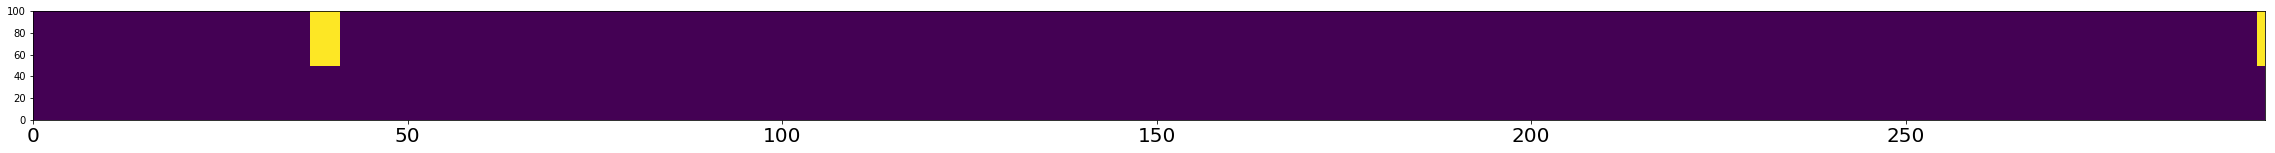

A,P,R:  0.9832214765100671 0.9832214765100671 1.0
Num frames:  (298, 5)
Accuracy:  0.9832214765100671
Person:  1


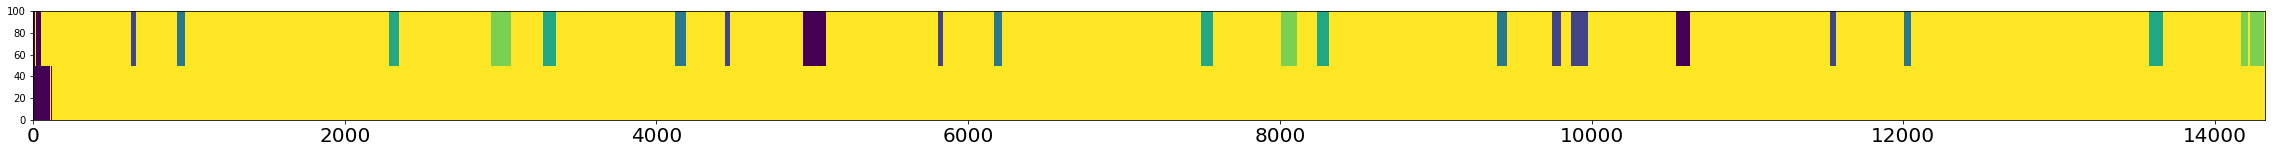

A,P,R:  0.8845052719782138 0.42016806722689076 0.03058103975535168
Num frames:  (119, 69)
Accuracy:  0.8845052719782138
Person:  2


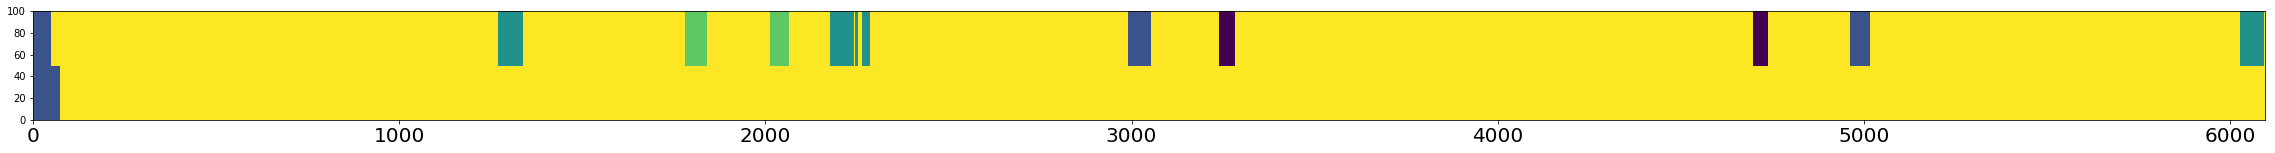

A,P,R:  0.9081364829396326 0.6533333333333333 0.08404802744425385
Num frames:  (75, 26)
Accuracy:  0.9081364829396326
Person:  3


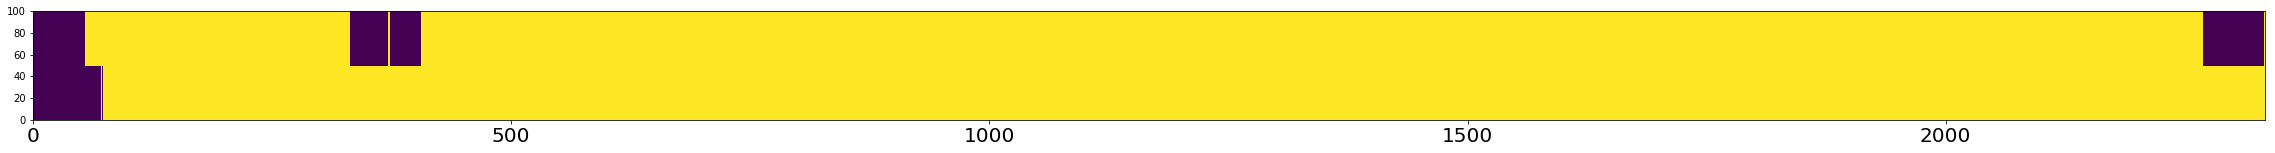

A,P,R:  0.9344473007712082 0.7534246575342466 0.2894736842105263
Num frames:  (73, 18)
Accuracy:  0.9344473007712082
Person:  4


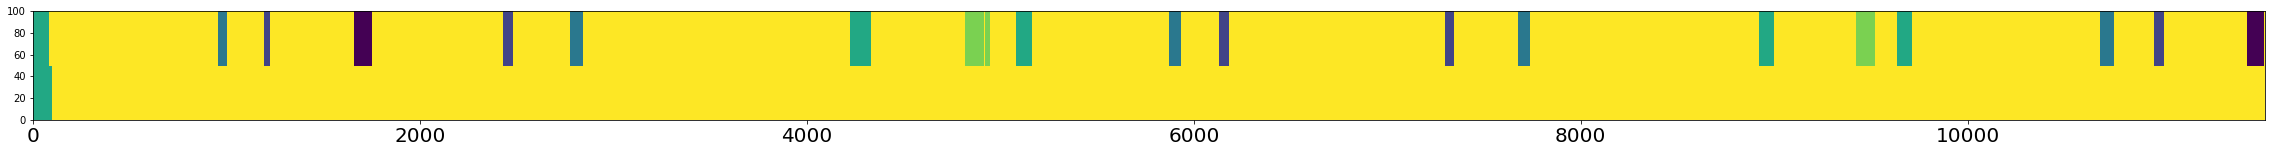

A,P,R:  0.8852387969142758 0.8155339805825242 0.06047516198704104
Num frames:  (103, 19)
Accuracy:  0.8852387969142758
Person:  5


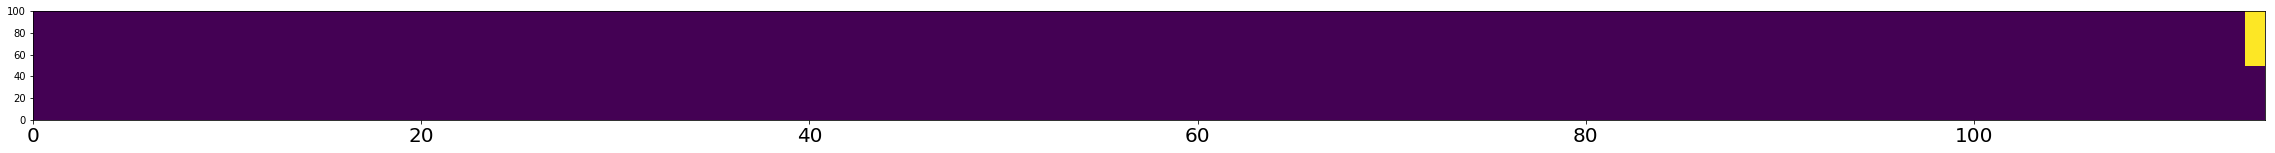

A,P,R:  0.991304347826087 0.991304347826087 1.0
Num frames:  (115, 1)
Accuracy:  0.991304347826087
Person:  6


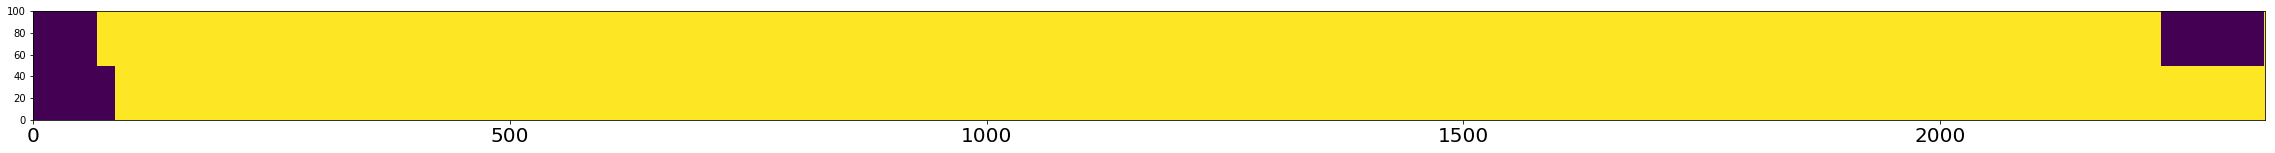

A,P,R:  0.9457496796240923 0.7816091954022989 0.38636363636363635
Num frames:  (87, 19)
Accuracy:  0.9457496796240923
Person:  7


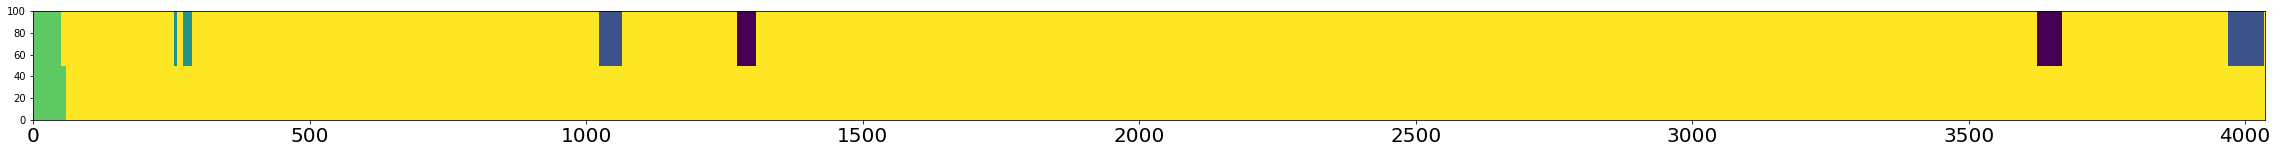

A,P,R:  0.945986124876115 0.8666666666666667 0.1984732824427481
Num frames:  (60, 8)
Accuracy:  0.945986124876115
Person:  8


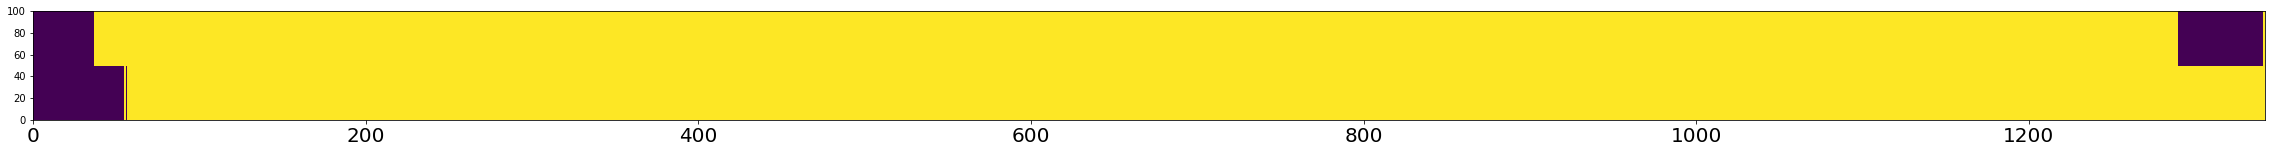

A,P,R:  0.9478390461997019 0.6607142857142857 0.42045454545454547
Num frames:  (56, 19)
Accuracy:  0.9478390461997019
Person:  9


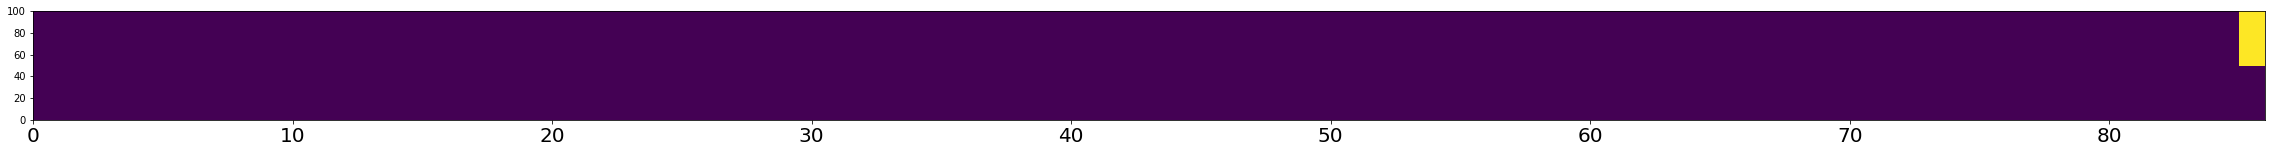

A,P,R:  0.9883720930232558 0.9883720930232558 1.0
Num frames:  (86, 1)
Accuracy:  0.9883720930232558
Person:  10


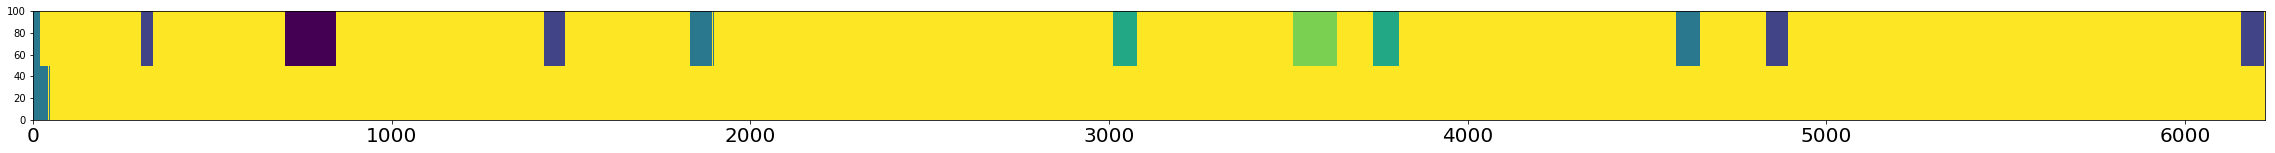

A,P,R:  0.8754619958219508 0.4782608695652174 0.028460543337645538
Num frames:  (46, 24)
Accuracy:  0.8754619958219508
Person:  11


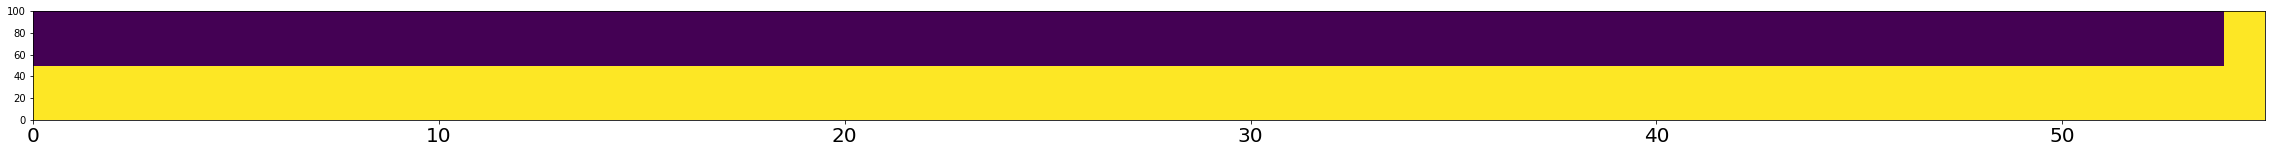

../data/auxiliary.py:323: RuntimeWarning: invalid value encountered in long_scalars
  P = np.sum([p[i]==g[i] and p[i]!=Cx for i in range(len(p))])/np.sum([x!=Cx for x in p])


A,P,R:  0.01818181818181818 nan 0.0
Num frames:  (0, 0)
Accuracy:  0.01818181818181818
Person:  12


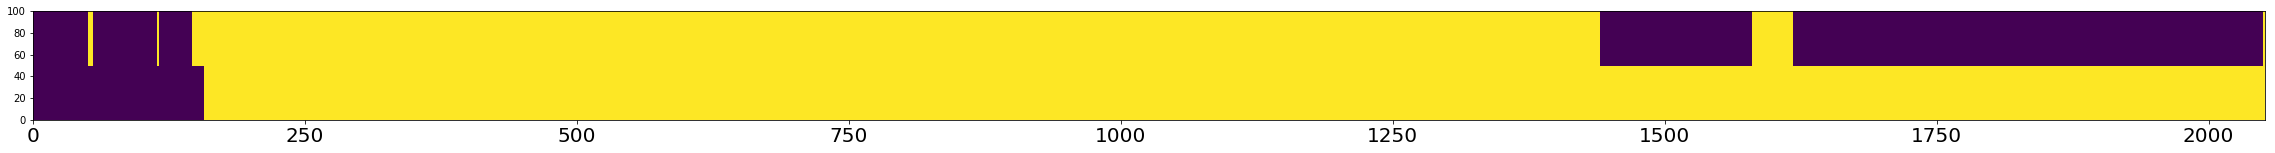

A,P,R:  0.7119883040935673 0.8860759493670886 0.19635343618513323
Num frames:  (158, 18)
Accuracy:  0.7119883040935673
Person:  13


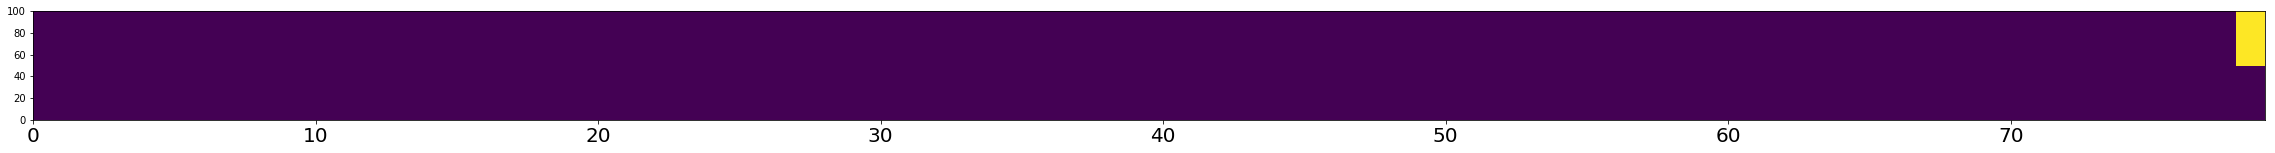

A,P,R:  0.9873417721518988 0.9873417721518988 1.0
Num frames:  (79, 1)
Accuracy:  0.9873417721518988
Person:  14


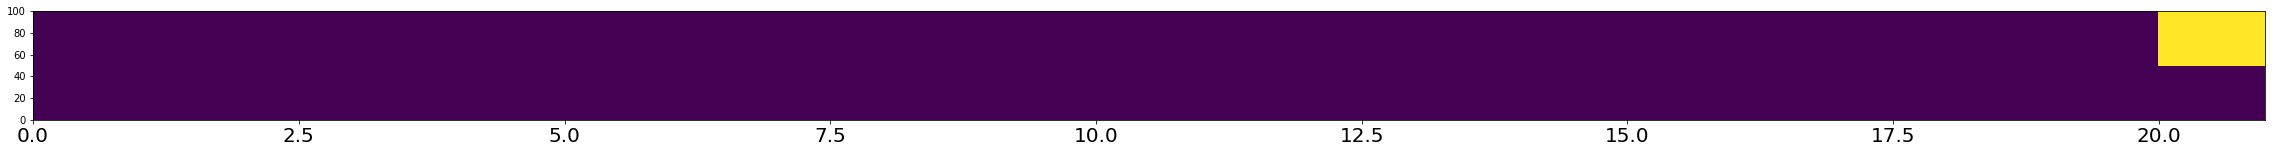

A,P,R:  0.9523809523809523 0.9523809523809523 1.0
Num frames:  (21, 1)
Accuracy:  0.9523809523809523
Person:  15


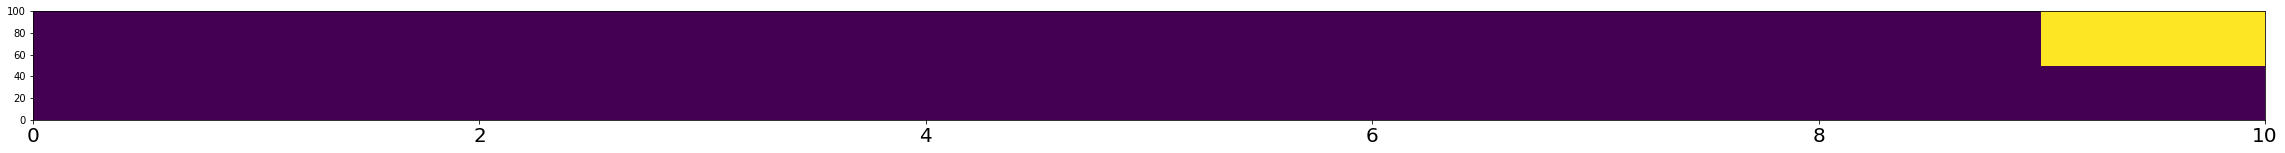

A,P,R:  0.9 0.9 1.0
Num frames:  (10, 1)
Accuracy:  0.9
Person:  16


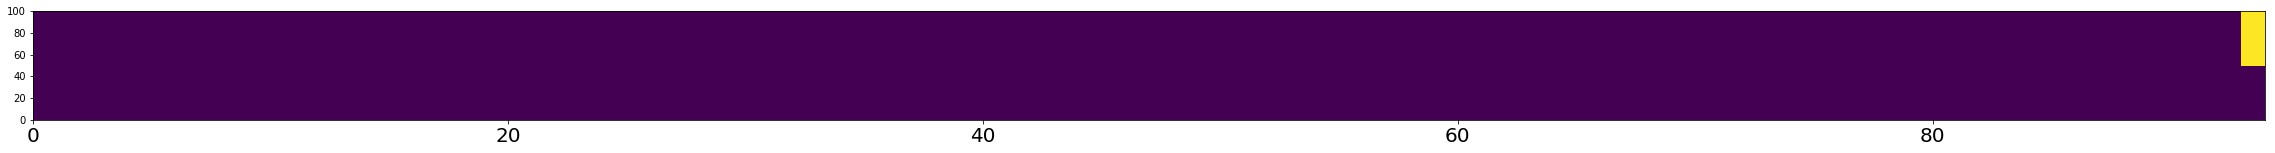

A,P,R:  0.9893617021276596 0.9893617021276596 1.0
Num frames:  (94, 1)
Accuracy:  0.9893617021276596
Person:  17


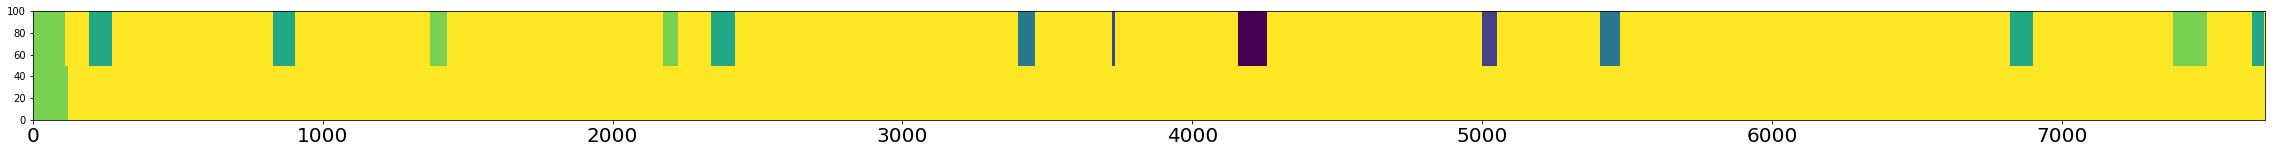

A,P,R:  0.8844455985458323 0.9338842975206612 0.1135678391959799
Num frames:  (121, 8)
Accuracy:  0.8844455985458323
Person:  18


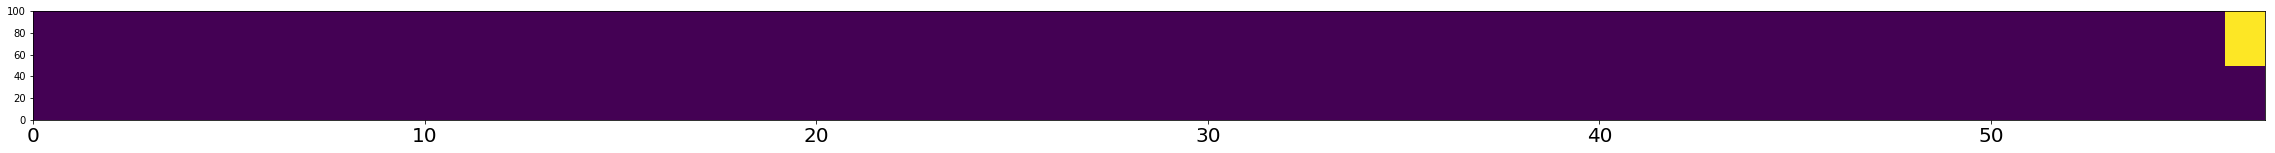

A,P,R:  0.9824561403508771 0.9824561403508771 1.0
Num frames:  (57, 1)
Accuracy:  0.9824561403508771
Person:  19


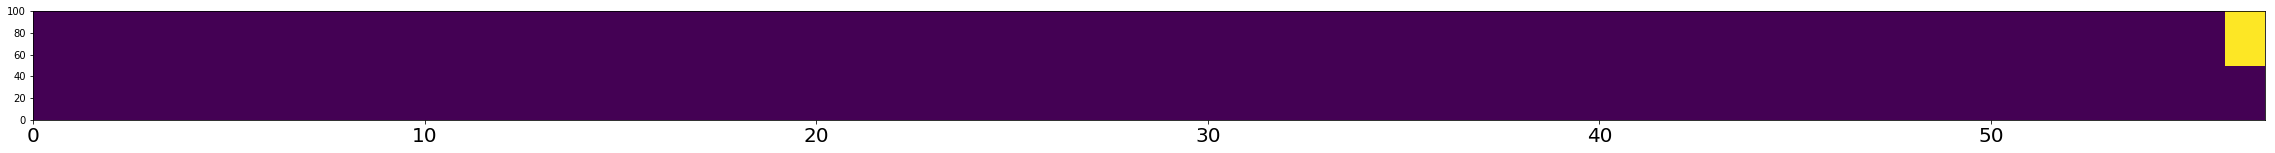

A,P,R:  0.9824561403508771 0.9824561403508771 1.0
Num frames:  (57, 1)
Accuracy:  0.9824561403508771
Person:  20


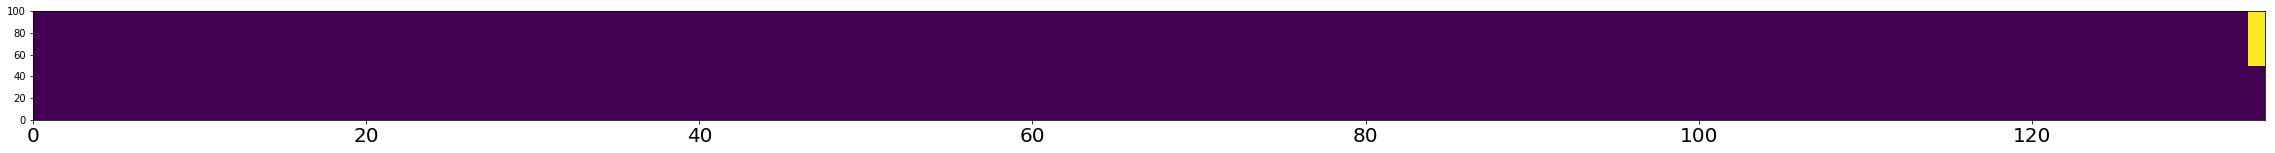

A,P,R:  0.9925373134328358 0.9925373134328358 1.0
Num frames:  (134, 1)
Accuracy:  0.9925373134328358
Person:  21


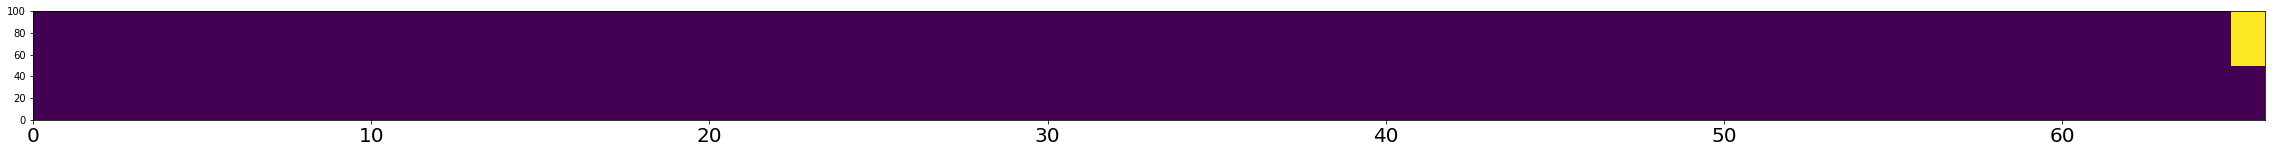

A,P,R:  0.9848484848484849 0.9848484848484849 1.0
Num frames:  (66, 1)
Accuracy:  0.9848484848484849
Person:  22


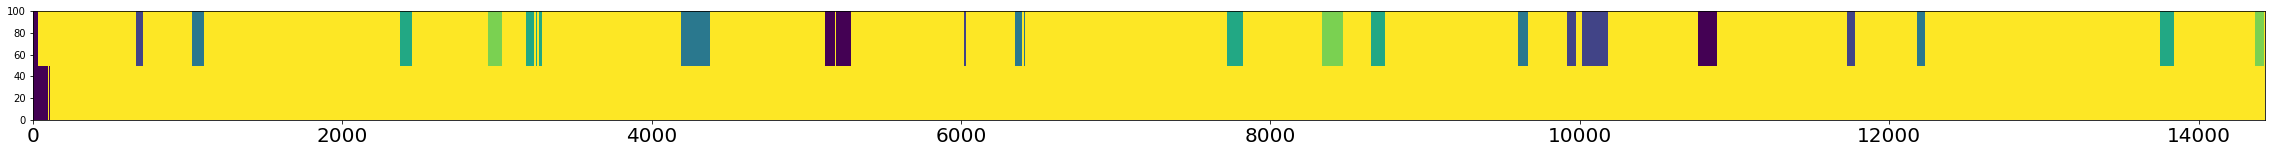

A,P,R:  0.8727650727650728 0.37254901960784315 0.020994475138121547
Num frames:  (102, 64)
Accuracy:  0.8727650727650728
Person:  23


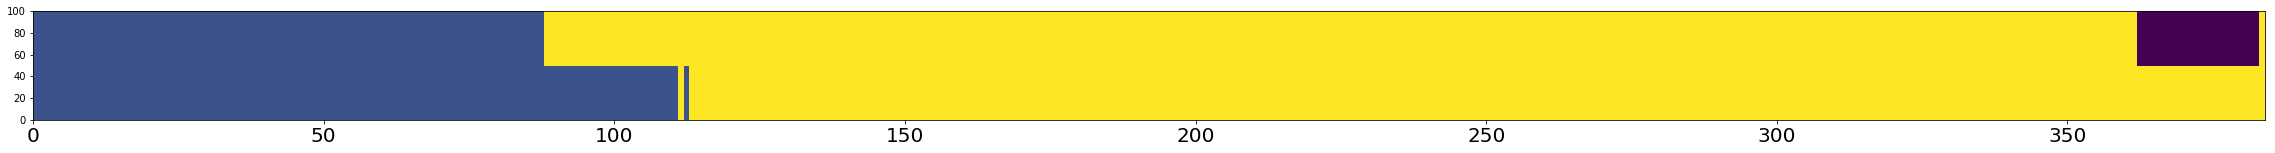

A,P,R:  0.8828125 0.7857142857142857 0.8073394495412844
Num frames:  (112, 24)
Accuracy:  0.8828125
0.8929932673214367
Average A,P,R,F, ttr 0.8929932673214364 nan 0.5681910467106778 13.791666666666666 [3, 47, 23, 7, 41, 1, 3, 13, 3, 1, 23, 1, 9, 1, 1, 1, 1, 27, 1, 1, 1, 1, 57, 3]
2460


In [17]:
policy_net.eval()
req_inc = 0
_,acc = test_func(pTest,iloc='fix',eloc='last', fixLoc=25, isdebug=0, req_inc=req_inc)
tr_acc = 0
A,P,R,F, ttr = [],[],[],[],[]
nfr = []
for i in range(len(acc)):
    print ('Person: ',i)
    gt = np.array([d[0] for d in acc[i]])
    pr = np.array([d[1] for d in acc[i]])
    g = gt #t[gt != num_camera-1]
    p = pr #r[gt != num_camera-1]
    
    # plot transitions
    afc.plot_color_transitions(p,g)
    # MCTA and number of frames
    if req_inc == 1:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    else:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    A.append(ac)
    P.append(pr)
    R.append(re)
    F.append(fr)
    ttr.append(tr)
    print ('A,P,R: ', ac,pr,re)
    f = afc.compute_num_frames(p,g)
    nfr.append(f)
    print ('Num frames: ', f)
    # Accuracy
    tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
    tr_acc += tacc
    print ('Accuracy: ',tacc)
print (tr_acc/len(A))
print ('Average A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
print (np.sum(nfr))

In [ ]:
tr_acc = 0
for i in range(5):
    print ('Person: ',i)
    g = np.array([d[0] for d in acc[i]])
    p = np.array([d[1] for d in acc[i]])
    print (g)
    print (p)
    tr_acc += np.sum(g==p, dtype=np.float)/g.shape[0]
tr_acc/5

In [ ]:
np.log10(1000)

In [ ]:
mcta = []
nfr = []
for i in range(5):
    g = np.array([d[0] for d in acc[i]])
    p = np.array([d[1] for d in acc[i]])
    mcta.append(afc.compute_MCTA(p,g))
    nfr.append(afc.compute_num_frames(p,g))
print (np.mean(mcta))
print (np.sum(nfr))

### Test function

In [ ]:
backup_fname = '/media/win/HRLhkl/Q_CamSel_3L_l4_st200_db3_1tCont_2'
hkl.dump([[episode_reward, running_reward]], backup_fname+'_variables.hkl')

In [21]:
import numpy as np
1/np.log(10)

0.43429448190325176

In [ ]:
pp = 1
np.max(pTest[pp][1:,1] - pTest[pp][0:-1,1])